In [2]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
from spright import RMRelation 

import scienceplots

plt.style.use(('science','no-latex','bright','seaborn-v0_8-poster'))

#Single-column figures: The maximum width is 8.5 cm (3.35 inches).
#Double-column figures: The maximum width is 17.8 cm (7 inches).


/home/xuanji/.local/lib/python3.11/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [3]:
from cosmic_shoreline import CosmicShoreline

cs = CosmicShoreline()

# 1. Uncertainties of Escape Rate

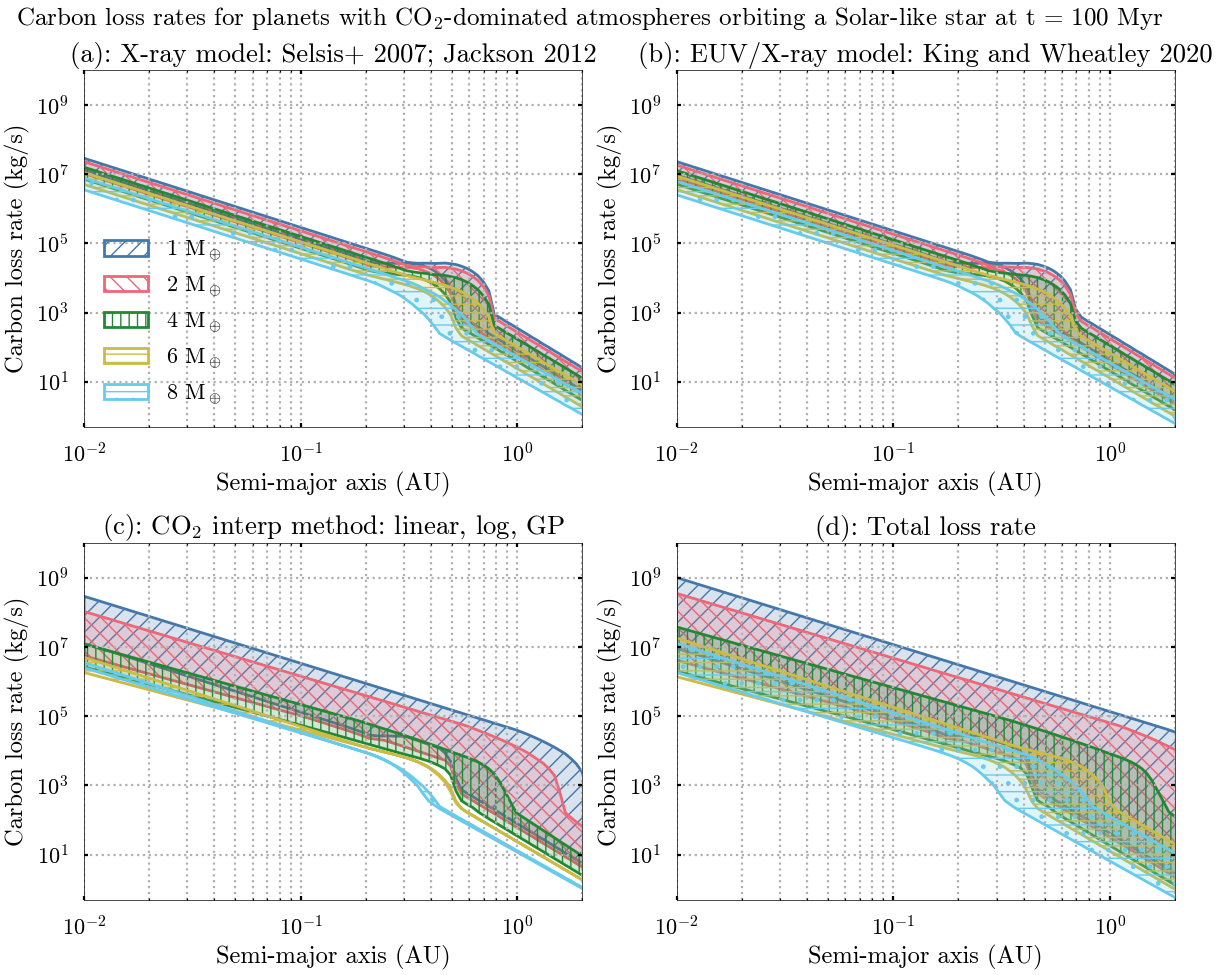

In [30]:
stellar_mass = 1
planet_masses = [1, 2, 4, 6, 8]
semi_major_axes = np.logspace(-2,0.5, 100) # AU

fig, axes = plt.subplots(2,2, figsize=(12,10))

hatches = ['//','\\\\','||','--','-.']


CO2_lower_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))
CO2_upper_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))


for i, planet_mass in enumerate(planet_masses):
    # Uncertainty in the CO2 mass loss rate

    # Caused by fitting method (linear, GP, log)
    L_XUV, L_X, L_EUV1, L_EUV2, Rs = cs.calculate_L_XUV(1, 1e8, method='Jackson',
                                                    output = 'multi-band')
    CO2_upper_fit = np.zeros(len(semi_major_axes))
    CO2_lower_fit = np.zeros(len(semi_major_axes))
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth = cs._calculate_F_xuv_to_earth(L_XUV, semi_major_axis)

        CO2_linear = cs.M_C_dot_CO2(F_xuv_to_earth, planet_mass, CO2_fit = 'linear')
        CO2_GP = cs.M_C_dot_CO2(F_xuv_to_earth, planet_mass, CO2_fit = 'GP')
        CO2_log = cs.M_C_dot_CO2(F_xuv_to_earth, planet_mass, CO2_fit = 'log')

        CO2_upper_fit[j] = np.maximum(CO2_linear, np.maximum(CO2_GP, CO2_log))
        CO2_lower_fit[j] = np.minimum(CO2_linear, np.minimum(CO2_GP, CO2_log))
    
    axes[1,0].fill_between(semi_major_axes, CO2_lower_fit, CO2_upper_fit,
                           facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,0].fill_between(semi_major_axes, CO2_lower_fit, CO2_upper_fit,
                           facecolor = 'none', edgecolor = 'C%d' % i, 
                           lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Caused by X-ray model

    L_XUV_S, L_X_S, L_EUV1_S, L_EUV2_S, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band')
    L_XUV_J, L_X_J, L_EUV1_J, L_EUV2_J, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band')

    CO2_upper_Xray = np.zeros(len(semi_major_axes))
    CO2_lower_Xray = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S = cs._calculate_F_xuv_to_earth(L_XUV_S, semi_major_axis)
        F_xuv_to_earth_J = cs._calculate_F_xuv_to_earth(L_XUV_J, semi_major_axis)

        CO2_S = cs.M_C_dot_CO2(F_xuv_to_earth_S, planet_mass, CO2_fit = 'GP')
        CO2_J = cs.M_C_dot_CO2(F_xuv_to_earth_J, planet_mass, CO2_fit = 'GP')

        CO2_upper_Xray[j] = np.maximum(CO2_S, CO2_J)
        CO2_lower_Xray[j] = np.minimum(CO2_S, CO2_J)

    axes[0,0].fill_between(semi_major_axes, CO2_lower_Xray, CO2_upper_Xray,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,0].fill_between(semi_major_axes, CO2_lower_Xray, CO2_upper_Xray,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Caused by EUV model

    L_XUV_K20_1, L_X_K20_1, L_EUV1_K20_1, L_EUV2_K20_1, Rs_K20_1 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band', 
                                                                                      gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_K20_2, L_X_K20_2, L_EUV1_K20_2, L_EUV2_K20_2, Rs_K20_2 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    
    CO2_upper_EUV = np.zeros(len(semi_major_axes))
    CO2_lower_EUV = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_K20_1 = cs._calculate_F_xuv_to_earth(L_XUV_K20_1, semi_major_axis)
        F_xuv_to_earth_K20_2 = cs._calculate_F_xuv_to_earth(L_XUV_K20_2, semi_major_axis)

        CO2_K20_1 = cs.M_C_dot_CO2(F_xuv_to_earth_K20_1, planet_mass, CO2_fit = 'GP')
        CO2_K20_2 = cs.M_C_dot_CO2(F_xuv_to_earth_K20_2, planet_mass, CO2_fit = 'GP')

        CO2_upper_EUV[j] = np.maximum(CO2_K20_1, CO2_K20_2)
        CO2_lower_EUV[j] = np.minimum(CO2_K20_1, CO2_K20_2)
    
    axes[0,1].fill_between(semi_major_axes, CO2_lower_EUV, CO2_upper_EUV,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,1].fill_between(semi_major_axes, CO2_lower_EUV, CO2_upper_EUV,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Total uncertainty

    CO2_upper_total = np.zeros(len(semi_major_axes))
    CO2_lower_total = np.zeros(len(semi_major_axes))

    L_XUV_S_1, L_X_S_1, L_EUV1_S_1, L_EUV2_S_1, Rs_S_1 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_S_2, L_X_S_2, L_EUV1_S_2, L_EUV2_S_2, Rs_S_2 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    L_XUV_J_1, L_X_J_1, L_EUV1_J_1, L_EUV2_J_1, Rs_J_1 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_J_2, L_X_J_2, L_EUV1_J_2, L_EUV2_J_2, Rs_J_2 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S_1 = cs._calculate_F_xuv_to_earth(L_XUV_S_1, semi_major_axis)
        F_xuv_to_earth_S_2 = cs._calculate_F_xuv_to_earth(L_XUV_S_2, semi_major_axis)
        F_xuv_to_earth_J_1 = cs._calculate_F_xuv_to_earth(L_XUV_J_1, semi_major_axis)
        F_xuv_to_earth_J_2 = cs._calculate_F_xuv_to_earth(L_XUV_J_2, semi_major_axis)

        CO2_S_1_linear = cs.M_C_dot_CO2(F_xuv_to_earth_S_1, planet_mass, CO2_fit = 'linear')
        CO2_S_1_GP = cs.M_C_dot_CO2(F_xuv_to_earth_S_1, planet_mass, CO2_fit = 'GP')
        CO2_S_1_log = cs.M_C_dot_CO2(F_xuv_to_earth_S_1, planet_mass, CO2_fit = 'log')
        
        CO2_S_2_linear = cs.M_C_dot_CO2(F_xuv_to_earth_S_2, planet_mass, CO2_fit = 'linear')
        CO2_S_2_GP = cs.M_C_dot_CO2(F_xuv_to_earth_S_2, planet_mass, CO2_fit = 'GP')
        CO2_S_2_log = cs.M_C_dot_CO2(F_xuv_to_earth_S_2, planet_mass, CO2_fit = 'log')
        
        CO2_J_1_linear = cs.M_C_dot_CO2(F_xuv_to_earth_J_1, planet_mass, CO2_fit = 'linear')
        CO2_J_1_GP = cs.M_C_dot_CO2(F_xuv_to_earth_J_1, planet_mass, CO2_fit = 'GP')
        CO2_J_1_log = cs.M_C_dot_CO2(F_xuv_to_earth_J_1, planet_mass, CO2_fit = 'log')
        
        CO2_J_2_linear = cs.M_C_dot_CO2(F_xuv_to_earth_J_2, planet_mass, CO2_fit = 'linear')
        CO2_J_2_GP = cs.M_C_dot_CO2(F_xuv_to_earth_J_2, planet_mass, CO2_fit = 'GP')
        CO2_J_2_log = cs.M_C_dot_CO2(F_xuv_to_earth_J_2, planet_mass, CO2_fit = 'log')
        
        CO2_S_1 = np.maximum(CO2_S_1_linear, np.maximum(CO2_S_1_GP, CO2_S_1_log))
        CO2_S_2 = np.maximum(CO2_S_2_linear, np.maximum(CO2_S_2_GP, CO2_S_2_log))
        CO2_J_1 = np.maximum(CO2_J_1_linear, np.maximum(CO2_J_1_GP, CO2_J_1_log))
        CO2_J_2 = np.maximum(CO2_J_2_linear, np.maximum(CO2_J_2_GP, CO2_J_2_log))
        
        CO2_upper_total[j] = np.maximum(CO2_S_1, np.maximum(CO2_S_2, np.maximum(CO2_J_1, CO2_J_2)))

        CO2_S_1 = np.minimum(CO2_S_1_linear, np.minimum(CO2_S_1_GP, CO2_S_1_log))
        CO2_S_2 = np.minimum(CO2_S_2_linear, np.minimum(CO2_S_2_GP, CO2_S_2_log))
        CO2_J_1 = np.minimum(CO2_J_1_linear, np.minimum(CO2_J_1_GP, CO2_J_1_log))
        CO2_J_2 = np.minimum(CO2_J_2_linear, np.minimum(CO2_J_2_GP, CO2_J_2_log))
        
        CO2_lower_total[j] = np.minimum(CO2_S_1, np.minimum(CO2_S_2, np.minimum(CO2_J_1, CO2_J_2)))

    CO2_upper_total_plot[i] = CO2_upper_total
    CO2_lower_total_plot[i] = CO2_lower_total

    axes[1,1].fill_between(semi_major_axes, CO2_lower_total, CO2_upper_total,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,1].fill_between(semi_major_axes, CO2_lower_total, CO2_upper_total,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)




for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log') 
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(5e-1,1e10)
    ax.set_ylabel('Carbon loss rate (kg/s)')



axes[1,0].set_title('(c): CO$_2$ interp method: linear, log, GP')
axes[0,0].legend(loc='lower left')



axes[0,0].set_title('(a): X-ray model: Selsis+ 2007; Jackson 2012')

axes[0,1].set_title('(b): EUV/X-ray model: King and Wheatley 2020')

axes[1,1].set_title('(d): Total loss rate')

fig.suptitle('Carbon loss rates for planets with CO$_2$-dominated atmospheres orbiting a Solar-like star at t = 100 Myr', fontsize=18)
plt.tight_layout()




fig.savefig('./figures/atmospheric_loss_rates_unc_CO2.pdf',bbox_inches='tight')           

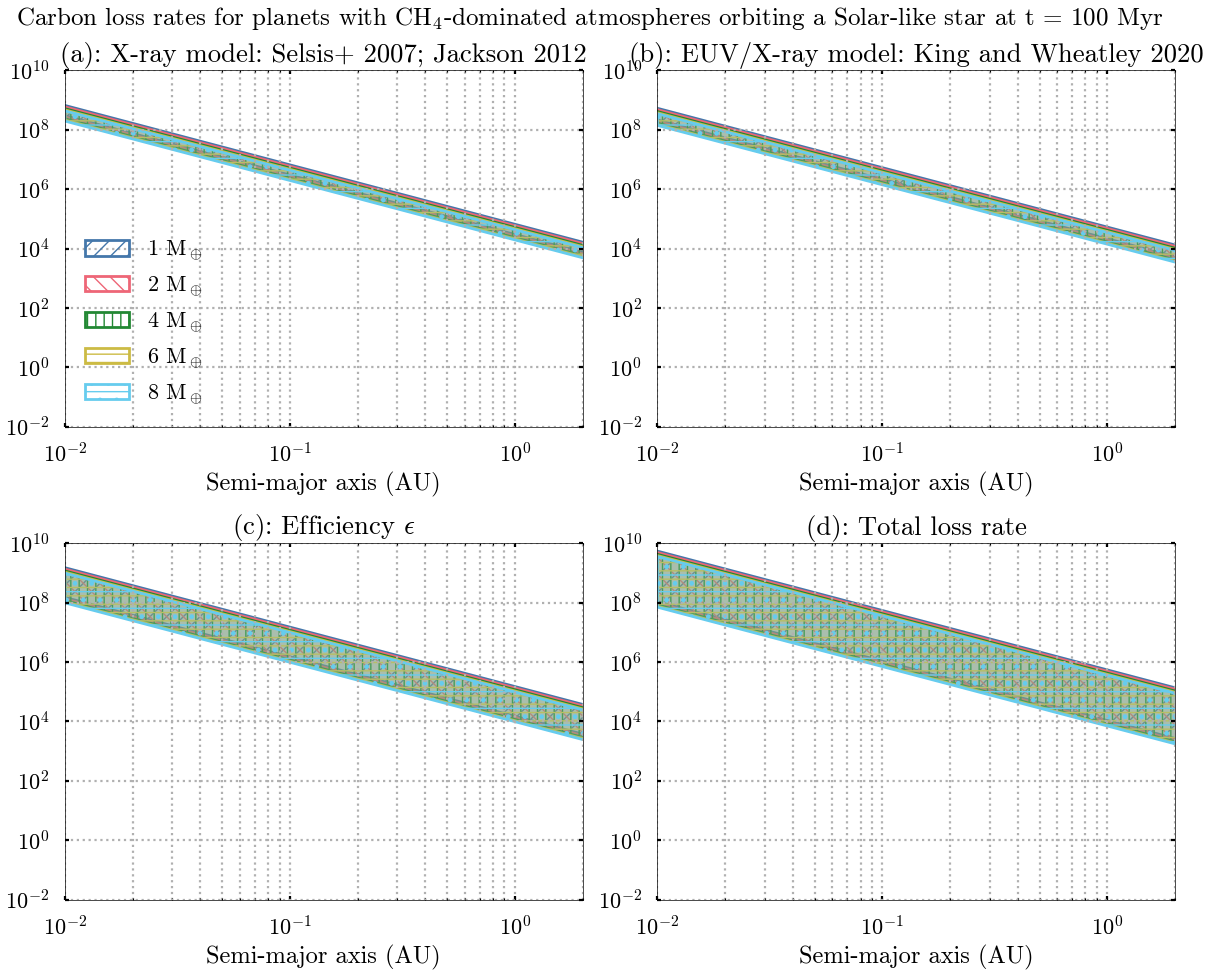

In [31]:
stellar_mass = 1
planet_masses = [1, 2, 4, 6, 8]
semi_major_axes = np.logspace(-2,0.5, 100) # AU
fig, axes = plt.subplots(2,2, figsize=(12,10))
hatches = ['//','\\\\','||','--','-.']


CH4_lower_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))
CH4_upper_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))

for i, planet_mass in enumerate(planet_masses):
    # Uncertainty in the CH4 mass loss rate

    # Caused by epsilon of the XUV heating
    CH4_upper_eff = np.zeros(len(semi_major_axes))
    CH4_lower_eff = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        L_XUV, L_X, L_EUV1, L_EUV2, Rs = cs.calculate_L_XUV(1, 1e8, method='Jackson', output = 'multi-band')
        F_xuv_to_earth = cs._calculate_F_xuv_to_earth(L_XUV, semi_major_axis)

        CH4_eff_1 = cs.M_C_dot_CH4(F_xuv_to_earth, planet_mass, epsilon = 0.05)
        CH4_eff_2 = cs.M_C_dot_CH4(F_xuv_to_earth, planet_mass, epsilon = 0.5)

        CH4_upper_eff[j] = np.maximum(CH4_eff_1, CH4_eff_2)
        CH4_lower_eff[j] = np.minimum(CH4_eff_1, CH4_eff_2)
    
    axes[1,0].fill_between(semi_major_axes, CH4_lower_eff, CH4_upper_eff,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,0].fill_between(semi_major_axes, CH4_lower_eff, CH4_upper_eff,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    # Caused by X-ray model
    L_XUV_S, L_X_S, L_EUV1_S, L_EUV2_S, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band')
    L_XUV_J, L_X_J, L_EUV1_J, L_EUV2_J, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band')
    CH4_upper_Xray = np.zeros(len(semi_major_axes))
    CH4_lower_Xray = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S = cs._calculate_F_xuv_to_earth(L_XUV_S, semi_major_axis)
        F_xuv_to_earth_J = cs._calculate_F_xuv_to_earth(L_XUV_J, semi_major_axis)

        CH4_S = cs.M_C_dot_CH4(F_xuv_to_earth_S, planet_mass, epsilon = 0.1)
        CH4_J = cs.M_C_dot_CH4(F_xuv_to_earth_J, planet_mass, epsilon = 0.1)

        CH4_upper_Xray[j] = np.maximum(CH4_S, CH4_J)
        CH4_lower_Xray[j] = np.minimum(CH4_S, CH4_J)
    axes[0,0].fill_between(semi_major_axes, CH4_lower_Xray, CH4_upper_Xray,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,0].fill_between(semi_major_axes, CH4_lower_Xray, CH4_upper_Xray,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    # Caused by EUV model
    L_XUV_K20_1, L_X_K20_1, L_EUV1_K20_1, L_EUV2_K20_1, Rs_K20_1 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band', 
                                                                                      gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_K20_2, L_X_K20_2, L_EUV1_K20_2, L_EUV2_K20_2, Rs_K20_2 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    CH4_upper_EUV = np.zeros(len(semi_major_axes))
    CH4_lower_EUV = np.zeros(len(semi_major_axes))
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_K20_1 = cs._calculate_F_xuv_to_earth(L_XUV_K20_1, semi_major_axis)
        F_xuv_to_earth_K20_2 = cs._calculate_F_xuv_to_earth(L_XUV_K20_2, semi_major_axis)

        CH4_K20_1 = cs.M_C_dot_CH4(F_xuv_to_earth_K20_1, planet_mass, epsilon = 0.1)
        CH4_K20_2 = cs.M_C_dot_CH4(F_xuv_to_earth_K20_2, planet_mass, epsilon = 0.1)  

        CH4_upper_EUV[j] = np.maximum(CH4_K20_1, CH4_K20_2)
        CH4_lower_EUV[j] = np.minimum(CH4_K20_1, CH4_K20_2)

    axes[0,1].fill_between(semi_major_axes, CH4_lower_EUV, CH4_upper_EUV,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,1].fill_between(semi_major_axes, CH4_lower_EUV, CH4_upper_EUV,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Total uncertainty
    CH4_upper_total = np.zeros(len(semi_major_axes))
    CH4_lower_total = np.zeros(len(semi_major_axes))

    L_XUV_S_1, L_X_S_1, L_EUV1_S_1, L_EUV2_S_1, Rs_S_1 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)   
    L_XUV_S_2, L_X_S_2, L_EUV1_S_2, L_EUV2_S_2, Rs_S_2 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    L_XUV_J_1, L_X_J_1, L_EUV1_J_1, L_EUV2_J_1, Rs_J_1 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_J_2, L_X_J_2, L_EUV1_J_2, L_EUV2_J_2, Rs_J_2 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)   
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S_1 = cs._calculate_F_xuv_to_earth(L_XUV_S_1, semi_major_axis)
        F_xuv_to_earth_S_2 = cs._calculate_F_xuv_to_earth(L_XUV_S_2, semi_major_axis)
        F_xuv_to_earth_J_1 = cs._calculate_F_xuv_to_earth(L_XUV_J_1, semi_major_axis)
        F_xuv_to_earth_J_2 = cs._calculate_F_xuv_to_earth(L_XUV_J_2, semi_major_axis)

        CH4_S_1 = cs.M_C_dot_CH4(F_xuv_to_earth_S_1, planet_mass, epsilon = 0.05)
        CH4_S_2 = cs.M_C_dot_CH4(F_xuv_to_earth_S_2, planet_mass, epsilon = 0.05)
        CH4_J_1 = cs.M_C_dot_CH4(F_xuv_to_earth_J_1, planet_mass, epsilon = 0.05)
        CH4_J_2 = cs.M_C_dot_CH4(F_xuv_to_earth_J_2, planet_mass, epsilon = 0.05)

        CH4_upper_total[j] = np.maximum(CH4_S_1, np.maximum(CH4_S_2, np.maximum(CH4_J_1, CH4_J_2)))* 10
        CH4_lower_total[j] = np.minimum(CH4_S_1, np.minimum(CH4_S_2, np.minimum(CH4_J_1, CH4_J_2)))
    CH4_upper_total_plot[i] = CH4_upper_total
    CH4_lower_total_plot[i] = CH4_lower_total

    axes[1,1].fill_between(semi_major_axes, CH4_lower_total, CH4_upper_total,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,1].fill_between(semi_major_axes, CH4_lower_total, CH4_upper_total,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(1e-2,1e10)
axes[1,0].set_title('(c): Efficiency $\epsilon$')
axes[0,0].legend(loc='lower left')
axes[0,0].set_title('(a): X-ray model: Selsis+ 2007; Jackson 2012')
axes[0,1].set_title('(b): EUV/X-ray model: King and Wheatley 2020')
axes[1,1].set_title('(d): Total loss rate')
fig.suptitle('Carbon loss rates for planets with CH$_4$-dominated atmospheres orbiting a Solar-like star at t = 100 Myr', fontsize=18)
plt.tight_layout()
                                                        

fig.savefig('./figures/atmospheric_loss_rates_unc_CH4.pdf',bbox_inches='tight')           

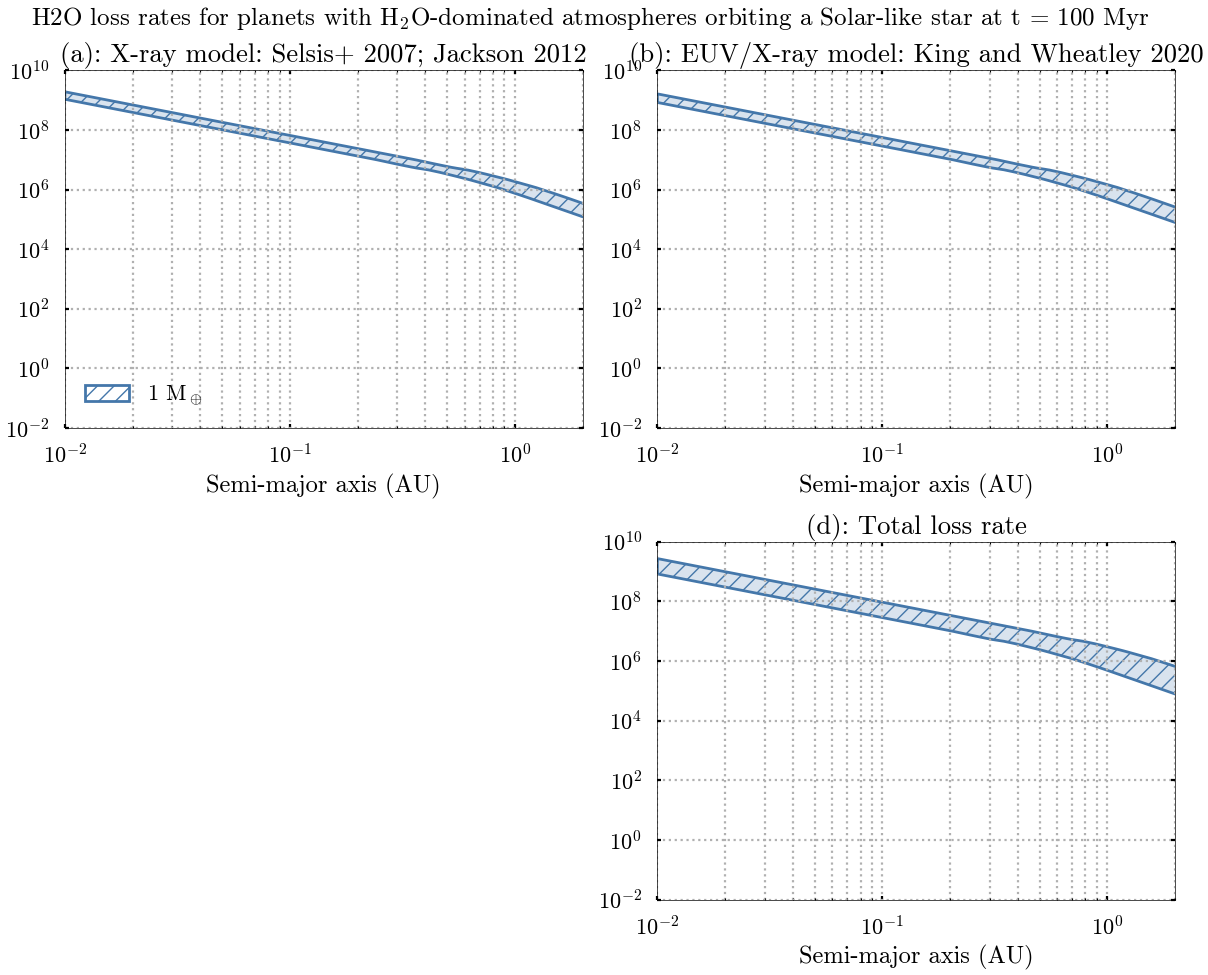

In [32]:
# H2O Johnstone et al. 2020
stellar_mass = 1
planet_masses = [1]
semi_major_axes = np.logspace(-2,0.5, 100) # AU
fig, axes = plt.subplots(2,2, figsize=(12,10))
hatches = ['//','\\\\','||','--','-.']

H2O_lower_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))
H2O_upper_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))

for i, planet_mass in enumerate(planet_masses):
    # Uncertainty caused by the X-ray model
    L_XUV_S, L_X_S, L_EUV1_S, L_EUV2_S, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band')
    L_XUV_J, L_X_J, L_EUV1_J, L_EUV2_J, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band')

    H2O_upper_Xray = np.zeros(len(semi_major_axes))
    H2O_lower_Xray = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S = cs._calculate_F_xuv_to_earth(L_XUV_S, semi_major_axis)
        F_xuv_to_earth_J = cs._calculate_F_xuv_to_earth(L_XUV_J, semi_major_axis)

        H2O_S = cs.M_C_dot_H2O(F_xuv_to_earth_S, planet_mass)
        H2O_J = cs.M_C_dot_H2O(F_xuv_to_earth_J, planet_mass)

        H2O_upper_Xray[j] = np.maximum(H2O_S, H2O_J)
        H2O_lower_Xray[j] = np.minimum(H2O_S, H2O_J)

    axes[0,0].fill_between(semi_major_axes, H2O_lower_Xray, H2O_upper_Xray,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,0].fill_between(semi_major_axes, H2O_lower_Xray, H2O_upper_Xray,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Uncertainty caused by the EUV model
    L_XUV_K20_1, L_X_K20_1, L_EUV1_K20_1, L_EUV2_K20_1, Rs_K20_1 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band', 
                                                                                      gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_K20_2, L_X_K20_2, L_EUV1_K20_2, L_EUV2_K20_2, Rs_K20_2 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    H2O_upper_EUV = np.zeros(len(semi_major_axes))
    H2O_lower_EUV = np.zeros(len(semi_major_axes))      

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_K20_1 = cs._calculate_F_xuv_to_earth(L_XUV_K20_1, semi_major_axis)
        F_xuv_to_earth_K20_2 = cs._calculate_F_xuv_to_earth(L_XUV_K20_2, semi_major_axis)

        H2O_K20_1 = cs.M_C_dot_H2O(F_xuv_to_earth_K20_1, planet_mass)
        H2O_K20_2 = cs.M_C_dot_H2O(F_xuv_to_earth_K20_2, planet_mass)

        H2O_upper_EUV[j] = np.maximum(H2O_K20_1, H2O_K20_2)
        H2O_lower_EUV[j] = np.minimum(H2O_K20_1, H2O_K20_2)
    axes[0,1].fill_between(semi_major_axes, H2O_lower_EUV, H2O_upper_EUV,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,1].fill_between(semi_major_axes, H2O_lower_EUV, H2O_upper_EUV,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Total uncertainty
    H2O_upper_total = np.zeros(len(semi_major_axes))
    H2O_lower_total = np.zeros(len(semi_major_axes))
    L_XUV_S_1, L_X_S_1, L_EUV1_S_1, L_EUV2_S_1, Rs_S_1 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_S_2, L_X_S_2, L_EUV1_S_2, L_EUV2_S_2, Rs_S_2 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)   
    L_XUV_J_1, L_X_J_1, L_EUV1_J_1, L_EUV2_J_1, Rs_J_1 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_J_2, L_X_J_2, L_EUV1_J_2, L_EUV2_J_2, Rs_J_2 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S_1 = cs._calculate_F_xuv_to_earth(L_XUV_S_1, semi_major_axis)
        F_xuv_to_earth_S_2 = cs._calculate_F_xuv_to_earth(L_XUV_S_2, semi_major_axis)
        F_xuv_to_earth_J_1 = cs._calculate_F_xuv_to_earth(L_XUV_J_1, semi_major_axis)
        F_xuv_to_earth_J_2 = cs._calculate_F_xuv_to_earth(L_XUV_J_2, semi_major_axis)

        H2O_S_1 = cs.M_C_dot_H2O(F_xuv_to_earth_S_1, planet_mass)
        H2O_S_2 = cs.M_C_dot_H2O(F_xuv_to_earth_S_2, planet_mass)
        H2O_J_1 = cs.M_C_dot_H2O(F_xuv_to_earth_J_1, planet_mass)
        H2O_J_2 = cs.M_C_dot_H2O(F_xuv_to_earth_J_2, planet_mass)

        H2O_upper_total[j] = np.maximum(H2O_S_1, np.maximum(H2O_S_2, np.maximum(H2O_J_1, H2O_J_2)))
        H2O_lower_total[j] = np.minimum(H2O_S_1, np.minimum(H2O_S_2, np.minimum(H2O_J_1, H2O_J_2)))

    H2O_upper_total_plot[i] = H2O_upper_total
    H2O_lower_total_plot[i] = H2O_lower_total

    axes[1,1].fill_between(semi_major_axes, H2O_lower_total, H2O_upper_total,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,1].fill_between(semi_major_axes, H2O_lower_total, H2O_upper_total,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(1e-2,1e10)
axes[0,0].set_title('(a): X-ray model: Selsis+ 2007; Jackson 2012')
axes[0,1].set_title('(b): EUV/X-ray model: King and Wheatley 2020')
axes[1,1].set_title('(d): Total loss rate')

axes[1,0].remove()

axes[0,0].legend(loc='lower left')
fig.suptitle('H2O loss rates for planets with H$_2$O-dominated atmospheres orbiting a Solar-like star at t = 100 Myr', fontsize=18)
plt.tight_layout()
fig.savefig('./figures/atmospheric_loss_rates_unc_H2O.pdf',bbox_inches='tight')

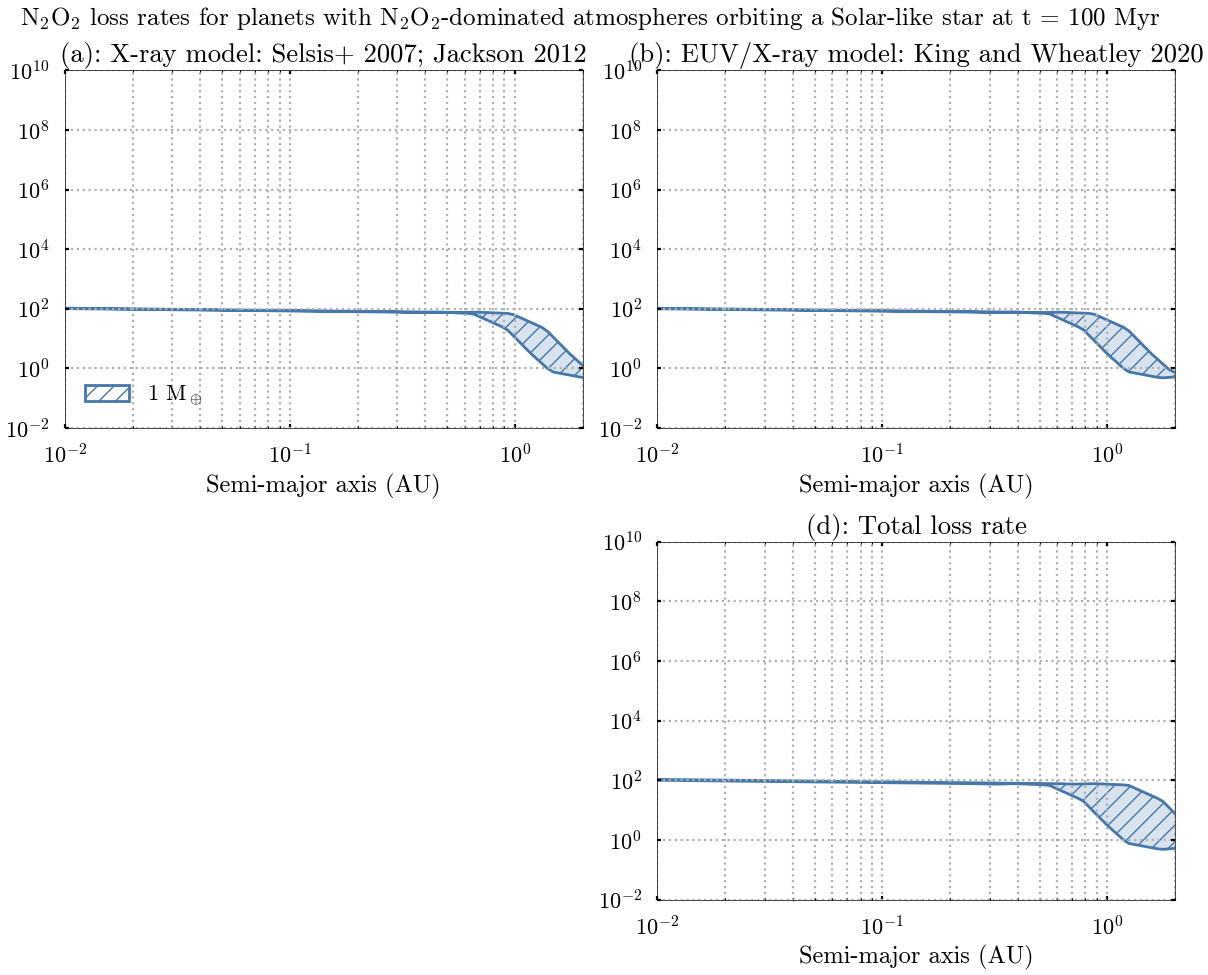

In [33]:
# N2O2 N22
stellar_mass = 1
planet_masses = [1]
semi_major_axes = np.logspace(-2,0.5, 100) # AU
fig, axes = plt.subplots(2,2, figsize=(12,10))

hatches = ['//','\\\\','||','--','-.']

N2O2_lower_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))
N2O2_upper_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))

for i, planet_mass in enumerate(planet_masses):
    # Uncertainty caused by the X-ray model
    L_XUV_S, L_X_S, L_EUV1_S, L_EUV2_S, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band')
    L_XUV_J, L_X_J, L_EUV1_J, L_EUV2_J, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band')

    N2O2_upper_Xray = np.zeros(len(semi_major_axes))
    N2O2_lower_Xray = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S = cs._calculate_F_xuv_to_earth(L_XUV_S, semi_major_axis)
        F_xuv_to_earth_J = cs._calculate_F_xuv_to_earth(L_XUV_J, semi_major_axis)

        N2O2_S = cs.M_C_dot_N2O2(F_xuv_to_earth_S, planet_mass)
        N2O2_J = cs.M_C_dot_N2O2(F_xuv_to_earth_J, planet_mass)

        N2O2_upper_Xray[j] = np.maximum(N2O2_S, N2O2_J)
        N2O2_lower_Xray[j] = np.minimum(N2O2_S, N2O2_J)

    axes[0,0].fill_between(semi_major_axes, N2O2_lower_Xray, N2O2_upper_Xray,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,0].fill_between(semi_major_axes, N2O2_lower_Xray, N2O2_upper_Xray,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Uncertainty caused by the EUV model
    L_XUV_K20_1, L_X_K20_1, L_EUV1_K20_1, L_EUV2_K20_1, Rs_K20_1 = cs.calculate_L_XUV(1, 1e8
                                                                                      , output= 'multi-band', 
                                                                                      gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_K20_2, L_X_K20_2, L_EUV1_K20_2, L_EUV2_K20_2, Rs_K20_2 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    N2O2_upper_EUV = np.zeros(len(semi_major_axes))
    N2O2_lower_EUV = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_K20_1 = cs._calculate_F_xuv_to_earth(L_XUV_K20_1, semi_major_axis)
        F_xuv_to_earth_K20_2 = cs._calculate_F_xuv_to_earth(L_XUV_K20_2, semi_major_axis)

        N2O2_K20_1 = cs.M_C_dot_N2O2(F_xuv_to_earth_K20_1, planet_mass)
        N2O2_K20_2 = cs.M_C_dot_N2O2(F_xuv_to_earth_K20_2, planet_mass)

        N2O2_upper_EUV[j] = np.maximum(N2O2_K20_1, N2O2_K20_2)
        N2O2_lower_EUV[j] = np.minimum(N2O2_K20_1, N2O2_K20_2)
    axes[0,1].fill_between(semi_major_axes, N2O2_lower_EUV, N2O2_upper_EUV,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,1].fill_between(semi_major_axes, N2O2_lower_EUV, N2O2_upper_EUV,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Total uncertainty
    N2O2_upper_total = np.zeros(len(semi_major_axes))
    N2O2_lower_total = np.zeros(len(semi_major_axes))

    L_XUV_S_1, L_X_S_1, L_EUV1_S_1, L_EUV2_S_1, Rs_S_1 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)   
    L_XUV_S_2, L_X_S_2, L_EUV1_S_2, L_EUV2_S_2, Rs_S_2 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)   
    L_XUV_J_1, L_X_J_1, L_EUV1_J_1, L_EUV2_J_1, Rs_J_1 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)   
    L_XUV_J_2, L_X_J_2, L_EUV1_J_2, L_EUV2_J_2, Rs_J_2 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S_1 = cs._calculate_F_xuv_to_earth(L_XUV_S_1, semi_major_axis)
        F_xuv_to_earth_S_2 = cs._calculate_F_xuv_to_earth(L_XUV_S_2, semi_major_axis)
        F_xuv_to_earth_J_1 = cs._calculate_F_xuv_to_earth(L_XUV_J_1, semi_major_axis)
        F_xuv_to_earth_J_2 = cs._calculate_F_xuv_to_earth(L_XUV_J_2, semi_major_axis)

        N2O2_S_1 = cs.M_C_dot_N2O2(F_xuv_to_earth_S_1, planet_mass)
        N2O2_S_2 = cs.M_C_dot_N2O2(F_xuv_to_earth_S_2, planet_mass)
        N2O2_J_1 = cs.M_C_dot_N2O2(F_xuv_to_earth_J_1, planet_mass)
        N2O2_J_2 = cs.M_C_dot_N2O2(F_xuv_to_earth_J_2, planet_mass)

        N2O2_upper_total[j] = np.maximum(N2O2_S_1, np.maximum(N2O2_S_2, np.maximum(N2O2_J_1, N2O2_J_2)))
        N2O2_lower_total[j] = np.minimum(N2O2_S_1, np.minimum(N2O2_S_2, np.minimum(N2O2_J_1, N2O2_J_2)))

    N2O2_upper_total_plot[i] = N2O2_upper_total
    N2O2_lower_total_plot[i] = N2O2_lower_total
    
    axes[1,1].fill_between(semi_major_axes, N2O2_lower_total, N2O2_upper_total,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,1].fill_between(semi_major_axes, N2O2_lower_total, N2O2_upper_total, 
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(1e-2,1e10)
axes[0,0].set_title('(a): X-ray model: Selsis+ 2007; Jackson 2012')
axes[0,1].set_title('(b): EUV/X-ray model: King and Wheatley 2020')
axes[1,1].set_title('(d): Total loss rate')
axes[1,0].remove()
axes[0,0].legend(loc='lower left')
fig.suptitle('N$_2$O$_2$ loss rates for planets with N$_2$O$_2$-dominated atmospheres orbiting a Solar-like star at t = 100 Myr', fontsize=18)
plt.tight_layout()
fig.savefig('./figures/atmospheric_loss_rates_unc_N2O2_N22.pdf',bbox_inches='tight')


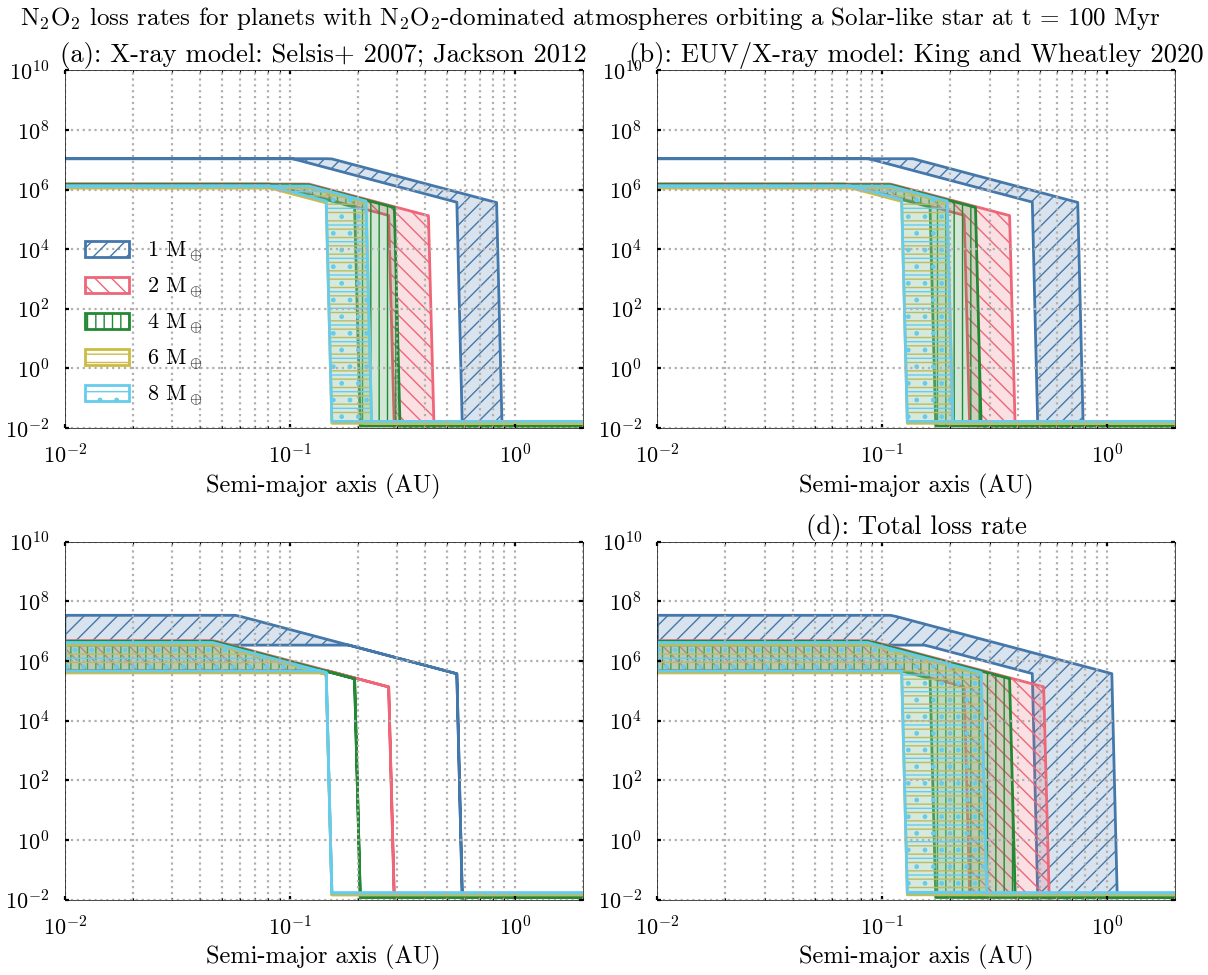

In [34]:
# N2O2 CR24

stellar_mass = 1
planet_masses = [1, 2, 4, 6, 8]
semi_major_axes = np.logspace(-2,0.5, 100) # AU
fig, axes = plt.subplots(2,2, figsize=(12,10))
hatches = ['//','\\\\','||','--','-.']

N2O2_lower_CR24_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))
N2O2_upper_CR24_total_plot = np.zeros((len(planet_masses), len(semi_major_axes)))

for i, planet_mass in enumerate(planet_masses):
    # Uncertainty in CR24 model
    L_XUV, L_X, L_EUV1, L_EUV2, Rs = cs.calculate_L_XUV(1, 1e8, output= 'multi-band')
    N2O2_upper_CR24_CR24 = np.zeros(len(semi_major_axes))
    N2O2_lower_CR24_CR24 = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth = cs._calculate_F_xuv_to_earth(L_XUV, semi_major_axis)

        N2O2_CR24_low = cs.M_C_dot_N2O2(F_xuv_to_earth, planet_mass, model = 'CR24',frac=0)
        N2O2_CR24_high = cs.M_C_dot_N2O2(F_xuv_to_earth, planet_mass, model = 'CR24',frac=1)

        N2O2_upper_CR24_CR24[j] = max(N2O2_CR24_low, N2O2_CR24_high)
        N2O2_lower_CR24_CR24[j] = min(N2O2_CR24_low, N2O2_CR24_high)
    axes[1,0].fill_between(semi_major_axes, N2O2_lower_CR24_CR24, N2O2_upper_CR24_CR24,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,0].fill_between(semi_major_axes, N2O2_lower_CR24_CR24, N2O2_upper_CR24_CR24,
                            facecolor = 'none', edgecolor = 'C%d' % i,
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)

    # Uncertainty caused by the X-ray model
    L_XUV_S, L_X_S, L_EUV1_S, L_EUV2_S, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band')
    L_XUV_J, L_X_J, L_EUV1_J, L_EUV2_J, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band')
    N2O2_upper_CR24_Xray = np.zeros(len(semi_major_axes))
    N2O2_lower_CR24_Xray = np.zeros(len(semi_major_axes))

    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S = cs._calculate_F_xuv_to_earth(L_XUV_S, semi_major_axis)
        F_xuv_to_earth_J = cs._calculate_F_xuv_to_earth(L_XUV_J, semi_major_axis)

        N2O2_S = cs.M_C_dot_N2O2(F_xuv_to_earth_S, planet_mass, model = 'CR24')
        N2O2_J = cs.M_C_dot_N2O2(F_xuv_to_earth_J, planet_mass, model = 'CR24')

        N2O2_upper_CR24_Xray[j] = np.maximum(N2O2_S, N2O2_J)
        N2O2_lower_CR24_Xray[j] = np.minimum(N2O2_S, N2O2_J)
    axes[0,0].fill_between(semi_major_axes, N2O2_lower_CR24_Xray, N2O2_upper_CR24_Xray,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,0].fill_between(semi_major_axes, N2O2_lower_CR24_Xray, N2O2_upper_CR24_Xray,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Uncertainty caused by the EUV model
    L_XUV_K20_1, L_X_K20_1, L_EUV1_K20_1, L_EUV2_K20_1, Rs_K20_1 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band', 
                                                                                      gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_K20_2, L_X_K20_2, L_EUV1_K20_2, L_EUV2_K20_2, Rs_K20_2 = cs.calculate_L_XUV(1, 1e8, output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    N2O2_upper_CR24_EUV = np.zeros(len(semi_major_axes))
    N2O2_lower_CR24_EUV = np.zeros(len(semi_major_axes))
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_K20_1 = cs._calculate_F_xuv_to_earth(L_XUV_K20_1, semi_major_axis)
        F_xuv_to_earth_K20_2 = cs._calculate_F_xuv_to_earth(L_XUV_K20_2, semi_major_axis)

        N2O2_K20_1 = cs.M_C_dot_N2O2(F_xuv_to_earth_K20_1, planet_mass, model = 'CR24')
        N2O2_K20_2 = cs.M_C_dot_N2O2(F_xuv_to_earth_K20_2, planet_mass, model = 'CR24')

        N2O2_upper_CR24_EUV[j] = np.maximum(N2O2_K20_1, N2O2_K20_2)
        N2O2_lower_CR24_EUV[j] = np.minimum(N2O2_K20_1, N2O2_K20_2)

    axes[0,1].fill_between(semi_major_axes, N2O2_lower_CR24_EUV, N2O2_upper_CR24_EUV,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[0,1].fill_between(semi_major_axes, N2O2_lower_CR24_EUV, N2O2_upper_CR24_EUV,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
    
    # Total uncertainty
    N2O2_upper_CR24_total = np.zeros(len(semi_major_axes))
    N2O2_lower_CR24_total = np.zeros(len(semi_major_axes))

    L_XUV_S_1, L_X_S_1, L_EUV1_S_1, L_EUV2_S_1, Rs_S_1 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_S_2, L_X_S_2, L_EUV1_S_2, L_EUV2_S_2, Rs_S_2 = cs.calculate_L_XUV(1, 1e8, method='Selsis', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    L_XUV_J_1, L_X_J_1, L_EUV1_J_1, L_EUV2_J_1, Rs_J_1 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35+0.07, gamma2 = -0.76+0.16)
    L_XUV_J_2, L_X_J_2, L_EUV1_J_2, L_EUV2_J_2, Rs_J_2 = cs.calculate_L_XUV(1, 1e8, method='Jackson', output= 'multi-band',
                                                                                        gamma1 = -0.35-0.15, gamma2 = -0.76-0.04)
    
    for j, semi_major_axis in enumerate(semi_major_axes):
        F_xuv_to_earth_S_1 = cs._calculate_F_xuv_to_earth(L_XUV_S_1, semi_major_axis)
        F_xuv_to_earth_S_2 = cs._calculate_F_xuv_to_earth(L_XUV_S_2, semi_major_axis)
        F_xuv_to_earth_J_1 = cs._calculate_F_xuv_to_earth(L_XUV_J_1, semi_major_axis)
        F_xuv_to_earth_J_2 = cs._calculate_F_xuv_to_earth(L_XUV_J_2, semi_major_axis)

        N2O2_S_1_low = cs.M_C_dot_N2O2(F_xuv_to_earth_S_1, planet_mass, model = 'CR24', frac=0)
        N2O2_S_1_high = cs.M_C_dot_N2O2(F_xuv_to_earth_S_1, planet_mass, model = 'CR24', frac=1)

        N2O2_S_2_low = cs.M_C_dot_N2O2(F_xuv_to_earth_S_2, planet_mass, model = 'CR24', frac=0)
        N2O2_S_2_high = cs.M_C_dot_N2O2(F_xuv_to_earth_S_2, planet_mass, model = 'CR24', frac=1)

        N2O2_J_1_low = cs.M_C_dot_N2O2(F_xuv_to_earth_J_1, planet_mass, model = 'CR24', frac=0)
        N2O2_J_1_high = cs.M_C_dot_N2O2(F_xuv_to_earth_J_1, planet_mass, model = 'CR24', frac=1)

        N2O2_J_2_low = cs.M_C_dot_N2O2(F_xuv_to_earth_J_2, planet_mass, model = 'CR24', frac=0)
        N2O2_J_2_high = cs.M_C_dot_N2O2(F_xuv_to_earth_J_2, planet_mass, model = 'CR24', frac=1)

        N2O2_upper_CR24_total[j] = np.maximum(N2O2_S_1_high, np.maximum(N2O2_S_2_high,
                                                np.maximum(N2O2_J_1_high, N2O2_J_2_high)))
        N2O2_lower_CR24_total[j] = np.minimum(N2O2_S_1_low, np.minimum(N2O2_S_2_low,
                                                np.minimum(N2O2_J_1_low, N2O2_J_2_low)))
        
    N2O2_upper_CR24_total_plot[i] = N2O2_upper_CR24_total
    N2O2_lower_CR24_total_plot[i] = N2O2_lower_CR24_total
    
    axes[1,1].fill_between(semi_major_axes, N2O2_lower_CR24_total, N2O2_upper_CR24_total,
                            facecolor = 'C%d' % i, alpha = 0.2)
    axes[1,1].fill_between(semi_major_axes, N2O2_lower_CR24_total, N2O2_upper_CR24_total,
                            facecolor = 'none', edgecolor = 'C%d' % i, 
                            lw= 2, hatch = hatches[i], label = '%d M$_\oplus$' % planet_mass)
        
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(1e-2,1e10)

axes[0,0].set_title('(a): X-ray model: Selsis+ 2007; Jackson 2012')
axes[0,1].set_title('(b): EUV/X-ray model: King and Wheatley 2020')
axes[1,1].set_title('(d): Total loss rate')

axes[0,0].legend(loc='lower left')
fig.suptitle('N$_2$O$_2$ loss rates for planets with N$_2$O$_2$-dominated atmospheres orbiting a Solar-like star at t = 100 Myr', fontsize=18)
plt.tight_layout()
fig.savefig('./figures/atmospheric_loss_rates_unc_N2O2_CR24.pdf',bbox_inches='tight')
    


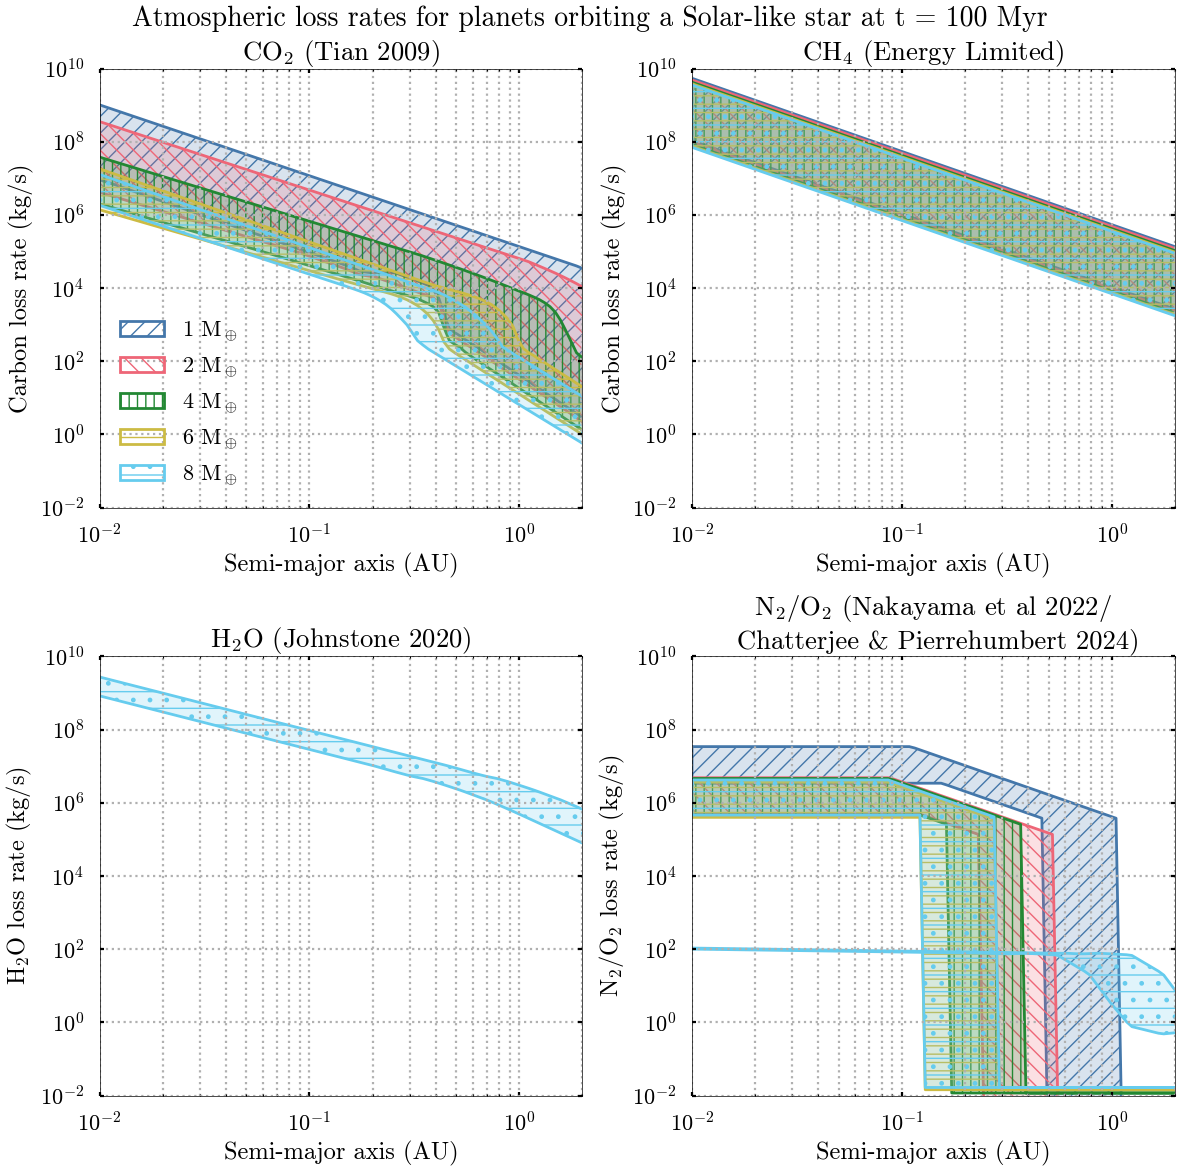

In [15]:
from matplotlib.patches import Patch

fig, axes = plt.subplots(2,2,figsize=(12,12))

hatches = ['//','\\\\','||','--','-.']

planet_masses = [1, 2, 4, 6, 8]

for n, pl_masse in enumerate(planet_masses):
    axes[0,0].fill_between(semi_major_axes, CO2_lower_total_plot[n], CO2_upper_total_plot[n],
                            facecolor = 'C%d' % n, alpha = 0.2)
    axes[0,0].fill_between(semi_major_axes, CO2_lower_total_plot[n], CO2_upper_total_plot[n],
                            facecolor = 'none', edgecolor = 'C%d' % n, 
                            lw= 2, hatch = hatches[n], label = '%d M$_\oplus$' % pl_masse)
    axes[0,1].fill_between(semi_major_axes, CH4_lower_total_plot[n], CH4_upper_total_plot[n],
                            facecolor = 'C%d' % n, alpha = 0.2)
    axes[0,1].fill_between(semi_major_axes, CH4_lower_total_plot[n], CH4_upper_total_plot[n],
                            facecolor = 'none', edgecolor = 'C%d' % n, 
                            lw= 2, hatch = hatches[n], label = '%d M$_\oplus$' % pl_masse)
    axes[1,1].fill_between(semi_major_axes, N2O2_lower_CR24_total_plot[n], N2O2_upper_CR24_total_plot[n],
                            facecolor = 'C%d' % n, alpha = 0.2)
    axes[1,1].fill_between(semi_major_axes, N2O2_lower_CR24_total_plot[n], N2O2_upper_CR24_total_plot[n],
                            facecolor = 'none', edgecolor = 'C%d' % n, 
                            lw= 2, hatch = hatches[n], label = '%d M$_\oplus$' % pl_masse)
    
axes[1,0].fill_between(semi_major_axes, H2O_lower_total_plot[0], H2O_upper_total_plot[0],
                            facecolor = 'C%d' % n, alpha = 0.2)
axes[1,0].fill_between(semi_major_axes, H2O_lower_total_plot[0], H2O_upper_total_plot[0],
                            facecolor = 'none', edgecolor = 'C%d' % n, 
                            lw= 2, hatch = hatches[n], label = '%d M$_\oplus$' % pl_masse)

axes[1,1].fill_between(semi_major_axes, N2O2_lower_total_plot[0], N2O2_upper_total_plot[0],
                            facecolor = 'C%d' % n, alpha = 0.2)
axes[1,1].fill_between(semi_major_axes, N2O2_lower_total_plot[0], N2O2_upper_total_plot[0],   
                            facecolor = 'none', edgecolor = 'C%d' % n, 
                            lw= 2, hatch = hatches[n], label = '%d M$_\oplus$' % pl_masse)
# Set the axis scales and labels
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(1e-2,1e10)


axes[0,0].legend(loc='lower left')
axes[0,0].set_ylabel('Carbon loss rate (kg/s)')
axes[0,0].set_title('CO$_2$ (Tian 2009)')

axes[0,1].set_ylabel('Carbon loss rate (kg/s)')
axes[0,1].set_title('CH$_4$ (Energy Limited)')

# axes[2,0].set_ylabel('Carbon loss rate (kg/s)')
# axes[2,0].set_title('CO$_2$ (Nonthermal)')

axes[1,0].set_ylabel('H$_2$O loss rate (kg/s)')
axes[1,0].set_title('H$_2$O (Johnstone 2020)')

axes[1,1].set_ylabel('N$_2$/O$_2$ loss rate (kg/s)')
axes[1,1].set_title('N$_2$/O$_2$ (Nakayama et al 2022/ \n Chatterjee & Pierrehumbert 2024)')

# axes[2,1].remove()


fig.suptitle('Atmospheric loss rates for planets orbiting a Solar-like star at t = 100 Myr', fontsize=20)

plt.tight_layout()
fig.savefig('./figures/Atmospheric_Loss_Rates.pdf',bbox_inches='tight')

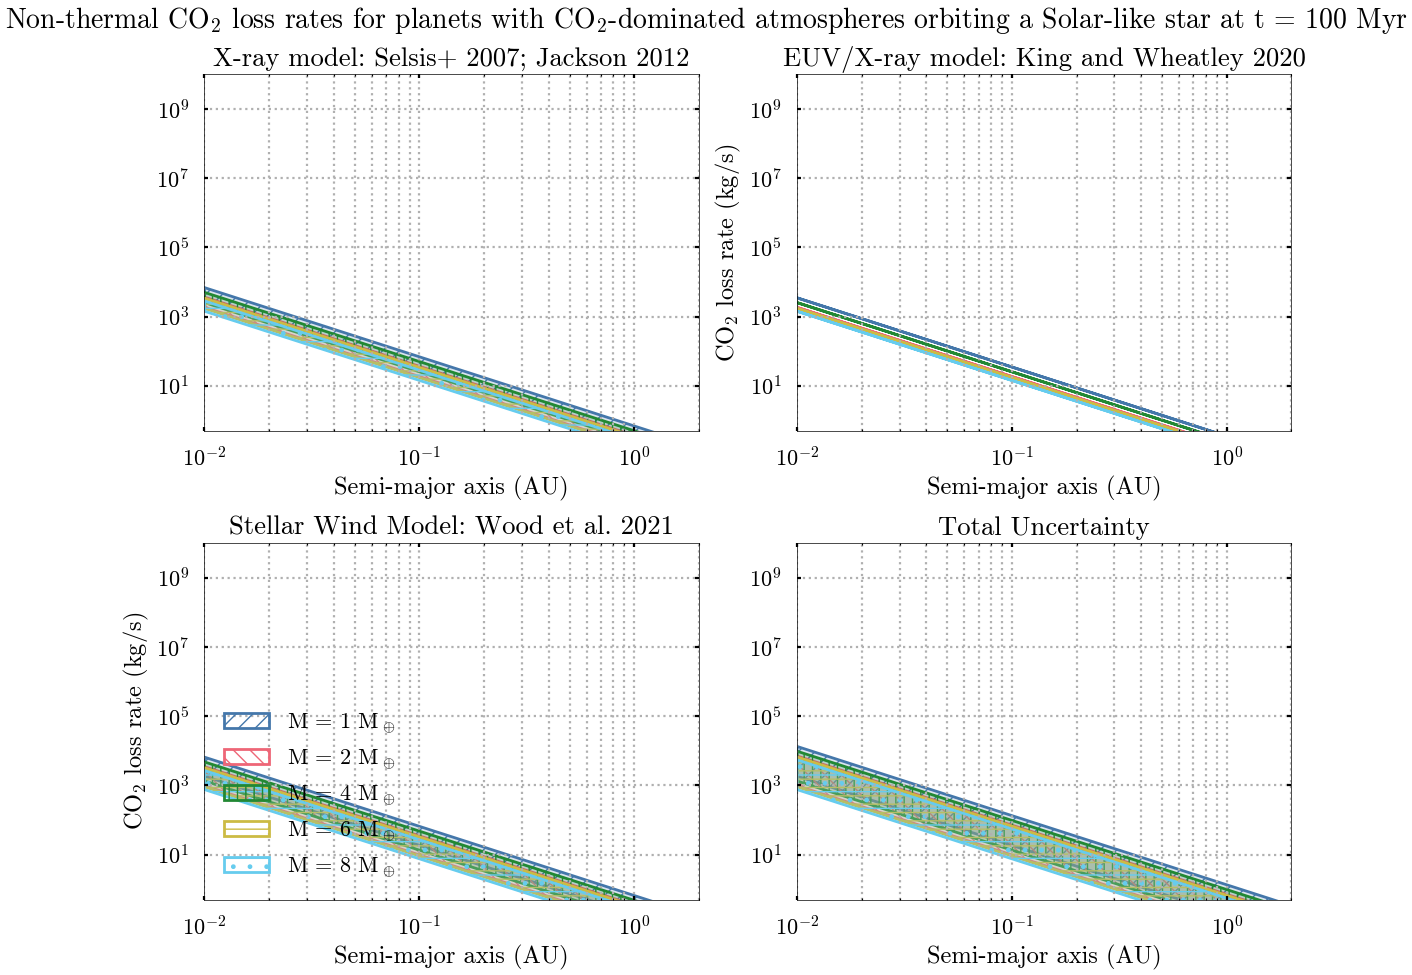

In [16]:
# Verify the atmospheric loss model

# Initialize CosmicShoreline instance
cs = CosmicShoreline()


stellar_masses = [0.1, 0.3, 1.0]
planet_masses = [1,2,4,6,8]  # Earth mass and pl_masse = 6
semi_major_axes = np.logspace(-2,0.5,100)



# Plot the results
fig, axes = plt.subplots(2,2,figsize=(12,10))

htaches = ['//','\\\\','||','--','-.']

CO2_nonthermal_upper = np.zeros((len(planet_masses),len(semi_major_axes)))
CO2_nonthermal_lower = np.zeros((len(planet_masses),len(semi_major_axes)))

for n, pl_masse in enumerate(planet_masses):
    L_XUV_S, L_X_S, L_EUV1_S, L_EUV2_S, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output='multi-band')
    L_XUV_J, L_X_J, L_EUV1_J, L_EUV2_J, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output='multi-band')


    CO2_loss_rates_upper_Xray = np.zeros(len(semi_major_axes))
    CO2_loss_rates_lower_Xray = np.zeros(len(semi_major_axes))

    for n2,pl_orbsmax in enumerate(semi_major_axes):
        # Calculate the total carbon loss for each planet mass and stellar
        F_xuv_to_earth_S = (cs._calculate_F_xuv_to_earth(L_XUV_S,pl_orbsmax))
        F_x_S = cs._calculate_F_xuv_to_earth(L_X_S,pl_orbsmax)*0.00464
        

        F_xuv_to_earth_J = (cs._calculate_F_xuv_to_earth(L_XUV_J,pl_orbsmax))
        F_x_J = cs._calculate_F_xuv_to_earth(L_X_J,pl_orbsmax)*0.00464

        CO2_S = cs.M_C_dot_non_thermal(L_X_S, Rs_S, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77)
        CO2_J = cs.M_C_dot_non_thermal(L_X_J, Rs_J, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77)

        CO2_loss_rates_upper_Xray[n2] = np.maximum(CO2_S, CO2_J)
        CO2_loss_rates_lower_Xray[n2] = np.minimum(CO2_S, CO2_J)
    
    axes[0,0].fill_between(semi_major_axes, CO2_loss_rates_lower_Xray, CO2_loss_rates_upper_Xray,
                            alpha=0.2,facecolor='C%d'%n)
    axes[0,0].fill_between(semi_major_axes, CO2_loss_rates_lower_Xray, CO2_loss_rates_upper_Xray,
                            facecolor='none', edgecolor='C%d'%n, lw=2,hatch=htaches[n],label='M = %d M$_\oplus$'%pl_masse)
    
    L_xuv_K20_1, L_x_K20_1, L_euv1_K20_1, L_euv2_K20_1, Rs = cs.calculate_L_XUV(1,1e8,output='multi-band',
                                                                            gamma1 = -0.35+0.07,gamma2=-0.76+0.16)
    L_xuv_K20_2, L_x_K20_2, L_euv1_K20_2, L_euv2_K20_2, Rs = cs.calculate_L_XUV(1,1e8,output='multi-band',
                                                                            gamma1 = -0.35-0.15,gamma2=-0.76-0.04)
    CO2_loss_rates_upper_EUV = np.zeros(len(semi_major_axes))
    CO2_loss_rates_lower_EUV = np.zeros(len(semi_major_axes))

    for n2,pl_orbsmax in enumerate(semi_major_axes):
        # Calculate the total carbon loss for each planet mass and stellar
        F_xuv_to_earth_1 = (cs._calculate_F_xuv_to_earth(L_xuv_K20_1,pl_orbsmax))
        F_x_1 = cs._calculate_F_xuv_to_earth(L_x_K20_1,pl_orbsmax)*0.00464

        F_xuv_to_earth_2 = (cs._calculate_F_xuv_to_earth(L_xuv_K20_2,pl_orbsmax))
        F_x_2 = cs._calculate_F_xuv_to_earth(L_x_K20_2,pl_orbsmax)*0.00464

        CO2_1 = cs.M_C_dot_non_thermal(L_x_K20_1, Rs, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77)
        CO2_2 = cs.M_C_dot_non_thermal(L_x_K20_2, Rs, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77)

        CO2_loss_rates_upper_EUV[n2] = np.maximum(CO2_1, CO2_2)
        CO2_loss_rates_lower_EUV[n2] = np.minimum(CO2_1, CO2_2)
    
    axes[0,1].fill_between(semi_major_axes, CO2_loss_rates_lower_EUV, CO2_loss_rates_upper_EUV,
                            alpha=0.2,facecolor='C%d'%n)
    axes[0,1].fill_between(semi_major_axes, CO2_loss_rates_lower_EUV, CO2_loss_rates_upper_EUV,
                            facecolor='none', edgecolor='C%d'%n, lw=2,hatch=htaches[n],label='M = %d M$_\oplus$'%pl_masse)
    
    CO2_M_dot_non_thermal_upper = np.zeros(len(semi_major_axes))
    CO2_M_dot_non_thermal_lower = np.zeros(len(semi_major_axes))

    L_XUV, L_X, L_EUV1, L_EUV2, Rs = cs.calculate_L_XUV(1, 1e8, method='Jackson', output='multi-band')
    for n2,pl_orbsmax in enumerate(semi_major_axes):
        # Calculate the total carbon loss for each planet mass and stellar
        F_xuv_to_earth = (cs._calculate_F_xuv_to_earth(L_XUV,pl_orbsmax))
        F_x = cs._calculate_F_xuv_to_earth(L_X,pl_orbsmax)*0.00464

        CO2_M_dot_m = cs.M_C_dot_non_thermal(L_X, Rs, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77-0.04)
        CO2_M_dot_p = cs.M_C_dot_non_thermal(L_X, Rs, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77+0.04)

        CO2_M_dot_non_thermal_upper[n2] = np.maximum(CO2_M_dot_m, CO2_M_dot_p)
        CO2_M_dot_non_thermal_lower[n2] = np.minimum(CO2_M_dot_m, CO2_M_dot_p)

    axes[1,0].fill_between(semi_major_axes, CO2_M_dot_non_thermal_lower, CO2_M_dot_non_thermal_upper,
                            alpha=0.2,facecolor='C%d'%n)
    axes[1,0].fill_between(semi_major_axes, CO2_M_dot_non_thermal_lower, CO2_M_dot_non_thermal_upper,
                            facecolor='none', edgecolor='C%d'%n, lw=2,hatch=htaches[n],label='M = %d M$_\oplus$'%pl_masse)
    
    CO2_M_dot_non_thermal_upper = np.zeros(len(semi_major_axes))
    CO2_M_dot_non_thermal_lower = np.zeros(len(semi_major_axes))

    L_XUV_S_1, L_X_S_1, L_EUV1_S_1, L_EUV2_S_1, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output='multi-band',
                                                                            gamma1 = -0.35+0.07,gamma2=-0.76+0.16)
    L_XUV_S_2, L_X_S_2, L_EUV1_S_2, L_EUV2_S_2, Rs_S = cs.calculate_L_XUV(1, 1e8, method='Selsis', output='multi-band',
                                                                            gamma1 = -0.35-0.15,gamma2=-0.76-0.04)
    L_XUV_J_1, L_X_J_1, L_EUV1_J_1, L_EUV2_J_1, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output='multi-band',
                                                                            gamma1 = -0.35+0.07,gamma2=-0.76+0.16)
    L_XUV_J_2, L_X_J_2, L_EUV1_J_2, L_EUV2_J_2, Rs_J = cs.calculate_L_XUV(1, 1e8, method='Jackson', output='multi-band',
                                                                            gamma1 = -0.35-0.15,gamma2=-0.76-0.04)
    
    for n2,pl_orbsmax in enumerate(semi_major_axes):
        CO2_M_dot_m_S_1 = cs.M_C_dot_non_thermal(L_X_S_1, Rs_S, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77-0.04)
        CO2_M_dot_p_S_1 = cs.M_C_dot_non_thermal(L_X_S_1, Rs_S, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77+0.04)
        CO2_M_dot_m_S_2 = cs.M_C_dot_non_thermal(L_X_S_2, Rs_S, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77-0.04)
        CO2_M_dot_p_S_2 = cs.M_C_dot_non_thermal(L_X_S_2, Rs_S, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77+0.04)
        CO2_M_dot_m_J_1 = cs.M_C_dot_non_thermal(L_X_J_1, Rs_J, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77-0.04)
        CO2_M_dot_p_J_1 = cs.M_C_dot_non_thermal(L_X_J_1, Rs_J, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77+0.04)
        CO2_M_dot_m_J_2 = cs.M_C_dot_non_thermal(L_X_J_2, Rs_J, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77-0.04)
        CO2_M_dot_p_J_2 = cs.M_C_dot_non_thermal(L_X_J_2, Rs_J, cs.M_R_interpolator_Earth_xM(pl_masse), pl_orbsmax, 0.77+0.04)

        CO2_arr = [CO2_M_dot_m_S_1,CO2_M_dot_p_S_1,CO2_M_dot_m_S_2,CO2_M_dot_p_S_2,
                     CO2_M_dot_m_J_1,CO2_M_dot_p_J_1,CO2_M_dot_m_J_2,CO2_M_dot_p_J_2]
        
        CO2_M_dot_non_thermal_upper[n2] = np.max(CO2_arr)
        CO2_M_dot_non_thermal_lower[n2] = np.min(CO2_arr)

    axes[1,1].fill_between(semi_major_axes, CO2_M_dot_non_thermal_lower, CO2_M_dot_non_thermal_upper,
                            alpha=0.2,facecolor='C%d'%n)
    axes[1,1].fill_between(semi_major_axes, CO2_M_dot_non_thermal_lower, CO2_M_dot_non_thermal_upper,
                            facecolor='none', edgecolor='C%d'%n, lw=2,hatch=htaches[n],label='M = %d M$_\oplus$'%pl_masse)
    
    CO2_nonthermal_upper[n] = CO2_M_dot_non_thermal_upper
    CO2_nonthermal_lower[n] = CO2_M_dot_non_thermal_lower



for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log') 
    ax.set_xlabel('Semi-major axis (AU)')
    ax.grid(True,which="both",ls=":")
    ax.set_xlim(1e-2,2)
    ax.set_ylim(5e-1,1e10)

axes[1,0].set_ylabel('CO$_2$ loss rate (kg/s)')
axes[1,0].set_title('Stellar Wind Model: Wood et al. 2021')
axes[1,0].legend(loc='lower left')

axes[0,0].set_title('X-ray model: Selsis+ 2007; Jackson 2012')

axes[0,1].set_ylabel('CO$_2$ loss rate (kg/s)')
axes[0,1].set_title('EUV/X-ray model: King and Wheatley 2020')

axes[1,1].set_title('Total Uncertainty')

fig.suptitle('Non-thermal CO$_2$ loss rates for planets with CO$_2$-dominated atmospheres orbiting a Solar-like star at t = 100 Myr', fontsize=20)
fig.savefig('./figures/atmospheric_loss_rates_unc_CO2_nonthermal.pdf',bbox_inches='tight')

plt.tight_layout()


# 2. Cosmic shoreline given by Monte Carlo

In [17]:
from statsmodels.base.model import GenericLikelihoodModel

class ThreeParamLogit(GenericLikelihoodModel):
    """
    A custom three-parameter logistic regression model with p_max reparameterized:
    
        p(x) = logistic(theta) / (1 + exp(-(beta0 + beta1 * x)))
    
    Parameters:
        beta0 : intercept
        beta1 : slope
        theta : unconstrained parameter such that p_max = logistic(theta) is in (0, 1)
    """
    def nloglikeobs(self, params):
        # Extract parameters: beta0, beta1 and theta
        beta = params[:2]
        theta = params[2]
        
        # Constrain p_max to (0, 1) using the logistic function
        p_max = 1 / (1 + np.exp(-theta))
        # p_max = theta
        
        # Linear predictor (assumes a constant is included in exog)
        eta = np.dot(self.exog, beta)
        
        # Predicted probability with the extra parameter p_max
        pi = p_max / (1 + np.exp(-eta))
        
        # Avoid log(0) by clipping probabilities
        eps = 1e-9
        pi = np.clip(pi, eps, 1 - eps)
        
        # Compute the log-likelihood for each observation
        ll = self.endog * np.log(pi) + (1 - self.endog) * np.log(1 - pi)
        return -ll  # negative log-likelihood
    
    def fit(self, start_params=None, **kwds):
        if start_params is None:
            # Start with beta0=0, beta1=0, and theta=0 (implying p_max = logistic(0) = 0.5)
            start_params = np.array([0, 0, 0])
        return super(ThreeParamLogit, self).fit(start_params=start_params, **kwds)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


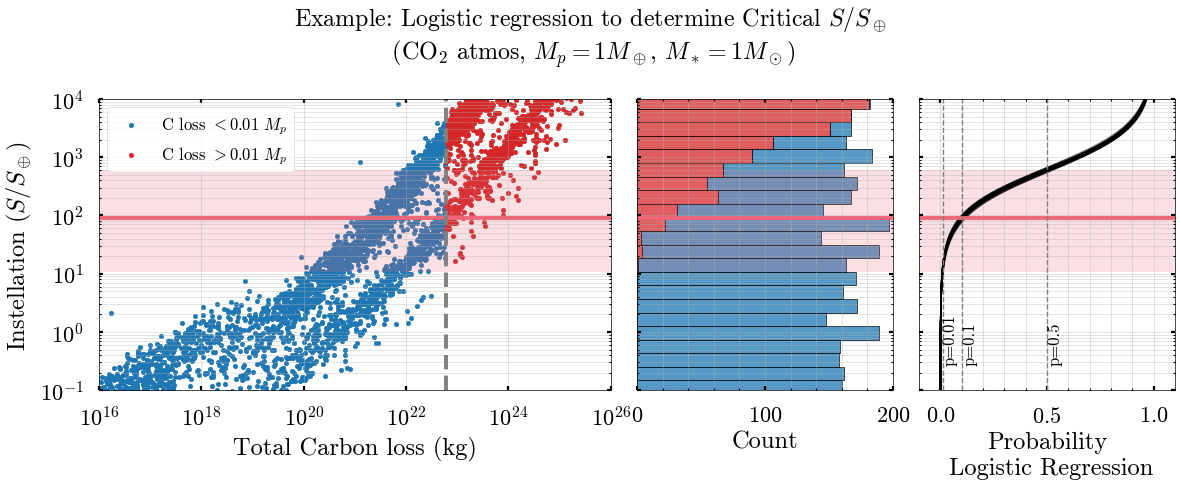

In [18]:
df_CO2_1Ms = pd.read_csv('./data-montecarlo/df_st_mass_1.0_MMW_44.csv')

fig,axes = plt.subplots(1,3,figsize=(12,5),width_ratios=[2,1,1],sharey=True)

N_rep = 50
pl_masse = 1
earth_mass = 5.972e24
m0_atm = 1e-2*pl_masse*earth_mass

d_c_logit_001 = np.zeros(N_rep)
d_c_logit_01 = np.zeros(N_rep)
d_c_logit_05 = np.zeros(N_rep)

for n_sam in range(N_rep):
    pvalues = np.nan
    while np.isnan(pvalues) or pvalues>0.5:
        df = df_CO2_1Ms.sample(5000, replace=False)
        df['log_pl_insol'] = np.log10(df['pl_insol'])
        if np.max(df['C_loss'])<m0_atm:
            d_c_logit_001[n_sam] = 5
            d_c_logit_01[n_sam] = 5
            d_c_logit_05[n_sam] = 5
            pvalues = 0
        elif np.min(df['C_loss'])>m0_atm:
            d_c_logit_001[n_sam] = -2
            d_c_logit_01[n_sam] = -2
            d_c_logit_05[n_sam] = -2
            pvalues = 0
        else:
            Y = (df['C_loss']>m0_atm).astype(int)
            X = sm.add_constant(df['log_pl_insol'])  # adds an 'intercept' column

            logit_model = sm.Logit(Y, X)
            logit_result = logit_model.fit(disp=False)
            pvalues = logit_result.pvalues['log_pl_insol']

            alpha_hat = logit_result.params['const']
            beta_hat = logit_result.params['log_pl_insol']
            p_max =1

            p0_001 = 0.01
            logit_p0_001 = np.log(p0_001 / (p_max - p0_001))
            d_c_logit_001[n_sam] = (logit_p0_001 - alpha_hat) / beta_hat

            p0_01 = 0.1
            logit_p0_01 = np.log(p0_01 / (p_max - p0_01))
            d_c_logit_01[n_sam] = (logit_p0_01 - alpha_hat) / beta_hat

            p0_05 = 0.5
            logit_p0_05 = np.log(p0_05 / (p_max - p0_05))
            d_c_logit_05[n_sam] = (logit_p0_05 - alpha_hat) / beta_hat
    xx = np.linspace(-2, 5, 100)
    yy = p_max / (1 + np.exp(-(alpha_hat + beta_hat * xx)))
    axes[2].plot(yy,10**xx, color='k', lw=1, alpha=0.5)
    axes[2].set_yscale('log')


axes[0].scatter(df['C_loss'][df['C_loss']<m0_atm],df['pl_insol'][df['C_loss']<m0_atm],s=10,c='tab:blue')
axes[0].scatter(df['C_loss'][df['C_loss']>m0_atm],df['pl_insol'][df['C_loss']>m0_atm],s=10,c='tab:red')

axes[0].axhline(10**d_c_logit_01.mean(), color='C1')
axes[0].fill_between([1e14,1e28],10**d_c_logit_001.mean(),
                        10**d_c_logit_05.mean(),alpha=0.2,color='C1')
axes[0].set_xscale('log')
axes[0].set_yscale('log')


axes[0].legend(['C loss $< 0.01~M_p$','C loss $> 0.01~M_p$'],
               loc='upper left', frameon=True,fontsize=12)
axes[0].set_xlim(1e16,1e26)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Total Carbon loss (kg)')
axes[0].set_ylabel('Instellation ($S/S_\oplus$)')

df['hue'] = (df['C_loss']>m0_atm).astype(int)
sns.histplot( data = df, y='pl_insol',log_scale=True, ax = axes[1],  
             multiple="stack",hue='hue',palette=['tab:blue','tab:red'],bins=30)
axes[1].legend()
axes[1].axhline(10**d_c_logit_01.mean(), color='C1')
axes[1].fill_between([0,200],10**d_c_logit_001.mean(),
                        10**d_c_logit_05.mean(),alpha=0.2,color='C1')
axes[1].set_xlim(0,200)

axes[2].axhline(10**d_c_logit_01.mean(), color='C1')
axes[2].fill_between([-0.1,1.1],10**d_c_logit_001.mean(),
                        10**d_c_logit_05.mean(),alpha=0.2,color='C1')
axes[2].set_xlim(-0.1,1.1)
axes[2].set_xlabel('Probability\n Logistic Regression')
fig.suptitle('Example: Logistic regression to determine Critical $S/S_\oplus$\n (CO$_2$ atmos, $M_p = 1M_\oplus$, $M_* = 1 M_\odot$)'
             , fontsize='xx-large')

axes[0].set_ylim(1e-1,1e4)
axes[0].axvline(m0_atm, color='gray', ls='--')
axes[2].axvline(0.01, color='gray', ls='--',lw=1)
axes[2].axvline(0.5, color='gray', ls='--',lw=1)
axes[2].axvline(0.1, color='gray', ls='--',lw=1)
axes[2].text(0.01,3e-1,'p=0.01',fontsize=12,rotation=90)
axes[2].text(0.5,3e-1,'p=0.5',fontsize=12,rotation=90)
axes[2].text(0.1,3e-1,'p=0.1',fontsize=12,rotation=90)
for ax in axes:
    ax.minorticks_on()
    ax.grid(True,which="both",ls="-",lw=0.5,alpha=0.5)



plt.tight_layout(w_pad=0)

fig.savefig('./figures/logistic_regression_example_CO2_1Ms_1Me.pdf',bbox_inches='tight')




/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")
/home/xuanji/ipykernel_2212327/3595501940.py:54: RuntimeWarning: invalid value encountered in log
  logit_p0_05 = np.log(p0_05 / (p_max - p0_05))
/home/xuanji/ipykernel_2212327/113000724.py:27: RuntimeWarning: overflow encountered in exp
  pi = p_max / (1 + np.exp(-eta))
/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-p

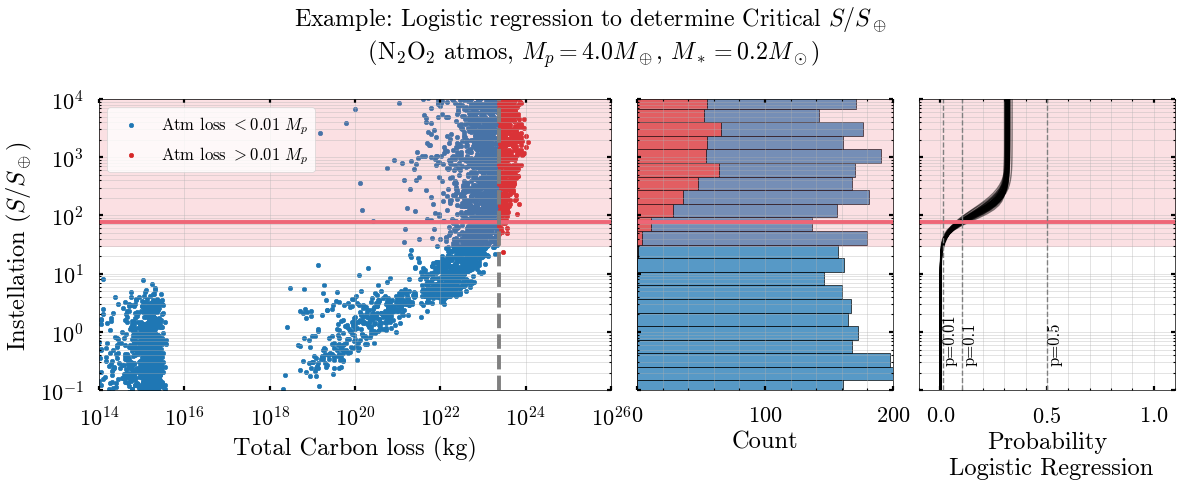

In [19]:
st_mass = 0.2
pl_masse = 4

df_CO2_1Ms = pd.read_csv('./data-montecarlo/df_pl_mass_%.1f_st_mass_%.2f_MMW_%d_CR24.csv'%(pl_masse, st_mass, 28))

fig,axes = plt.subplots(1,3,figsize=(12,5),width_ratios=[2,1,1],sharey=True)

N_rep = 50
earth_mass = 5.972e24
m0_atm = 1e-2*pl_masse*earth_mass

d_c_logit_001 = np.zeros(N_rep)
d_c_logit_01 = np.zeros(N_rep)
d_c_logit_05 = np.zeros(N_rep)

for n_sam in range(N_rep):
    pvalues = np.nan
    while np.isnan(pvalues) or pvalues>0.1:
        # print(n_sam)
        df = df_CO2_1Ms.sample(5000, replace=False)
        df['log_pl_insol'] = np.log10(df['pl_insol'])
        if np.max(df['C_loss'])<m0_atm:
            d_c_logit_001[n_sam] = 5
            d_c_logit_01[n_sam] = 5
            d_c_logit_05[n_sam] = 5
            pvalues = 0
        elif np.min(df['C_loss'])>m0_atm:
            d_c_logit_001[n_sam] = -2
            d_c_logit_01[n_sam] = -2
            d_c_logit_05[n_sam] = -2
            pvalues = 0
        else:
            Y = (df['C_loss']>m0_atm).astype(int)
            X = sm.add_constant(df['log_pl_insol'])  # adds an 'intercept' column

            logit_model = ThreeParamLogit(Y, X)
            logit_result = logit_model.fit(disp=False,maxiter=5000)  # disp=False to suppress output
            pvalues = logit_result.pvalues[1]

            alpha_hat = logit_result.params[0]
            beta_hat = logit_result.params[1]
            theta = logit_result.params[2]
            p_max = 1 / (1 + np.exp(-theta))  # p_max from the logistic function

            p0_001 = 0.01
            logit_p0_001 = np.log(p0_001 / (p_max - p0_001))
            d_c_logit_001[n_sam] = (logit_p0_001 - alpha_hat) / beta_hat

            p0_01 = 0.1
            logit_p0_01 = np.log(p0_01 / (p_max - p0_01))
            d_c_logit_01[n_sam] = (logit_p0_01 - alpha_hat) / beta_hat

            p0_05 = 0.5
            logit_p0_05 = np.log(p0_05 / (p_max - p0_05))
            d_c_logit_05[n_sam] = (logit_p0_05 - alpha_hat) / beta_hat
            if p_max < 0.5:
                d_c_logit_05[n_sam] = 5
    xx = np.linspace(-2, 5, 100)
    yy = p_max / (1 + np.exp(-(alpha_hat + beta_hat * xx)))
    axes[2].plot(yy,10**xx, color='k', lw=1, alpha=0.5)
    axes[2].set_yscale('log')

axes[0].scatter(df['C_loss'][df['C_loss']<m0_atm],df['pl_insol'][df['C_loss']<m0_atm],s=10,c='tab:blue')
axes[0].scatter(df['C_loss'][df['C_loss']>m0_atm],df['pl_insol'][df['C_loss']>m0_atm],s=10,c='tab:red')

axes[0].axhline(10**np.nanmean(d_c_logit_01), color='C1')
axes[0].fill_between([1e14,1e28],10**np.nanmean(d_c_logit_001),
                        10**np.nanmean(d_c_logit_05),alpha=0.2,color='C1')

axes[0].set_xscale('log')
axes[0].set_yscale('log')


axes[0].legend(['Atm loss $< 0.01~M_p$','Atm loss $> 0.01~M_p$'],
               loc='upper left', frameon=True,fontsize=12)
axes[0].set_xlim(1e14,1e26)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Total Carbon loss (kg)')
axes[0].set_ylabel('Instellation ($S/S_\oplus$)')

df['hue'] = (df['C_loss']>m0_atm).astype(int)
sns.histplot( data = df, y='pl_insol',log_scale=True, 
             ax = axes[1],  multiple="stack",hue='hue',palette=['tab:blue','tab:red'],bins=30)
axes[1].legend()
axes[1].axhline(10**np.nanmean(d_c_logit_01), color='C1')
axes[1].fill_between([0,200],10**np.nanmean(d_c_logit_001),
                        10**np.nanmean(d_c_logit_05),alpha=0.2,color='C1')
axes[1].set_xlim(0,200)

axes[2].axhline(10**np.nanmean(d_c_logit_01), color='C1')
axes[2].fill_between([-0.1,1.1],10**np.nanmean(d_c_logit_001),
                        10**np.nanmean(d_c_logit_05),alpha=0.2,color='C1')
axes[2].set_xlim(-0.1,1.1)
axes[2].grid(True,which="both",ls="-",lw=0.5,alpha=0.5)
axes[2].set_xlabel('Probability\n Logistic Regression')
fig.suptitle('Example: Logistic regression to determine Critical $S/S_\oplus$\n (N$_2$O$_2$ atmos, $M_p = %.1fM_\oplus$, $M_* = %.1f M_\odot$)'%(pl_masse,st_mass),
              fontsize='xx-large')


axes[0].set_ylim(1e-1,1e4)
axes[0].axvline(m0_atm, color='gray', ls='--')
axes[2].axvline(0.01, color='gray', ls='--',lw=1)
axes[2].axvline(0.5, color='gray', ls='--',lw=1)
axes[2].axvline(0.1, color='gray', ls='--',lw=1)
axes[2].text(0.01,3e-1,'p=0.01',fontsize=12,rotation=90)
axes[2].text(0.5,3e-1,'p=0.5',fontsize=12,rotation=90)
axes[2].text(0.1,3e-1,'p=0.1',fontsize=12,rotation=90)
for ax in axes:
    ax.minorticks_on()
    ax.grid(True,which="both",ls="-",lw=0.5,alpha=0.5)


plt.tight_layout(w_pad=0)

fig.savefig('./figures/logistic_regression_example_N2O2_02Ms_4Me.pdf',bbox_inches='tight')


/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")
/home/xuanji/ipykernel_2212327/3836922261.py:54: RuntimeWarning: invalid value encountered in log
  logit_p0_01 = np.log(p0_01 / (p_max - p0_01))
/home/xuanji/ipykernel_2212327/3836922261.py:58: RuntimeWarning: invalid value encountered in log
  logit_p0_05 = np.log(p0_05 / (p_max - p0_05))
/home/xuanji/ipykernel_2212327/113000724.py:27: RuntimeWarning: overflow encountered in exp
  pi = p_max / (1 + np.exp(-eta))
/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k

/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/software/python-anaconda-2023.09-el8-x86_64/lib/python3.11/site-packages/statsmodels/base/model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")
/home/xuanji/ipykernel_2212327/3836922261.py:54: RuntimeWarning: invalid value encountered in log
  logit_p0_01 = np.log(p0_01 / (p_max - p0_01))
/home/xuanji/ipykernel_2212327/3836922261.py:58: RuntimeWarning: invalid value encountered in log
  logit_p0_05 = np.log(p0_05 / (p_max - p0_05))
/home/xuanji/ipykernel_2212327/3836922261.py:67: RuntimeWarning: Mean of empty slice
  axes[0].axhline(10**np.nanmean(d_c_logit_01), color='C1')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legen

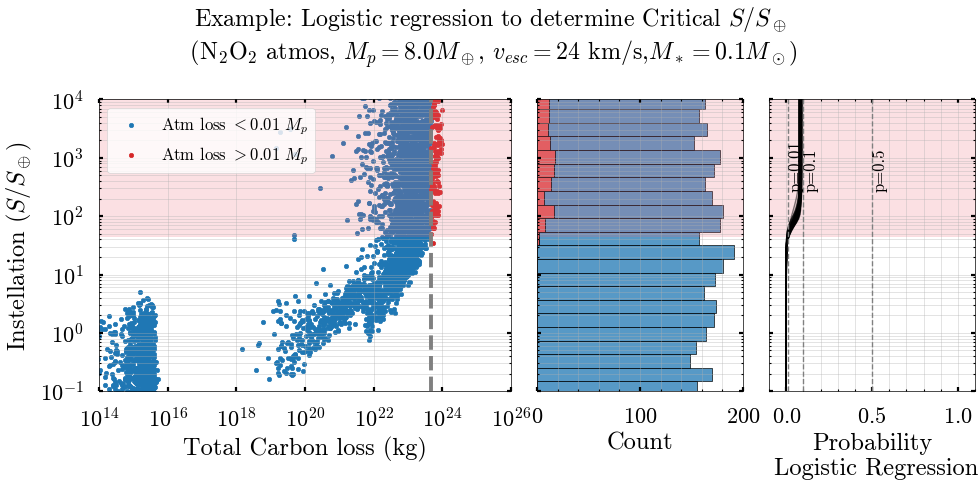

In [20]:
st_mass = 0.1
pl_masse = 8

df_CO2_1Ms = pd.read_csv('./data-montecarlo/df_pl_mass_%.1f_st_mass_%.2f_MMW_%d_CR24.csv'%(pl_masse, st_mass, 28))

fig,axes = plt.subplots(1,3,figsize=(10,5),width_ratios=[2,1,1],sharey=True)

N_rep = 50
earth_mass = 5.972e24
m0_atm = 1e-2*pl_masse*earth_mass

d_c_logit_001 = np.zeros(N_rep)
d_c_logit_01 = np.zeros(N_rep)
d_c_logit_05 = np.zeros(N_rep)

for n_sam in range(N_rep):
    pvalues = np.nan
    while np.isnan(pvalues) or pvalues>0.1:
        df = df_CO2_1Ms.sample(5000, replace=False)
        df['log_pl_insol'] = np.log10(df['pl_insol'])
        if np.max(df['C_loss'])<m0_atm:
            d_c_logit_001[n_sam] = 5
            d_c_logit_01[n_sam] = 5
            d_c_logit_05[n_sam] = 5
            pvalues = 0
        elif np.min(df['C_loss'])>m0_atm:
            d_c_logit_001[n_sam] = -2
            d_c_logit_01[n_sam] = -2
            d_c_logit_05[n_sam] = -2
            pvalues = 0
        else:
            Y = (df['C_loss']>m0_atm).astype(int)
            X = sm.add_constant(df['log_pl_insol'])  # adds an 'intercept' column

            logit_model = ThreeParamLogit(Y, X)
            logit_result = logit_model.fit(disp=False,maxiter=5000)  # disp=False to suppress output
            pvalues = logit_result.pvalues[1]

        alpha_hat = logit_result.params[0]
        beta_hat = logit_result.params[1]
        theta = logit_result.params[2]
        p_max = 1 / (1 + np.exp(-theta))  # p_max from the logistic function

    xx = np.linspace(-2, 5, 100)
    yy = p_max / (1 + np.exp(-(alpha_hat + beta_hat * xx)))
    axes[2].plot(yy,10**xx, color='k', lw=1, alpha=0.5)
    axes[2].set_yscale('log')

    p0_001 = 0.01
    logit_p0_001 = np.log(p0_001 / (p_max - p0_001))
    d_c_logit_001[n_sam] = (logit_p0_001 - alpha_hat) / beta_hat

    p0_01 = 0.1
    logit_p0_01 = np.log(p0_01 / (p_max - p0_01))
    d_c_logit_01[n_sam] = (logit_p0_01 - alpha_hat) / beta_hat

    p0_05 = 0.5
    logit_p0_05 = np.log(p0_05 / (p_max - p0_05))
    d_c_logit_05[n_sam] = (logit_p0_05 - alpha_hat) / beta_hat
    if p_max < 0.5:
        d_c_logit_05[n_sam] = 5


axes[0].scatter(df['C_loss'][df['C_loss']<m0_atm],df['pl_insol'][df['C_loss']<m0_atm],s=10,c='tab:blue')
axes[0].scatter(df['C_loss'][df['C_loss']>m0_atm],df['pl_insol'][df['C_loss']>m0_atm],s=10,c='tab:red')

axes[0].axhline(10**np.nanmean(d_c_logit_01), color='C1')
axes[0].fill_between([1e14,1e28],10**np.nanmean(d_c_logit_001),
                        10**np.nanmean(d_c_logit_05),alpha=0.2,color='C1')

axes[0].set_xscale('log')
axes[0].set_yscale('log')


axes[0].legend(['Atm loss $< 0.01~M_p$','Atm loss $> 0.01~M_p$'],
               loc='upper left', frameon=True,fontsize=12)
axes[0].set_xlim(1e14,1e26)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Total Carbon loss (kg)')
axes[0].set_ylabel('Instellation ($S/S_\oplus$)')

df['hue'] = (df['C_loss']>m0_atm).astype(int)
sns.histplot( data = df, y='pl_insol',log_scale=True, ax = axes[1],  
             multiple="stack",hue='hue',palette=['tab:blue','tab:red'],bins=30)
axes[1].legend()
axes[1].axhline(10**np.nanmean(d_c_logit_01), color='C1')
axes[1].fill_between([0,200],10**np.nanmean(d_c_logit_001),
                        10**np.nanmean(d_c_logit_05),alpha=0.2,color='C1')
axes[1].set_xlim(0,200)

axes[2].axhline(10**np.nanmean(d_c_logit_01), color='C1')
axes[2].fill_between([-0.1,1.1],10**np.nanmean(d_c_logit_001),
                        10**np.nanmean(d_c_logit_05),alpha=0.2,color='C1')
axes[2].set_xlim(-0.1,1.1)
axes[2].grid(True,which="both",ls="-",lw=0.5,alpha=0.5)
axes[2].set_xlabel('Probability\n Logistic Regression')

pl_rade = cs.M_R_fit(pl_masse,x_M_or_R='M')
m_earth = 5.972e24
r_earth = 6.371e6
G=6.67430e-11
pl_v_esc = np.sqrt(2*G*pl_masse*m_earth/(pl_rade*r_earth))/1e3
fig.suptitle('Example: Logistic regression to determine Critical $S/S_\oplus$\n (N$_2$O$_2$ atmos, $M_p = %.1fM_\oplus$, $v_{esc}=%d$ km/s,$M_* = %.1f M_\odot$)'%(pl_masse,pl_v_esc,st_mass),
              fontsize='xx-large')

axes[0].set_ylim(1e-1,1e4)
axes[0].axvline(m0_atm, color='gray', ls='--')
axes[2].axvline(0.01, color='gray', ls='--',lw=1)
axes[2].axvline(0.5, color='gray', ls='--',lw=1)
axes[2].axvline(0.1, color='gray', ls='--',lw=1)
axes[2].text(0.01,3e2,'p=0.01',fontsize=12,rotation=90)
axes[2].text(0.5,3e2,'p=0.5',fontsize=12,rotation=90)
axes[2].text(0.1,3e2,'p=0.1',fontsize=12,rotation=90)
for ax in axes:
    ax.minorticks_on()
    ax.grid(True,which="both",ls="-",lw=0.5,alpha=0.5)


plt.tight_layout(w_pad=0)

fig.savefig('./figures/logistic_regression_example_N2O2_02Ms_1Me.pdf',bbox_inches='tight')


## 2.1 CosmicShoreline: Stellar Mass

In [31]:
CS_insol_001 = np.load('./data-montecarlo/CS_insol_001_st_vesc.npy')
CS_insol_01 = np.load('./data-montecarlo/CS_insol_01_st_vesc.npy')
CS_insol_05 = np.load('./data-montecarlo/CS_insol_05_st_vesc.npy')

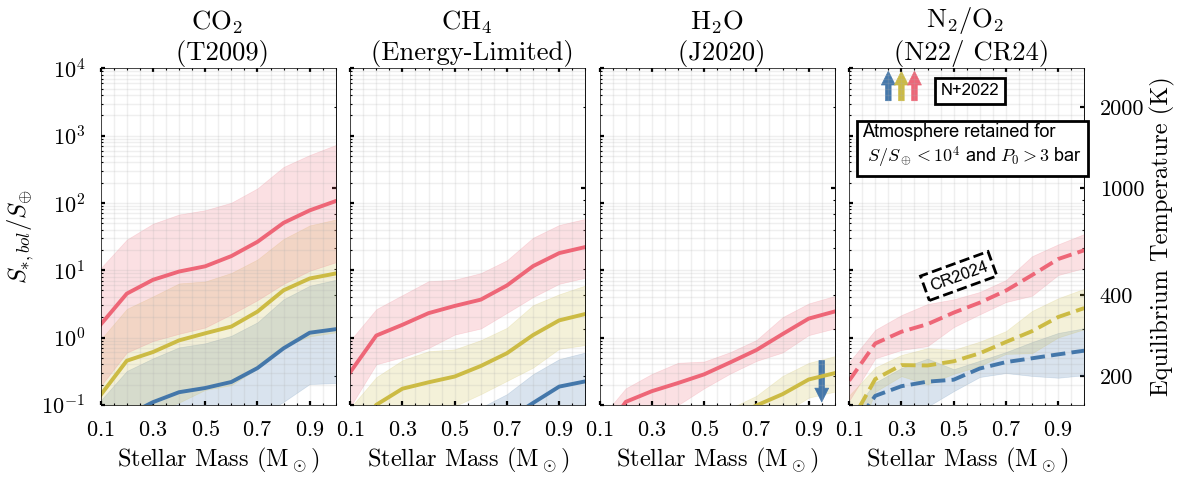

In [32]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches



fig, axes = plt.subplots(1,4,figsize=(12,5),sharex=True,sharey=True)
axes_arr = axes  
MMWs = [44, 16, 18, 28, 28]
stellar_masses = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colors = ['C0', 'C3', 'C1', 'gray']

earth_mass = 5.972e24
initial_atms = np.array([1e-4,1e-3,1e-2])*earth_mass


for n_atm,m0_atm in enumerate(initial_atms):
    for n_x, MMW in enumerate(MMWs):
        if MMW == 28:
            # if n_x != 4:
            #     if n_atm == 1:
            #         axes_arr[n_x].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color='C%d'%(n_atm+3))
            #         axes_arr[n_x].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
            #                                 color='C%d'%(n_atm+3),alpha=0.2)
            if n_x == 4:
                axes_arr[3].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color=colors[n_atm],ls='--')
                axes_arr[3].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
                                    color=colors[n_atm],alpha=0.2)
            else:
                axes_arr[n_x].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color=colors[n_atm])
                axes_arr[n_x].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
                                    color=colors[n_atm],alpha=0.2)
            
        else:
            axes_arr[n_x].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color=colors[n_atm])
            axes_arr[n_x].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
                                    color=colors[n_atm],alpha=0.2)


# Conversion functions
def S_to_Teq(S):
    """Convert insolation S to equilibrium temperature T_eq."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (S * 1361 / 4 / sigma) ** 0.25

def Teq_to_S(Teq):
    """Convert equilibrium temperature T_eq back to insolation S."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (Teq**4 * sigma) / (1361/4)

for n_ax,ax in enumerate(axes_arr):
    ax.set_yscale('log')
    ax.set_xlabel('Stellar Mass (M$_\odot$)')
    ax.set_ylim(0.1,10000)
    ax.set_xlim(0.1,1)
    ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
    ax.grid(True,which="both",ls="-",alpha=0.2,lw=1)
    ax.tick_params(axis='y',which='both', right=False)
    ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
    if n_ax<3:
        ax2.tick_params(axis='y',which='both',labelright=False)
    else:
        ax2.set_ylabel('Equilibrium Temperature (K)')
        ax2.set_yticks([200,400,1000,2000])
        ax2.set_yticklabels([200,400,1000,2000])
        # ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        # ax2.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        # ax2.yaxis.
        



axes_arr[0].set_ylabel('$S_{*,bol}/S_{\oplus}$')
handles = [Line2D([0], [0], color=colors[0], label='$10^{-4}$ ($P_0 \sim 10^2$ bar)'),
           Line2D([0], [0], color=colors[1], label='$10^{-3}$ ($P_0 \sim 10^3$ bar)'),
              Line2D([0], [0], color=colors[2], label='$10^{-2}$ ($P_0 \sim 10^4$ bar)')]

# fig.legend(handles=handles, loc='upper center', 
#            bbox_to_anchor=(0.5, -0.01), ncol=3, 
#            title='Initial Fraction of Volatile in Planet Mass ($f_{initial}$)',frameon=True, 
#            edgecolor='black', fontsize='x-large',title_fontsize='x-large')
# handles_WW = [Line2D([0], [0], color='gray', label=f'0.3')]

# axes_arr[2].legend(handles=handles_WW,title='Initial Fraction of H2O\n in Planet Mass',
#                    frameon=True, edgecolor='black', fontsize='x-large',title_fontsize='large')


arrow = mpatches.FancyArrowPatch((0.95, 0.5), (0.95, 0.1),
                                 mutation_scale=20,edgecolor=colors[0],facecolor=colors[0])
axes_arr[2].add_patch(arrow)

arrow = mpatches.FancyArrowPatch((0.25, 3000), (0.25, 1e4),
                                 mutation_scale=20,edgecolor=colors[0],facecolor=colors[0])
axes_arr[3].add_patch(arrow)
arrow = mpatches.FancyArrowPatch((0.3, 3000), (0.3, 1e4),
                                 mutation_scale=20,edgecolor=colors[1],facecolor=colors[1])
axes_arr[3].add_patch(arrow)
arrow = mpatches.FancyArrowPatch((0.35, 3000), (0.35, 1e4),
                                 mutation_scale=20,edgecolor=colors[2],facecolor=colors[2])
axes_arr[3].add_patch(arrow)
axes_arr[3].text(0.45,4000, 'N+2022', fontsize='large', font='arial',bbox=dict(facecolor='white', edgecolor='black', ls='-',lw=2))

axes_arr[3].text(0.15,400, 'Atmosphere retained for \n $S/S_\oplus<10^4$ and $P_0>3$ bar', 
                 fontsize=13, font='arial',zorder=10,bbox=dict(facecolor='white', edgecolor='black', ls='-',lw=2))

axes_arr[3].text(0.4,5, 'CR2024', fontsize='large', font='arial',bbox=dict(facecolor='white', edgecolor='black', ls='--',lw=2),rotation=20)

# fig.suptitle('Cosmic Shoreline for Earth-Mass Planets', fontsize='xx-large')
axes_arr[0].set_title('CO$_2$ \n (T2009)')
axes_arr[1].set_title('CH$_4$ \n (Energy-Limited)')
axes_arr[2].set_title('H$_2$O \n (J2020)')
axes_arr[3].set_title('N$_2$/O$_2$ \n (N22/ CR24)')




fig.tight_layout(w_pad=0)

fig.savefig('./figures/Cosmic_Shoreline_stmass.pdf',bbox_inches='tight')

In [19]:
CS_insol_001 = np.load('./data-montecarlo/CS_insol_001_st_vesc_2age_dists.npy')
CS_insol_01 = np.load('./data-montecarlo/CS_insol_01_st_vesc_2age_dists.npy')
CS_insol_05 = np.load('./data-montecarlo/CS_insol_05_st_vesc_2age_dists.npy')

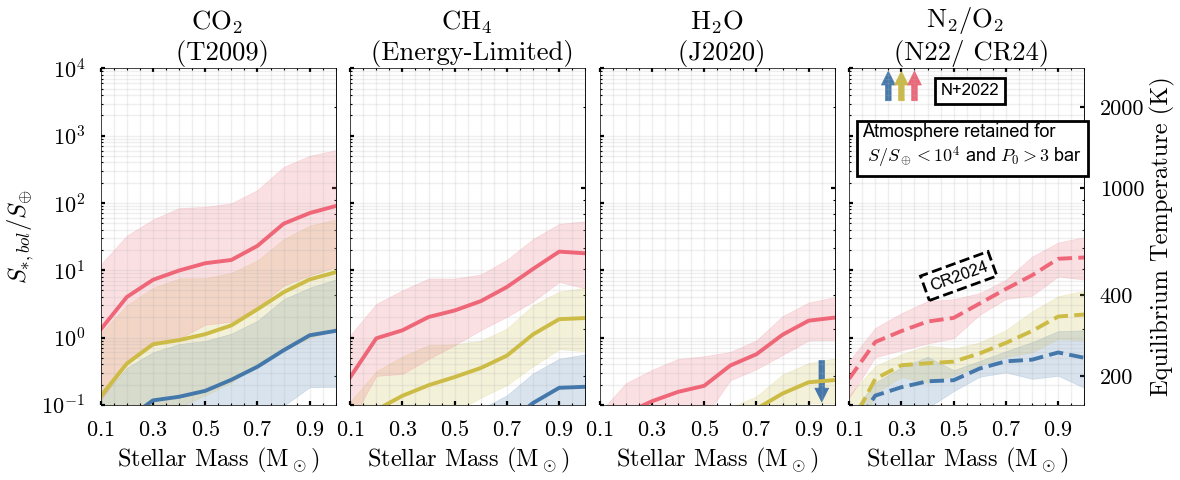

In [20]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches



fig, axes = plt.subplots(1,4,figsize=(12,5),sharex=True,sharey=True)
axes_arr = axes  
MMWs = [44, 16, 18, 28, 28]
stellar_masses = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colors = ['C0', 'C3', 'C1', 'gray']

earth_mass = 5.972e24
initial_atms = np.array([1e-4,1e-3,1e-2])*earth_mass


for n_atm,m0_atm in enumerate(initial_atms):
    for n_x, MMW in enumerate(MMWs):
        if MMW == 28:
            # if n_x != 4:
            #     if n_atm == 1:
            #         axes_arr[n_x].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color='C%d'%(n_atm+3))
            #         axes_arr[n_x].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
            #                                 color='C%d'%(n_atm+3),alpha=0.2)
            if n_x == 4:
                axes_arr[3].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color=colors[n_atm],ls='--')
                axes_arr[3].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
                                    color=colors[n_atm],alpha=0.2)
            else:
                axes_arr[n_x].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color=colors[n_atm])
                axes_arr[n_x].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
                                    color=colors[n_atm],alpha=0.2)
            
        else:
            axes_arr[n_x].plot(stellar_masses,CS_insol_01[n_x,:,n_atm],color=colors[n_atm])
            axes_arr[n_x].fill_between(stellar_masses,CS_insol_001[n_x,:,n_atm],CS_insol_05[n_x,:,n_atm],
                                    color=colors[n_atm],alpha=0.2)


# Conversion functions
def S_to_Teq(S):
    """Convert insolation S to equilibrium temperature T_eq."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (S * 1361 / 4 / sigma) ** 0.25

def Teq_to_S(Teq):
    """Convert equilibrium temperature T_eq back to insolation S."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (Teq**4 * sigma) / (1361/4)

for n_ax,ax in enumerate(axes_arr):
    ax.set_yscale('log')
    ax.set_xlabel('Stellar Mass (M$_\odot$)')
    ax.set_ylim(0.1,10000)
    ax.set_xlim(0.1,1)
    ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
    ax.grid(True,which="both",ls="-",alpha=0.2,lw=1)
    ax.tick_params(axis='y',which='both', right=False)
    ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
    if n_ax<3:
        ax2.tick_params(axis='y',which='both',labelright=False)
    else:
        ax2.set_ylabel('Equilibrium Temperature (K)')
        ax2.set_yticks([200,400,1000,2000])
        ax2.set_yticklabels([200,400,1000,2000])
        # ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        # ax2.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        # ax2.yaxis.
        



axes_arr[0].set_ylabel('$S_{*,bol}/S_{\oplus}$')
handles = [Line2D([0], [0], color=colors[0], label='$10^{-4}$ ($P_0 \sim 10^2$ bar)'),
           Line2D([0], [0], color=colors[1], label='$10^{-3}$ ($P_0 \sim 10^3$ bar)'),
              Line2D([0], [0], color=colors[2], label='$10^{-2}$ ($P_0 \sim 10^4$ bar)')]

# fig.legend(handles=handles, loc='upper center', 
#            bbox_to_anchor=(0.5, -0.01), ncol=3, 
#            title='Initial Fraction of Volatile in Planet Mass ($f_{initial}$)',frameon=True, 
#            edgecolor='black', fontsize='x-large',title_fontsize='x-large')
# handles_WW = [Line2D([0], [0], color='gray', label=f'0.3')]

# axes_arr[2].legend(handles=handles_WW,title='Initial Fraction of H2O\n in Planet Mass',
#                    frameon=True, edgecolor='black', fontsize='x-large',title_fontsize='large')


arrow = mpatches.FancyArrowPatch((0.95, 0.5), (0.95, 0.1),
                                 mutation_scale=20,edgecolor=colors[0],facecolor=colors[0])
axes_arr[2].add_patch(arrow)

arrow = mpatches.FancyArrowPatch((0.25, 3000), (0.25, 1e4),
                                 mutation_scale=20,edgecolor=colors[0],facecolor=colors[0])
axes_arr[3].add_patch(arrow)
arrow = mpatches.FancyArrowPatch((0.3, 3000), (0.3, 1e4),
                                 mutation_scale=20,edgecolor=colors[1],facecolor=colors[1])
axes_arr[3].add_patch(arrow)
arrow = mpatches.FancyArrowPatch((0.35, 3000), (0.35, 1e4),
                                 mutation_scale=20,edgecolor=colors[2],facecolor=colors[2])
axes_arr[3].add_patch(arrow)
axes_arr[3].text(0.45,4000, 'N+2022', fontsize='large', font='arial',bbox=dict(facecolor='white', edgecolor='black', ls='-',lw=2))

axes_arr[3].text(0.15,400, 'Atmosphere retained for \n $S/S_\oplus<10^4$ and $P_0>3$ bar', 
                 fontsize=13, font='arial',zorder=10,bbox=dict(facecolor='white', edgecolor='black', ls='-',lw=2))

axes_arr[3].text(0.4,5, 'CR2024', fontsize='large', font='arial',bbox=dict(facecolor='white', edgecolor='black', ls='--',lw=2),rotation=20)

# fig.suptitle('Cosmic Shoreline for Earth-Mass Planets', fontsize='xx-large')
axes_arr[0].set_title('CO$_2$ \n (T2009)')
axes_arr[1].set_title('CH$_4$ \n (Energy-Limited)')
axes_arr[2].set_title('H$_2$O \n (J2020)')
axes_arr[3].set_title('N$_2$/O$_2$ \n (N22/ CR24)')




fig.tight_layout(w_pad=0)

fig.savefig('./figures/Cosmic_Shoreline_stmass_2age_dists.pdf',bbox_inches='tight')

## 2.2 Cosmic Shoreline: Planetary Mass

In [6]:
rmr = RMRelation()
mds = rmr.predict_mass(radius=(1.5))
mds

Mass distribution
size: 5000
is bimodal: True

Median: 3.81,
64% limits: [2.4 4.1],
95% limits: [1.5 4.6]

Distribution model:
  0.18 × T(m=1.88, σ=0.32, λ=2.93)
+ 0.82 × T(m=3.88, σ=0.24, λ=2.49)

In [7]:
cs.M_R_fit(3.8,x_M_or_R='M')**3/1.5**3


0.881666603948544

In [51]:
df = pd.read_csv('./exoplanets_data/TSM/NASAExoArchive_2025-03-20_aggregate.csv',keep_default_na=True,low_memory=False)

# make the minimum mass from RV as the real mass
df['pl_masse']=df['pl_bmasse']
df['pl_masseerr2']=df['pl_bmasseerr2']
df['pl_masseerr1']=df['pl_bmasseerr1']


#  remove maximum mass
df['pl_masse'] = np.where(df['pl_bmasselim']==1, np.nan, df['pl_masse'])

# calculated the mass from radius assuming earth-like composition
masse_calc = cs.M_R_fit(df['pl_rade'].to_numpy(),x_M_or_R='R')
df['pl_masse_calc'] = np.where(df['pl_masse'].isna(),masse_calc,df['pl_masse'])
df['pl_g'] = 9.81*df['pl_masse']/(df['pl_rade'])**2
df['pl_rho_ratio'] = cs.M_R_fit(df['pl_masse'].to_numpy(),x_M_or_R='M')**3/df['pl_rade']**3


# remove planets above radius valley (Ho and Van Eylen 2024) (applied to 0.6-1.4 M_odot)
# Mask for planets with st_mass < 0.6, but exclude those with pl_rade > 1.5 if pl_masse is NaN
mask_low_mass = (df['st_mass'] < 0.6) & ~((df['pl_rade'] > 1.5)&(df['pl_rho_ratio'] < 0.6))

# Mask for rows with 0.6 <= st_mass < 1.4 that satisfy the filter condition
mask_middle = (
    (df['st_mass'] >= 0.6) & (df['st_mass'] < 1.4) &
    (np.log10(df['pl_rade']) < (-0.11 * np.log10(df['pl_orbper']) + 0.37))
)

# Combine the masks
mask = mask_low_mass | mask_middle

# Apply the combined mask to the DataFrame
df_rocks = df[mask]

# remove planets with mass < 0.5 M_earth

# calculate escape velocity
earth_mass = 5.972e24
G = 6.67430e-11
earth_radius = 6.371e6

df_rocks['pl_vesc'] = np.sqrt(2*G*earth_mass*df_rocks['pl_masse_calc']/(df_rocks['pl_rade']*earth_radius))/(1e3)


/home/xuanji/ipykernel_603682/1579512008.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rocks['pl_vesc'] = np.sqrt(2*G*earth_mass*df_rocks['pl_masse_calc']/(df_rocks['pl_rade']*earth_radius))/(1e3)


In [9]:
# Read the file
df_STSCI_table = pd.read_csv('./exoplanets_data/STSCI_Targets_v2', 
                 skiprows=1,  # Skip the header row
                 names=['Planet_Name', 'Radius', 'Mass', 'Period', 'K_mag', 'T_eff', 'a/R*', 'Rp/R*', 'Teq', 'Priority_Metric'])

df_STSCI_table['Planet_Name']

df_STSCI = df_rocks[df_rocks['pl_name'].isin(df_STSCI_table['Planet_Name'])]

In [10]:
# JWST_Transit_list = 

ds_JWST_transit_list = pd.read_csv('./exoplanets_data/trexolists.csv').Target
df_JWST_transit = df_rocks[df_rocks['hostname'].isin(ds_JWST_transit_list)]

ds_JWST_direct_list = pd.read_csv('./exoplanets_data/diexolists.csv').Target
df_JWST_direct = df_rocks[df_rocks['hostname'].isin(ds_JWST_direct_list)]


In [33]:
TESS_ESM_targets = [
    'TOI-4670.01', 'TOI-5205 b', 'HD189733 b', 'Kepler-1935 b', 'WASP-76 b', 'WASP-33 b', 'TOI-706.01',
    'TOI-5023.01', 'TOI-6137.01', 'HD209458 b', 'KELT-7 b', 'KELT-20 b', 'TOI-5311.01', 'TOI-6626.01',
    'TOI-6801.01', 'WASP-77A b', 'HAT-P-32 b', 'WASP-189 b', 'TOI-6508.01', 'TOI-519 b', 'TOI-507.01',
    'WASP-43 b', 'WASP-19 b', 'WASP-18 b', 'TOI-6601.01', 'TOI-1130 c', 'TOI-6055.01', 'K2-31 b',
    'KELT-4A b', 'WASP-121 b', 'TOI-2134 c', 'TOI-4860 b', 'HAT-P-20 b', 'HIP65A b', 'LTT9779 b',
    'TOI-6093.01', 'TOI-5579.01', 'TOI-2640.01', 'TOI-2341.01', 'TOI-1408 b', 'TOI-1254.01',
    'TOI-906.01', 'TOI-5575.01', 'TOI-5695.01', 'HAT-P-3 b', 'TOI-564 b', 'TOI-5019.01', 'TOI-5179.01',
    'K2-387 b', 'TOI-674 b', 'TOI-6110.01', 'HD149026 b', 'TOI-1954.01', 'TOI-5907.01', 'TOI-1104.01',
    'WASP-132 b', 'WASP-29 b', 'TOI-2641 b', 'TOI-6360.01', 'TOI-6010.01', 'TOI-4506.01', 'GJ436 b',
    'TOI-5800.01', 'Kepler-1979 b', 'TOI-851.01', 'TOI-1546.01', 'TOI-1231 b', 'AU Mic b', 'TOI-5938.01',
    'K2-266 b', 'TOI-849 b', 'TOI-5738.02', 'TOI-620 b', 'TOI-1130 b', 'Kepler-1907 c', 'TOI-332 b',
    'TOI-4632.01', 'AU Mic c', 'TOI-5486.01', 'TOI-1252.01', 'TOI-1293.01', 'TOI-2088.01', 'HD73583 b',
    'TOI-2768.01', 'TOI-824 b', 'TOI-5345.01', 'TOI-1468 c', 'Kepler-283 c', 'HD219134 b', 'Kepler-1862 b',
    '55 Cnc e', 'TOI-2260 b', 'TOI-4336A b', 'GJ1214 b', 'TOI-6940.01', 'Kepler-24 e', 'K2-370 b',
    'TOI-2324.01', 'TOI-5713.01', 'HD219134 c', 'pi Men c', 'TOI-5955.01', 'HD213885 b', 'TOI-539.01',
    'TOI-1452 b', 'TOI-277 b', 'TOI-2427 b', 'HR858 b', 'HD3167 b', 'TOI-6260.01', 'TOI-6002.01',
    'GJ3090 b', 'TOI-6717.01', 'TOI-1075 b', 'K2-100 b', 'HD80653 b', 'TRAPPIST-1 c', 'GJ486 b',
    'LHS3844 b', 'TOI-6255.01', 'Kepler-1984 b', 'TOI-561 b', 'Gliese 12 b', 'HD260655 b', 'GJ806 b',
    'GJ367 b', 'TOI-431 b', 'TOI-1444 b', 'TOI-6714.01', 'GJ1132 b', 'TOI-4552.01', 'TOI-1263.01',
    'K2-141 b', 'TOI-801.01', 'TRAPPIST-1 d', 'L98-59 c', 'TOI-6324.01', 'TOI-500 b', 'TOI-1807 b',
    'K2-183 b', 'LP890-9 c', 'LTT1445A c', 'GJ1252 b', 'TOI-864.01', 'TOI-1860 b', 'Kepler-1107 b'
]

df_ESM = df_rocks[df_rocks['pl_name'].isin(TESS_ESM_targets)]

In [34]:
TESS_TSM_targets = [
    'TOI-6508.01', 'WASP-107 b', 'HD189733 b', 'HD209458 b', 'HAT-P-67 b', 'WASP-33 b', 'TOI-4670.01',
    'TOI-5268.01', 'WASP-69 b', 'WASP-127 b', 'TOI-4597.01', 'KELT-20 b', 'TOI-6601.01', 'TOI-6368.01',
    'TOI-1420 b', 'WASP-193 b', 'WASP-76 b', 'WASP-121 b', 'TOI-5311.01', 'TOI-2455.01', 'WASP-39 b', 'KELT-11 b',
    'TOI-5806.01', 'WASP-189 b', 'TOI-1861.01', 'TOI-6626.01', 'TOI-7003.01', 'WASP-94A b', 'HAT-P-32 b',
    'WASP-178 b', 'TOI-2134 c', 'K2-141 c', 'HAT-P-26 b', 'WASP-166 b', 'LTT9779 b', 'TOI-906.01', 'TOI-5575.01',
    'TOI-3884 b', 'DSTucA b', 'HD149026 b', 'TOI-1254.01', 'TOI-5179.01', 'TOI-5579.01', 'TOI-6894.01',
    'TOI-1136 d', 'TOI-659.01', 'TOI-1954.01', 'TOI-6093.01', 'TOI-1104.01', 'GJ3470 b', 'TOI-1135 b',
    'TOI-1264.01', 'TOI-6360.01', 'TOI-2226.01', 'Kepler-16 b', 'TOI-674 b', 'HD332231 b', 'TOI-4425.01',
    'TOI-570.01', 'TOI-6010.01', 'TOI-4506.01', 'GJ436 b', 'TOI-5800.01', 'TOI-1252.01', 'TOI-851.01',
    'TOI-1546.01', 'TOI-1231 b', 'AU Mic b', 'HD191939 b', 'K2-266 b', 'TOI-5951.01', 'TOI-6985.01', 'AU Mic c',
    'TOI-5140.01', 'TOI-3350.01', 'TOI-1293.01', 'TOI-5724.01', 'HD136352 c', 'TOI-4537.01', 'TOI-824 b',
    'TOI-4340.01', 'TOI-4632.01', 'HD191939 d', 'HD73344 b', 'HD93963A c', 'TOI-2513.01', 'TOI-4336A b', 'GJ1214 b',
    'pi Men c', 'HR858 b', '55 Cnc e', 'TOI-6260.01', 'TOI-1468 c', 'L98-59 d', 'HD219134 b', 'HR858 c', 'HD3167 b', 'TOI-2260 b',
    'LHS1140 b', 'GJ3090 b', 'HD63433 b', 'TOI-5955.01', 'K2-370 b', 'TOI-2324.01', 'TOI-6002.01', 'HD219134 c',
    'TOI-544 b', 'HD86226 c', 'TOI-4644.01', 'TOI-539.01', 'TOI-5713.01', 'HD260655 c', 'HD136352 b', 'TOI-1416 b',
    'TOI-1242.01', 'TOI-2590.01', 'TRAPPIST-1 d', 'LTT1445A c', 'GJ806 b', 'TOI-6255.01', 'K2-137 b', 'TOI-561 b',
    'TRAPPIST-1 c', 'TOI-540 b', 'LHS3844 b', 'GJ367 b', 'TOI-1807 b', 'TOI-801.01', 'TRAPPIST-1 e', 'SPECULOOS-3 b',
    'TOI-6324.01', 'TOI-4307.02', 'TOI-431 b', 'TOI-1444 b', 'TRAPPIST-1 f', 'L98-59 b', 'GJ1252 b', 'TOI-500 b',
    'TOI-1860 b', 'K2-223 b', 'TRAPPIST-1 h', 'GJ486 b', 'TOI-6662.01', 'TOI-864.01', 'K2-141 b', 'K2-157 b']

df_TSM = df_rocks[df_rocks['pl_name'].isin(TESS_TSM_targets)]

In [35]:
# Cosmich shoreline fitted from Fig2 of Zahnle and Catling 2017

x1 = -0.6640000000000001
y1 = -5.816347826086957
x2 = 1.7119999999999997
y2 = 3.81019397993311

k_cs = (y2-y1)/(x2-x1)
b_cs = y2 - k_cs*x2

# v = np.linspace(0.1,200)

# plt.loglog([10**x1, 10**x2], [10**y1, 10**y2], 'k-', label='Cosmich shoreline')
# plt.loglog(v,10**(k_cs*np.log10(v)+b_cs), 'r--')



In [36]:
CS_insol_001 = np.load('./data-montecarlo/CS_insol_001_pl_vesc.npy')
CS_insol_01 = np.load('./data-montecarlo/CS_insol_01_pl_vesc.npy')
CS_insol_05 = np.load('./data-montecarlo/CS_insol_05_pl_vesc.npy')

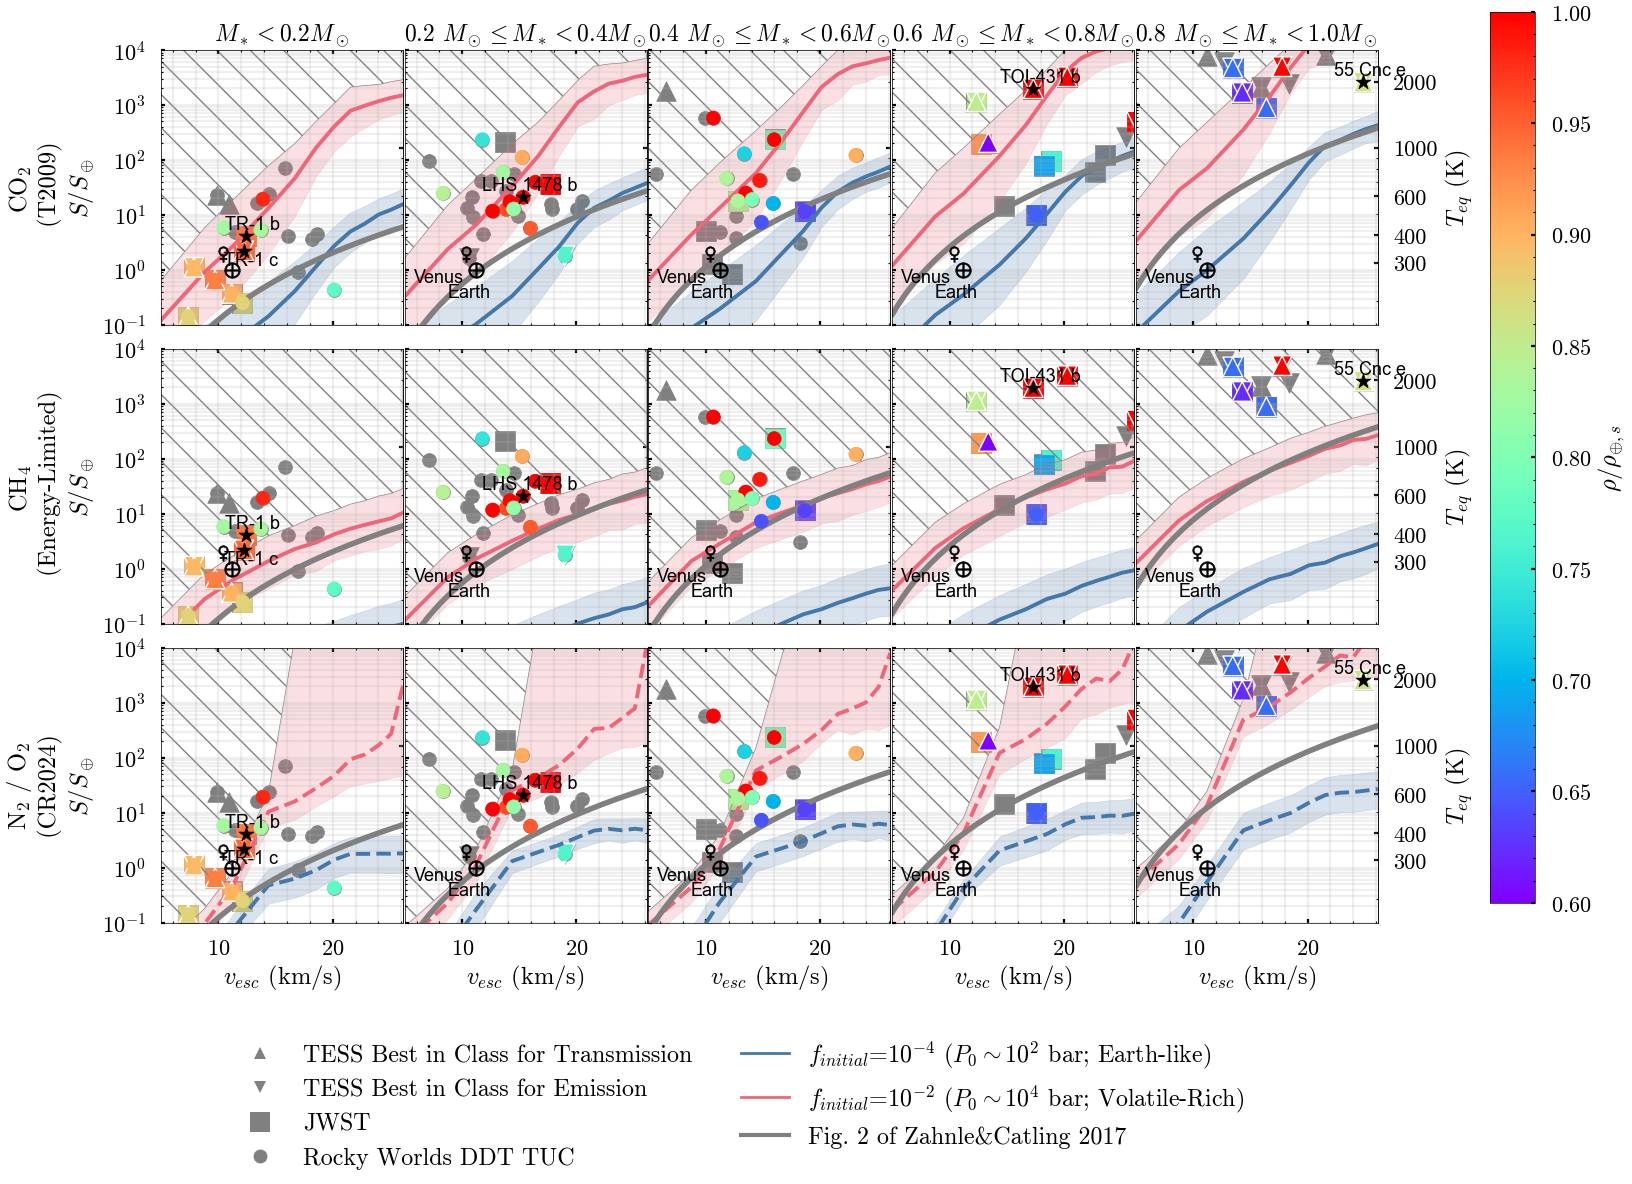

In [37]:
from matplotlib.colors import LogNorm

cs = CosmicShoreline()
earth_mass = 5.972e24  # in kg



# Initialize figure for the new plot
fig2, axes = plt.subplots(3, 5, figsize=(15,10),sharex=True,sharey=True)

# Define atmospheres and MMWs before using them

atmospheres = ['CO2', 'CH4', 'N2+O2']
MMWs = {'CO2': 44, 'CH4': 16, 'N2+O2': 28}

f_initial_values = [1e-4, 1e-3, 1e-2]
colors = ['C0', 'C3', 'C1']

pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*earth_mass/(pl_rades*6.371e6))/1e3



# Stellar mass fixed at 1 Solar mass
st_mass_values = [0.1, 0.3, 0.5, 0.7, 1]
st_mass_labels = ['$M_*<0.2 M_\odot$',
                  '0.2 $M_\odot \leq M_* < 0.4 M_\odot$',
                  '0.4 $M_\odot \leq M_* < 0.6 M_\odot$',
                  '0.6 $M_\odot \leq M_* < 0.8 M_\odot$',
                  '0.8 $M_\odot \leq M_* < 1.0 M_\odot$']

texts = []

for n2, st_mass in zip(range(len(st_mass_values)),st_mass_values):
    if n2 == 0:
        df_JWST_transit_sub = df_JWST_transit[df_JWST_transit['st_mass']<0.2]
        df_JWST_direct_sub = df_JWST_direct[df_JWST_direct['st_mass']<0.2]
        df_TSM_sub = df_TSM[df_TSM['st_mass']<0.2]
        df_ESM_sub = df_ESM[df_ESM['st_mass']<0.2]
        df_STSCI_sub = df_STSCI[df_STSCI['st_mass']<0.2]
        df_rocks_sub = df_rocks[df_rocks['st_mass']<0.2]
    elif n2 == 1:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.2) & (df_JWST_transit['st_mass']<0.4)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.2) & (df_JWST_direct['st_mass']<0.4)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.2) & (df_TSM['st_mass']<0.4)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.2) & (df_ESM['st_mass']<0.4)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.2) & (df_STSCI['st_mass']<0.4)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.2) & (df_rocks['st_mass']<0.4)]
    elif n2 == 2:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.4) & (df_JWST_transit['st_mass']<0.6)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.4) & (df_JWST_direct['st_mass']<0.6)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.4) & (df_TSM['st_mass']<0.6)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.4) & (df_ESM['st_mass']<0.6)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.4) & (df_STSCI['st_mass']<0.6)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.4) & (df_rocks['st_mass']<0.6)]
    elif n2 == 3:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.6) & (df_JWST_transit['st_mass']<0.8)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.6) & (df_JWST_direct['st_mass']<0.8)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.6) & (df_TSM['st_mass']<0.8)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.6) & (df_ESM['st_mass']<0.8)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.6) & (df_STSCI['st_mass']<0.8)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.6) & (df_rocks['st_mass']<0.8)]
    else:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.8)&(df_JWST_transit['st_mass']<1.0)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.8)&(df_JWST_direct['st_mass']<1.0)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.8)&(df_TSM['st_mass']<1.0)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.8)&(df_ESM['st_mass']<1.0)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.8)&(df_STSCI['st_mass']<1.0)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.8) & (df_rocks['st_mass']<1.0)]

    for n1, atm in enumerate(atmospheres):
        ax=axes[n1,n2]
    
        ax.scatter(df_TSM_sub['pl_vesc'], df_TSM_sub['pl_insol'],marker='^',s=200,label='TSM',zorder=3,edgecolors='w',linewidths=1,
                    c = df_TSM_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        ax.scatter(df_ESM_sub['pl_vesc'], df_ESM_sub['pl_insol'],marker='v',s=200,label='ESM',zorder=2,edgecolors='w',linewidths=1,
                    c = df_ESM_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        ax.scatter(df_JWST_transit_sub['pl_vesc'], df_JWST_transit_sub['pl_insol'], marker='s',s=200,label='JWST Cycle3',zorder=1,
                    c = df_JWST_transit_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        ax.scatter(df_JWST_direct_sub['pl_vesc'], df_JWST_direct_sub['pl_insol'], marker='s',s=200,label='JWST Cycle3',zorder=1,
                     c = df_JWST_direct_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")

        c_ax = ax.scatter(df_STSCI_sub['pl_vesc'], df_STSCI_sub['pl_insol'], c=df_STSCI_sub['pl_rho_ratio'],
                    marker='o',s=100,label='JWST Cycle3',zorder=10,vmin=0.6,vmax=1.0,cmap="rainbow")
        # ax.scatter(df_rocks_sub['pl_vesc'], df_rocks_sub['pl_insol'], marker='o',s=50,label='Rocky Planets',zorder=9,
                    # c = df_rocks_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        
        ax.scatter(df_TSM_sub['pl_vesc'], df_TSM_sub['pl_insol'],marker='^',s=200,zorder=0,c='gray')
        ax.scatter(df_ESM_sub['pl_vesc'], df_ESM_sub['pl_insol'],marker='v',s=200,zorder=0,c='gray')
        ax.scatter(df_JWST_transit_sub['pl_vesc'], df_JWST_transit_sub['pl_insol'], marker='s',s=200,zorder=0,c='gray')
        ax.scatter(df_JWST_direct_sub['pl_vesc'], df_JWST_direct_sub['pl_insol'], marker='s',s=200,zorder=0,c='gray')
        ax.scatter(df_STSCI_sub['pl_vesc'], df_STSCI_sub['pl_insol'], marker='o',s=100,zorder=0,c='gray')
        # ax.scatter(df_rocks_sub['pl_vesc'], df_rocks_sub['pl_insol'], marker='o',s=50,zorder=0,c='gray')


        # for i, txt in enumerate(df_STSCI_sub['Planet_Name']):
        #     texts.append(ax.annotate(txt, (df_STSCI_sub['pl_vesc'].values[i], df_STSCI_sub['pl_insol'].values[i]), 
        #                 textcoords="offset points", xytext=(5,5), ha='center',fontsize=13, rotation=45))

        
        
        # ax.plot(pl_v_esc, min_S_for_pl_mass, color=color, alpha=0.3)
        # plot solar system planets
        planets = ["Mercury", "Venus", "Earth", "Mars", "55 Cnc e", "LHS 1478 b", "TRAPPIST-1 b", "TRAPPIST-1 c","TOI-431 b"]
        pl_vesc = [4.25, 10.36, 11.19, 5.03, 23.09, 15.32, 12.41, 12.78, 17.3236]  # in km/s
        insolation_relative_to_earth = [6.67, 1.91, 1.00, 0.43, 2441, 23.37, 4.15, 2.27, 1970.761]
        for planet, esc_vel, insolation in zip(planets, pl_vesc, insolation_relative_to_earth):
            if planet in df_rocks['pl_name'].values:
                esc_vel = df_rocks[df_rocks['pl_name']==planet]['pl_vesc'].values[0]
                insolation = df_rocks[df_rocks['pl_name']==planet]['pl_insol'].values[0]
                if planet == "TRAPPIST-1 b":
                    planet = 'TR-1 b'
                elif planet == "TRAPPIST-1 c":
                    planet = 'TR-1 c'
            if planet == "55 Cnc e":
                if n2 ==4:
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet == "LHS 1478 b":
                if n2 ==1:
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet[0] == 'T':
                if n2 ==0 and planet[1] == 'R':
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    if planet[-1] == 'b':
                        texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                                 xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
                    else:
                        texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                                 xytext=(5,-10), ha='center',zorder=15,fontsize=13, font='arial'))
                elif n2 ==3 and planet[1] == 'O':
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet == 'Venus':
                ax.scatter(esc_vel, insolation,marker='$♀$',color='black',zorder=10)
                if n2>0:
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(-20,-20), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet == 'Earth':
                ax.scatter(esc_vel, insolation,marker='$⊕$',color='black',zorder=10)
                if n2>0:
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(-5,-20), ha='center',zorder=15,fontsize=13, font='arial'))

        # ax.set_ylim(1, 4e4)
        ax.set_xscale('linear')
        ax.set_yscale('log')
        # ax.set_xscale('log')
        ax.set_xlim(min(pl_v_esc), max(pl_v_esc))
        ax.set_ylim(0.1, 1e4)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        axes[n1,0].set_ylabel('%s \n S/S_\oplus'%atm)

planet_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_radiuse_values = cs.M_R_fit(planet_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*planet_masses*earth_mass/(pl_radiuse_values*6.371e6))/1e3
stellar_mass_range = [[0.1,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8], [0.8,1.0]]
for n_x, MMW in enumerate(MMWs):
    for n_st, stellar_mass in enumerate(stellar_mass_range):
        if n_x == 2:
            ls ='--'
        else:
            ls = '-'
        axes[n_x,n_st].plot(pl_v_esc ,CS_insol_01[n_x,n_st,:,0],color=colors[0],ls=ls)
        axes[n_x,n_st].fill_between(pl_v_esc ,CS_insol_001[n_x,n_st,:,0],CS_insol_05[n_x,n_st,:,0],
                                   color=colors[0],alpha=0.2)
        axes[n_x,n_st].plot(pl_v_esc ,CS_insol_01[n_x,n_st,:,1],color=colors[2],ls=ls)
        axes[n_x,n_st].fill_between(pl_v_esc,CS_insol_001[n_x,n_st,:,1],CS_insol_05[n_x,n_st,:,1],
                                   color=colors[2],alpha=0.2)
        axes[n_x,n_st].fill_between(pl_v_esc ,CS_insol_05[n_x,n_st,:,1],1e4*np.ones_like(pl_v_esc),
                                   hatch='\\',facecolor='none',edgecolor='gray')

for ax in axes[-1,:]:
    ax.set_xlabel('$v_{esc}$ (km/s)')
for n2,ax in enumerate(axes[0,:]):
    ax.set_title(f'{st_mass_labels[n2]}',fontsize=17)

# L_xuv1 = cs.calculate_L_XUV(0.1,3e9)
# L_bol1 = 3.846e26*10**cs.L_bol_interpolator_B15((0.1,np.log10(3e9)))
# F_xuv1 = L_xuv1/L_bol1

# L_xuv2 = cs.calculate_L_XUV(0.3,3e9)
# L_bol2 = 3.846e26*10**cs.L_bol_interpolator_B15((0.3,np.log10(3e9)))
# F_xuv2 = L_xuv2/L_bol2

# L_xuv3 = cs.calculate_L_XUV(0.5,3e9)
# L_bol3 = 3.846e26*10**cs.L_bol_interpolator_B15((0.5,np.log10(3e9)))
# F_xuv3 = L_xuv3/L_bol3

# L_xuv4 = cs.calculate_L_XUV(1,3e9)
# L_bol4 = 3.846e26*10**cs.L_bol_interpolator_B15((1,np.log10(3e9)))
# F_xuv4 = L_xuv4/L_bol4

# F_bol1 = 10**cs.L_bol_interpolator_B15((0.1,np.log10(3e9)))
# F_xuv1 = F_bol1**(-0.6)

# F_bol2 = 10**cs.L_bol_interpolator_B15((0.3,np.log10(3e9)))
# F_xuv2 = F_bol2**(-0.6)

# F_bol3 = 10**cs.L_bol_interpolator_B15((0.5,np.log10(3e9)))
# F_xuv3 = F_bol3**(-0.6)

# F_bol4 = 10**cs.L_bol_interpolator_B15((1,np.log10(3e9)))
# F_xuv4 = F_bol4**(-0.6)



v_arr = np.linspace(5, 30)
for n_ax in range(5):
    for ax in axes[:,n_ax]:
        factor = 10**cs.L_bol_interpolator_B15((st_mass_values[n_ax],np.log10(3e9)))
        ax.plot(v_arr, factor**0.6*10**(k_cs*np.log10(v_arr)+b_cs), color='gray', lw=4)


custom_lines = [plt.Line2D([0], [0], linestyle = '',marker='^', color='gray', markersize=8),
                plt.Line2D([0], [0], linestyle = '', marker='v', color='gray', markersize=8),
                plt.Line2D([0], [0], linestyle = '', marker='s', color='gray', markersize=15),
                plt.Line2D([0], [0], linestyle = '', marker='o', color='gray', markersize=10)]

legend_labels = ['TESS Best in Class for Transmission','TESS Best in Class for Emission','JWST','Rocky Worlds DDT TUC']

custom_lines += [plt.Line2D([0], [0], color=color, lw=2) for color in [colors[0],colors[2]]]
legend_labels += [('$f_{initial}$='+'%s'%(fc_0)+
                   r' ($P_0\sim$%s bar; %s)')%(P0,text1) 
                   for fc_0,P0,text1 in zip(['$10^{-4}$','$10^{-2}$'],['$10^2$','$10^4$'],
                                                        ['Earth-like','Volatile-Rich'],)]

# custom_lines += [plt.Line2D([0], [0], color='black', linestyle=style, lw=2) for style in ['-','--']]
# legend_labels += ['Jackson2012+Guinan2016','Selsis2007']

custom_lines += [plt.Line2D([0], [0], color='gray', lw=3)]
legend_labels += ['Fig. 2 of Zahnle&Catling 2017']

axes[0,0].set_ylabel('CO$_2$ \n (T2009)\n'+ r'$S/S_\oplus$')
axes[1,0].set_ylabel('CH$_4$ \n (Energy-Limited)\n' +r'$S/S_\oplus$')
axes[2,0].set_ylabel('N$_2$ $/$ O$_2$\n (CR2024) \n'+ r'$S/S_\oplus$')



fig2.legend(custom_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2,fontsize='xx-large')

# Conversion functions
def S_to_Teq(S):
    """Convert insolation S to equilibrium temperature T_eq."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (S * 1361 / 4 / sigma) ** 0.25

def Teq_to_S(Teq):
    """Convert equilibrium temperature T_eq back to insolation S."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (Teq**4 * sigma) / (1361/4)

for n in range(3):
    axes_row = axes[n,:]
    for n_ax,ax in enumerate(axes_row):
        ax.tick_params(axis='y',which='both', right=False)
        ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
        if n_ax<4:
            ax2.tick_params(axis='y',which='both',labelright=False)
        else:
            ax2.set_ylabel('$T_{eq}$ (K)')
            ax2.set_yticks([300,400,600,1000,2000])
            ax2.set_yticklabels(['300','400','600','1000','2000'])
# fig2.suptitle(f'Cosmic Shorelines')
# adjust_text(texts)

plt.tight_layout(w_pad=0.,h_pad=0.)



cbar_ax=fig2.add_axes([1.0, 0.1, 0.03, 0.9])
cbar_ax.set_axis_off()
cba = plt.colorbar(c_ax, ax=cbar_ax,fraction=0.99, pad=0.1)
cba.set_label(r'$\rho$/$\rho_{\oplus,s}$')


fig2.savefig('./figures/CS_vesp_vs_insol_exoplanets.pdf',bbox_inches='tight')

In [38]:
CS_insol_001 = np.load('./data-montecarlo/CS_insol_001_pl_vesc_2age_dists.npy')
CS_insol_01 = np.load('./data-montecarlo/CS_insol_01_pl_vesc_2age_dists.npy')
CS_insol_05 = np.load('./data-montecarlo/CS_insol_05_pl_vesc_2age_dists.npy')

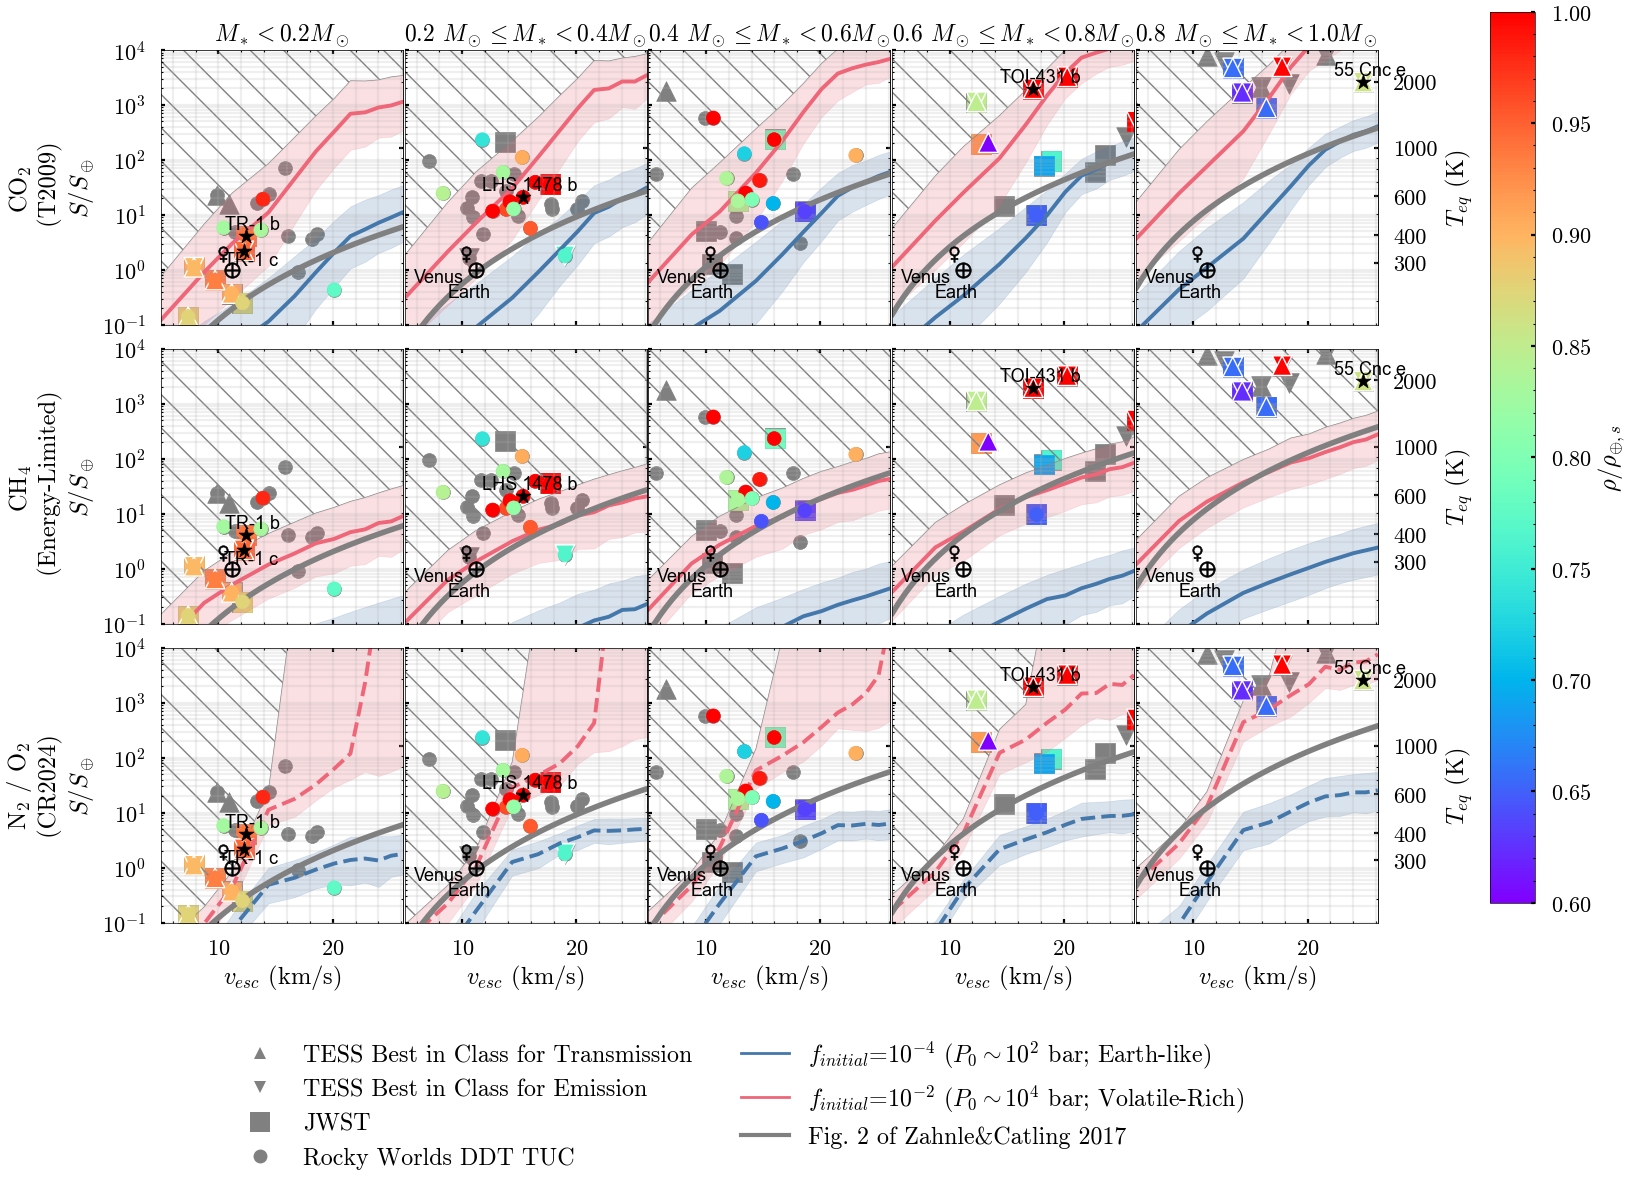

In [17]:
from matplotlib.colors import LogNorm

cs = CosmicShoreline()
earth_mass = 5.972e24  # in kg



# Initialize figure for the new plot
fig2, axes = plt.subplots(3, 5, figsize=(15,10),sharex=True,sharey=True)

# Define atmospheres and MMWs before using them

atmospheres = ['CO2', 'CH4', 'N2+O2']
MMWs = {'CO2': 44, 'CH4': 16, 'N2+O2': 28}

f_initial_values = [1e-4, 1e-3, 1e-2]
colors = ['C0', 'C3', 'C1']

pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*earth_mass/(pl_rades*6.371e6))/1e3



# Stellar mass fixed at 1 Solar mass
st_mass_values = [0.1, 0.3, 0.5, 0.7, 1]
st_mass_labels = ['$M_*<0.2 M_\odot$',
                  '0.2 $M_\odot \leq M_* < 0.4 M_\odot$',
                  '0.4 $M_\odot \leq M_* < 0.6 M_\odot$',
                  '0.6 $M_\odot \leq M_* < 0.8 M_\odot$',
                  '0.8 $M_\odot \leq M_* < 1.0 M_\odot$']

texts = []

for n2, st_mass in zip(range(len(st_mass_values)),st_mass_values):
    if n2 == 0:
        df_JWST_transit_sub = df_JWST_transit[df_JWST_transit['st_mass']<0.2]
        df_JWST_direct_sub = df_JWST_direct[df_JWST_direct['st_mass']<0.2]
        df_TSM_sub = df_TSM[df_TSM['st_mass']<0.2]
        df_ESM_sub = df_ESM[df_ESM['st_mass']<0.2]
        df_STSCI_sub = df_STSCI[df_STSCI['st_mass']<0.2]
        df_rocks_sub = df_rocks[df_rocks['st_mass']<0.2]
    elif n2 == 1:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.2) & (df_JWST_transit['st_mass']<0.4)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.2) & (df_JWST_direct['st_mass']<0.4)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.2) & (df_TSM['st_mass']<0.4)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.2) & (df_ESM['st_mass']<0.4)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.2) & (df_STSCI['st_mass']<0.4)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.2) & (df_rocks['st_mass']<0.4)]
    elif n2 == 2:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.4) & (df_JWST_transit['st_mass']<0.6)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.4) & (df_JWST_direct['st_mass']<0.6)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.4) & (df_TSM['st_mass']<0.6)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.4) & (df_ESM['st_mass']<0.6)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.4) & (df_STSCI['st_mass']<0.6)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.4) & (df_rocks['st_mass']<0.6)]
    elif n2 == 3:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.6) & (df_JWST_transit['st_mass']<0.8)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.6) & (df_JWST_direct['st_mass']<0.8)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.6) & (df_TSM['st_mass']<0.8)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.6) & (df_ESM['st_mass']<0.8)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.6) & (df_STSCI['st_mass']<0.8)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.6) & (df_rocks['st_mass']<0.8)]
    else:
        df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.8)&(df_JWST_transit['st_mass']<1.0)]
        df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.8)&(df_JWST_direct['st_mass']<1.0)]
        df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.8)&(df_TSM['st_mass']<1.0)]
        df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.8)&(df_ESM['st_mass']<1.0)]
        df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.8)&(df_STSCI['st_mass']<1.0)]
        df_rocks_sub = df_rocks[(df_rocks['st_mass']>=0.8) & (df_rocks['st_mass']<1.0)]

    for n1, atm in enumerate(atmospheres):
        ax=axes[n1,n2]
    
        ax.scatter(df_TSM_sub['pl_vesc'], df_TSM_sub['pl_insol'],marker='^',s=200,label='TSM',zorder=3,edgecolors='w',linewidths=1,
                    c = df_TSM_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        ax.scatter(df_ESM_sub['pl_vesc'], df_ESM_sub['pl_insol'],marker='v',s=200,label='ESM',zorder=2,edgecolors='w',linewidths=1,
                    c = df_ESM_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        ax.scatter(df_JWST_transit_sub['pl_vesc'], df_JWST_transit_sub['pl_insol'], marker='s',s=200,label='JWST Cycle3',zorder=1,
                    c = df_JWST_transit_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        ax.scatter(df_JWST_direct_sub['pl_vesc'], df_JWST_direct_sub['pl_insol'], marker='s',s=200,label='JWST Cycle3',zorder=1,
                     c = df_JWST_direct_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")

        c_ax = ax.scatter(df_STSCI_sub['pl_vesc'], df_STSCI_sub['pl_insol'], c=df_STSCI_sub['pl_rho_ratio'],
                    marker='o',s=100,label='JWST Cycle3',zorder=10,vmin=0.6,vmax=1.0,cmap="rainbow")
        # ax.scatter(df_rocks_sub['pl_vesc'], df_rocks_sub['pl_insol'], marker='o',s=50,label='Rocky Planets',zorder=9,
                    # c = df_rocks_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
        
        ax.scatter(df_TSM_sub['pl_vesc'], df_TSM_sub['pl_insol'],marker='^',s=200,zorder=0,c='gray')
        ax.scatter(df_ESM_sub['pl_vesc'], df_ESM_sub['pl_insol'],marker='v',s=200,zorder=0,c='gray')
        ax.scatter(df_JWST_transit_sub['pl_vesc'], df_JWST_transit_sub['pl_insol'], marker='s',s=200,zorder=0,c='gray')
        ax.scatter(df_JWST_direct_sub['pl_vesc'], df_JWST_direct_sub['pl_insol'], marker='s',s=200,zorder=0,c='gray')
        ax.scatter(df_STSCI_sub['pl_vesc'], df_STSCI_sub['pl_insol'], marker='o',s=100,zorder=0,c='gray')
        # ax.scatter(df_rocks_sub['pl_vesc'], df_rocks_sub['pl_insol'], marker='o',s=50,zorder=0,c='gray')


        # for i, txt in enumerate(df_STSCI_sub['Planet_Name']):
        #     texts.append(ax.annotate(txt, (df_STSCI_sub['pl_vesc'].values[i], df_STSCI_sub['pl_insol'].values[i]), 
        #                 textcoords="offset points", xytext=(5,5), ha='center',fontsize=13, rotation=45))

        
        
        # ax.plot(pl_v_esc, min_S_for_pl_mass, color=color, alpha=0.3)
        # plot solar system planets
        planets = ["Mercury", "Venus", "Earth", "Mars", "55 Cnc e", "LHS 1478 b", "TRAPPIST-1 b", "TRAPPIST-1 c","TOI-431 b"]
        pl_vesc = [4.25, 10.36, 11.19, 5.03, 23.09, 15.32, 12.41, 12.78, 17.3236]  # in km/s
        insolation_relative_to_earth = [6.67, 1.91, 1.00, 0.43, 2441, 23.37, 4.15, 2.27, 1970.761]
        for planet, esc_vel, insolation in zip(planets, pl_vesc, insolation_relative_to_earth):
            if planet in df_rocks['pl_name'].values:
                esc_vel = df_rocks[df_rocks['pl_name']==planet]['pl_vesc'].values[0]
                insolation = df_rocks[df_rocks['pl_name']==planet]['pl_insol'].values[0]
                if planet == "TRAPPIST-1 b":
                    planet = 'TR-1 b'
                elif planet == "TRAPPIST-1 c":
                    planet = 'TR-1 c'
            if planet == "55 Cnc e":
                if n2 ==4:
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet == "LHS 1478 b":
                if n2 ==1:
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet[0] == 'T':
                if n2 ==0 and planet[1] == 'R':
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    if planet[-1] == 'b':
                        texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                                 xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
                    else:
                        texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                                 xytext=(5,-10), ha='center',zorder=15,fontsize=13, font='arial'))
                elif n2 ==3 and planet[1] == 'O':
                    ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet == 'Venus':
                ax.scatter(esc_vel, insolation,marker='$♀$',color='black',zorder=10)
                if n2>0:
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(-20,-20), ha='center',zorder=15,fontsize=13, font='arial'))
            elif planet == 'Earth':
                ax.scatter(esc_vel, insolation,marker='$⊕$',color='black',zorder=10)
                if n2>0:
                    texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
                                             xytext=(-5,-20), ha='center',zorder=15,fontsize=13, font='arial'))

        # ax.set_ylim(1, 4e4)
        ax.set_xscale('linear')
        ax.set_yscale('log')
        # ax.set_xscale('log')
        ax.set_xlim(min(pl_v_esc), max(pl_v_esc))
        ax.set_ylim(0.1, 1e4)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        axes[n1,0].set_ylabel('%s \n S/S_\oplus'%atm)

planet_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_radiuse_values = cs.M_R_fit(planet_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*planet_masses*earth_mass/(pl_radiuse_values*6.371e6))/1e3
stellar_mass_range = [[0.1,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8], [0.8,1.0]]
for n_x, MMW in enumerate(MMWs):
    for n_st, stellar_mass in enumerate(stellar_mass_range):
        if n_x == 2:
            ls ='--'
        else:
            ls = '-'
        axes[n_x,n_st].plot(pl_v_esc ,CS_insol_01[n_x,n_st,:,0],color=colors[0],ls=ls)
        axes[n_x,n_st].fill_between(pl_v_esc ,CS_insol_001[n_x,n_st,:,0],CS_insol_05[n_x,n_st,:,0],
                                   color=colors[0],alpha=0.2)
        axes[n_x,n_st].plot(pl_v_esc ,CS_insol_01[n_x,n_st,:,1],color=colors[2],ls=ls)
        axes[n_x,n_st].fill_between(pl_v_esc,CS_insol_001[n_x,n_st,:,1],CS_insol_05[n_x,n_st,:,1],
                                   color=colors[2],alpha=0.2)
        axes[n_x,n_st].fill_between(pl_v_esc ,CS_insol_05[n_x,n_st,:,1],1e4*np.ones_like(pl_v_esc),
                                   hatch='\\',facecolor='none',edgecolor='gray')

for ax in axes[-1,:]:
    ax.set_xlabel('$v_{esc}$ (km/s)')
for n2,ax in enumerate(axes[0,:]):
    ax.set_title(f'{st_mass_labels[n2]}',fontsize=17)

# L_xuv1 = cs.calculate_L_XUV(0.1,3e9)
# L_bol1 = 3.846e26*10**cs.L_bol_interpolator_B15((0.1,np.log10(3e9)))
# F_xuv1 = L_xuv1/L_bol1

# L_xuv2 = cs.calculate_L_XUV(0.3,3e9)
# L_bol2 = 3.846e26*10**cs.L_bol_interpolator_B15((0.3,np.log10(3e9)))
# F_xuv2 = L_xuv2/L_bol2

# L_xuv3 = cs.calculate_L_XUV(0.5,3e9)
# L_bol3 = 3.846e26*10**cs.L_bol_interpolator_B15((0.5,np.log10(3e9)))
# F_xuv3 = L_xuv3/L_bol3

# L_xuv4 = cs.calculate_L_XUV(1,3e9)
# L_bol4 = 3.846e26*10**cs.L_bol_interpolator_B15((1,np.log10(3e9)))
# F_xuv4 = L_xuv4/L_bol4

# F_bol1 = 10**cs.L_bol_interpolator_B15((0.1,np.log10(3e9)))
# F_xuv1 = F_bol1**(-0.6)

# F_bol2 = 10**cs.L_bol_interpolator_B15((0.3,np.log10(3e9)))
# F_xuv2 = F_bol2**(-0.6)

# F_bol3 = 10**cs.L_bol_interpolator_B15((0.5,np.log10(3e9)))
# F_xuv3 = F_bol3**(-0.6)

# F_bol4 = 10**cs.L_bol_interpolator_B15((1,np.log10(3e9)))
# F_xuv4 = F_bol4**(-0.6)



v_arr = np.linspace(5, 30)
for n_ax in range(5):
    for ax in axes[:,n_ax]:
        factor = 10**cs.L_bol_interpolator_B15((st_mass_values[n_ax],np.log10(3e9)))
        ax.plot(v_arr, factor**0.6*10**(k_cs*np.log10(v_arr)+b_cs), color='gray', lw=4)


custom_lines = [plt.Line2D([0], [0], linestyle = '',marker='^', color='gray', markersize=8),
                plt.Line2D([0], [0], linestyle = '', marker='v', color='gray', markersize=8),
                plt.Line2D([0], [0], linestyle = '', marker='s', color='gray', markersize=15),
                plt.Line2D([0], [0], linestyle = '', marker='o', color='gray', markersize=10)]

legend_labels = ['TESS Best in Class for Transmission','TESS Best in Class for Emission','JWST','Rocky Worlds DDT TUC']

custom_lines += [plt.Line2D([0], [0], color=color, lw=2) for color in [colors[0],colors[2]]]
legend_labels += [('$f_{initial}$='+'%s'%(fc_0)+
                   r' ($P_0\sim$%s bar; %s)')%(P0,text1) 
                   for fc_0,P0,text1 in zip(['$10^{-4}$','$10^{-2}$'],['$10^2$','$10^4$'],
                                                        ['Earth-like','Volatile-Rich'],)]

# custom_lines += [plt.Line2D([0], [0], color='black', linestyle=style, lw=2) for style in ['-','--']]
# legend_labels += ['Jackson2012+Guinan2016','Selsis2007']

custom_lines += [plt.Line2D([0], [0], color='gray', lw=3)]
legend_labels += ['Fig. 2 of Zahnle&Catling 2017']

axes[0,0].set_ylabel('CO$_2$ \n (T2009)\n'+ r'$S/S_\oplus$')
axes[1,0].set_ylabel('CH$_4$ \n (Energy-Limited)\n' +r'$S/S_\oplus$')
axes[2,0].set_ylabel('N$_2$ $/$ O$_2$\n (CR2024) \n'+ r'$S/S_\oplus$')



fig2.legend(custom_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2,fontsize='xx-large')

# Conversion functions
def S_to_Teq(S):
    """Convert insolation S to equilibrium temperature T_eq."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (S * 1361 / 4 / sigma) ** 0.25

def Teq_to_S(Teq):
    """Convert equilibrium temperature T_eq back to insolation S."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (Teq**4 * sigma) / (1361/4)

for n in range(3):
    axes_row = axes[n,:]
    for n_ax,ax in enumerate(axes_row):
        ax.tick_params(axis='y',which='both', right=False)
        ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
        if n_ax<4:
            ax2.tick_params(axis='y',which='both',labelright=False)
        else:
            ax2.set_ylabel('$T_{eq}$ (K)')
            ax2.set_yticks([300,400,600,1000,2000])
            ax2.set_yticklabels(['300','400','600','1000','2000'])
# fig2.suptitle(f'Cosmic Shorelines')
# adjust_text(texts)

plt.tight_layout(w_pad=0.,h_pad=0.)



cbar_ax=fig2.add_axes([1.0, 0.1, 0.03, 0.9])
cbar_ax.set_axis_off()
cba = plt.colorbar(c_ax, ax=cbar_ax,fraction=0.99, pad=0.1)
cba.set_label(r'$\rho$/$\rho_{\oplus,s}$')


fig2.savefig('./figures/CS_vesp_vs_insol_exoplanets_age_2dists.pdf',bbox_inches='tight')

In [37]:
# CS_insol_001 = np.load('data-montecarlo/CS_V2_insol_001_pl_vesc_slides.npy')
# CS_insol_01 = np.load('data-montecarlo/CS_V2_insol_01_pl_vesc_slides.npy')
# CS_insol_05 = np.load('data-montecarlo/CS_V2_insol_05_pl_vesc_slides.npy')

In [38]:
# from matplotlib.colors import LogNorm

# cs = CosmicShoreline()
# earth_mass = 5.972e24  # in kg



# # Initialize figure for the new plot
# fig2, axes = plt.subplots(3, 1, figsize=(10,10),sharex=True,sharey=True)

# # Define atmospheres and MMWs before using them

# atmospheres = ['CO2', 'CH4', 'N2+O2']
# MMWs = {'CO2': 44, 'CH4': 16, 'N2+O2': 28}

# f_initial_values = [1e-4, 1e-3, 1e-2]
# colors = ['C0', 'C3', 'C1']

# pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
# pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
# pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*earth_mass/(pl_rades*6.371e6))/1e3



# # Stellar mass fixed at 1 Solar mass
# st_mass_values = [0.2]
# st_mass_labels = ['$M_*<0.4 M_\odot$']

# texts = []

# for n2, st_mass in zip(range(len(st_mass_values)),st_mass_values):
#     if n2 == 0:
#         df_JWST_transit_sub = df_JWST_transit[df_JWST_transit['st_mass']<0.4]
#         df_JWST_direct_sub = df_JWST_direct[df_JWST_direct['st_mass']<0.4]
#         df_TSM_sub = df_TSM[df_TSM['st_mass']<0.4]
#         df_ESM_sub = df_ESM[df_ESM['st_mass']<0.4]
#         df_STSCI_sub = df_STSCI[df_STSCI['st_mass']<0.4]
#     elif n2 == 1:
#         df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.4) & (df_JWST_transit['st_mass']<0.8)]
#         df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.4) & (df_JWST_direct['st_mass']<0.8)]
#         df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.4) & (df_TSM['st_mass']<0.8)]
#         df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.4) & (df_ESM['st_mass']<0.8)]
#         df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.4) & (df_STSCI['st_mass']<0.8)]
#     elif n2 == 2:
#         df_JWST_transit_sub = df_JWST_transit[(df_JWST_transit['st_mass']>=0.8) & (df_JWST_transit['st_mass']<1.0)]
#         df_JWST_direct_sub = df_JWST_direct[(df_JWST_direct['st_mass']>=0.8) & (df_JWST_direct['st_mass']<1.0)]
#         df_TSM_sub = df_TSM[(df_TSM['st_mass']>=0.8) & (df_TSM['st_mass']<1.0)]
#         df_ESM_sub = df_ESM[(df_ESM['st_mass']>=0.8) & (df_ESM['st_mass']<1.0)]
#         df_STSCI_sub = df_STSCI[(df_STSCI['st_mass']>=0.8) & (df_STSCI['st_mass']<1.0)]
    
#     for n1, atm in enumerate(atmospheres):
#         ax=axes[n1]
    
#         ax.scatter(df_TSM_sub['pl_vesc'], df_TSM_sub['pl_insol'],marker='^',s=200,label='TSM',zorder=3,edgecolors='w',linewidths=1,
#                     c = df_TSM_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
#         ax.scatter(df_ESM_sub['pl_vesc'], df_ESM_sub['pl_insol'],marker='v',s=200,label='ESM',zorder=2,edgecolors='w',linewidths=1,
#                     c = df_ESM_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
#         ax.scatter(df_JWST_transit_sub['pl_vesc'], df_JWST_transit_sub['pl_insol'], marker='s',s=200,label='JWST Cycle3',zorder=1,
#                     c = df_JWST_transit_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")
#         ax.scatter(df_JWST_direct_sub['pl_vesc'], df_JWST_direct_sub['pl_insol'], marker='>',s=200,label='JWST Cycle3',zorder=1,
#                      c = df_JWST_direct_sub['pl_rho_ratio'],vmin=0.6,vmax=1.0,cmap="rainbow")

#         c_ax = ax.scatter(df_STSCI_sub['pl_vesc'], df_STSCI_sub['pl_insol'], c=df_STSCI_sub['pl_rho_ratio'],
#                     marker='o',s=100,label='JWST Cycle3',zorder=10,vmin=0.6,vmax=1.0,cmap="rainbow")
        
#         ax.scatter(df_TSM_sub['pl_vesc'], df_TSM_sub['pl_insol'],marker='^',s=100,zorder=0,c='gray')
#         ax.scatter(df_ESM_sub['pl_vesc'], df_ESM_sub['pl_insol'],marker='v',s=100,zorder=0,c='gray')
#         ax.scatter(df_JWST_transit_sub['pl_vesc'], df_JWST_transit_sub['pl_insol'], marker='s',s=100,zorder=0,c='gray')
#         ax.scatter(df_JWST_direct_sub['pl_vesc'], df_JWST_direct_sub['pl_insol'], marker='>',s=100,zorder=0,c='gray')
#         ax.scatter(df_STSCI_sub['pl_vesc'], df_STSCI_sub['pl_insol'], marker='o',s=100,zorder=0,c='gray')

#         # for i, txt in enumerate(df_STSCI_sub['Planet_Name']):
#         #     texts.append(ax.annotate(txt, (df_STSCI_sub['pl_vesc'].values[i], df_STSCI_sub['pl_insol'].values[i]), 
#         #                 textcoords="offset points", xytext=(5,5), ha='center',fontsize=13, rotation=45))

        
        
#         # ax.plot(pl_v_esc, min_S_for_pl_mass, color=color, alpha=0.3)
#         # plot solar system planets
#         planets = ["Mercury", "Venus", "Earth", "Mars", "55 Cnc e", "LHS 1478 b", "TRAPPIST-1 b", "TRAPPIST-1 c","TOI-431 b"]
#         pl_vesc = [4.25, 10.36, 11.19, 5.03, 23.09, 15.32, 12.41, 12.78, 17.3236]  # in km/s
#         insolation_relative_to_earth = [6.67, 1.91, 1.00, 0.43, 2441, 23.37, 4.15, 2.27, 1970.761]
#         for planet, esc_vel, insolation in zip(planets, pl_vesc, insolation_relative_to_earth):
#             if planet in df_rocks['pl_name'].values:
#                 esc_vel = df_rocks[df_rocks['pl_name']==planet]['pl_vesc'].values[0]
#                 insolation = df_rocks[df_rocks['pl_name']==planet]['pl_insol'].values[0]
#                 if planet == "TRAPPIST-1 b":
#                     planet = 'TR-1 b'
#                 elif planet == "TRAPPIST-1 c":
#                     planet = 'TR-1 c'
#             if planet == "55 Cnc e":
#                 if n2 ==4:
#                     ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
#                     texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                              xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
#             elif planet == "LHS 1478 b":
#                 if n2 ==1:
#                     ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
#                     texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                              xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
#             elif planet[0] == 'T':
#                 if n2 ==0 and planet[1] == 'R':
#                     ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
#                     if planet[-1] == 'b':
#                         texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                                  xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
#                     else:
#                         texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                                  xytext=(5,-10), ha='center',zorder=15,fontsize=13, font='arial'))
#                 elif n2 ==3 and planet[1] == 'O':
#                     ax.scatter(esc_vel, insolation,marker='*',color='black',zorder=10)
#                     texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                              xytext=(5,5), ha='center',zorder=15,fontsize=13, font='arial'))
#             elif planet == 'Venus':
#                 ax.scatter(esc_vel, insolation,marker='$♀$',color='black',zorder=10)
#                 if n2>0:
#                     texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                              xytext=(-20,-20), ha='center',zorder=15,fontsize=13, font='arial'))
#             elif planet == 'Earth':
#                 ax.scatter(esc_vel, insolation,marker='$⊕$',color='black',zorder=10)
#                 if n2>0:
#                     texts.append(ax.annotate(planet, (esc_vel, insolation), textcoords="offset points", 
#                                              xytext=(-5,-20), ha='center',zorder=15,fontsize=13, font='arial'))

#         # ax.set_ylim(1, 4e4)
#         ax.set_xscale('linear')
#         ax.set_yscale('log')
#         # ax.set_xscale('log')
#         ax.set_xlim(5,20)
#         ax.set_ylim(0.1, 1e3)
#         ax.grid(True, which="both", ls="-", alpha=0.2)
#         axes[n1].set_ylabel('%s \n S/S_\oplus'%atm)

# planet_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
# pl_radiuse_values = cs.M_R_fit(planet_masses, x_M_or_R='M')
# pl_v_esc = np.sqrt(2*6.67430e-11*planet_masses*earth_mass/(pl_radiuse_values*6.371e6))/1e3
# stellar_mass_range = [[0.1,0.4]]
# for n_x, MMW in enumerate(MMWs):
#     for n_st, stellar_mass in enumerate(stellar_mass_range):
#         if n_x == 2:
#             ls ='--'
#         else:
#             ls = '-'
#         axes[n_x].plot(pl_v_esc ,CS_insol_01[n_x,n_st,:,0],color=colors[0],ls=ls)
#         axes[n_x].fill_between(pl_v_esc ,CS_insol_001[n_x,n_st,:,0],CS_insol_05[n_x,n_st,:,0],
#                                    color=colors[0],alpha=0.2)
#         axes[n_x].plot(pl_v_esc ,CS_insol_01[n_x,n_st,:,1],color=colors[2],ls=ls)
#         axes[n_x].fill_between(pl_v_esc,CS_insol_001[n_x,n_st,:,1],CS_insol_05[n_x,n_st,:,1],
#                                    color=colors[2],alpha=0.2)
#         axes[n_x].fill_between(pl_v_esc ,CS_insol_05[n_x,n_st,:,1],1e4*np.ones_like(pl_v_esc),
#                                    hatch='\\',facecolor='none',edgecolor='gray')

# axes[-1].set_xlabel('$v_{esc}$ (km/s)',fontsize=30)
# axes[0].set_title(f'{st_mass_labels[n2]}',fontsize=30)

# # L_xuv1 = cs.calculate_L_XUV(0.1,3e9)
# # L_bol1 = 3.846e26*10**cs.L_bol_interpolator_B15((0.1,np.log10(3e9)))
# # F_xuv1 = L_xuv1/L_bol1

# # L_xuv2 = cs.calculate_L_XUV(0.3,3e9)
# # L_bol2 = 3.846e26*10**cs.L_bol_interpolator_B15((0.3,np.log10(3e9)))
# # F_xuv2 = L_xuv2/L_bol2

# # L_xuv3 = cs.calculate_L_XUV(0.5,3e9)
# # L_bol3 = 3.846e26*10**cs.L_bol_interpolator_B15((0.5,np.log10(3e9)))
# # F_xuv3 = L_xuv3/L_bol3

# # L_xuv4 = cs.calculate_L_XUV(1,3e9)
# # L_bol4 = 3.846e26*10**cs.L_bol_interpolator_B15((1,np.log10(3e9)))
# # F_xuv4 = L_xuv4/L_bol4

# # F_bol1 = 10**cs.L_bol_interpolator_B15((0.1,np.log10(3e9)))
# # F_xuv1 = F_bol1**(-0.6)

# # F_bol2 = 10**cs.L_bol_interpolator_B15((0.3,np.log10(3e9)))
# # F_xuv2 = F_bol2**(-0.6)

# # F_bol3 = 10**cs.L_bol_interpolator_B15((0.5,np.log10(3e9)))
# # F_xuv3 = F_bol3**(-0.6)

# # F_bol4 = 10**cs.L_bol_interpolator_B15((1,np.log10(3e9)))
# # F_xuv4 = F_bol4**(-0.6)



# v_arr = np.linspace(5, 30)
# for n_ax in range(3):
#     ax = axes[n_ax]
#     factor = 10**cs.L_bol_interpolator_B15((st_mass_values[0],np.log10(3e9)))
#     ax.plot(v_arr, factor**0.6*10**(k_cs*np.log10(v_arr)+b_cs), color='gray', lw=4)


# custom_lines = [plt.Line2D([0], [0], linestyle = '',marker='^', color='gray', markersize=8),
#                 plt.Line2D([0], [0], linestyle = '', marker='v', color='gray', markersize=8),
#                 plt.Line2D([0], [0], linestyle = '', marker='s', color='gray', markersize=15),
#                 plt.Line2D([0], [0], linestyle = '', marker='o', color='gray', markersize=10)]

# legend_labels = ['TESS Best in Class for Transmission','TESS Best in Class for Emission','JWST','Rocky Worlds DDT TUC']

# custom_lines += [plt.Line2D([0], [0], color=color, lw=2) for color in [colors[0],colors[2]]]
# legend_labels += [('$f_{initial}$='+'%s'%(fc_0)+
#                    r' ($P_0\sim$%s bar; %s)')%(P0,text1) 
#                    for fc_0,P0,text1 in zip(['$10^{-4}$','$10^{-2}$'],['$10^2$','$10^4$'],
#                                                         ['Earth-like','Volatile-Rich'],)]

# # custom_lines += [plt.Line2D([0], [0], color='black', linestyle=style, lw=2) for style in ['-','--']]
# # legend_labels += ['Jackson2012+Guinan2016','Selsis2007']

# custom_lines += [plt.Line2D([0], [0], color='gray', lw=3)]
# legend_labels += ['Fig. 2 of Zahnle&Catling 2017']

# axes[0].set_ylabel('CO$_2$ \n'+ r'$S/S_\oplus$',fontsize=25)
# axes[1].set_ylabel('CH$_4$ \n (Energy-Limited)\n' +r'$S/S_\oplus$',fontsize=25)
# axes[2].set_ylabel('N$_2$ $/$ O$_2$ \n'+ r'$S/S_\oplus$',fontsize=25)



# fig2.legend(custom_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2,fontsize='xx-large')

# # Conversion functions
# def S_to_Teq(S):
#     """Convert insolation S to equilibrium temperature T_eq."""
#     # Constants
#     sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
#     return (S * 1361 / 4 / sigma) ** 0.25

# def Teq_to_S(Teq):
#     """Convert equilibrium temperature T_eq back to insolation S."""
#     # Constants
#     sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
#     return (Teq**4 * sigma) / (1361/4)

# for n in range(3):
#     ax= axes[n]
#     ax.tick_params(axis='y',which='both', right=False)
#     ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
#     ax2.set_ylabel('$T_{eq}$ (K)',fontsize=25)
#     ax2.set_yticks([200, 300,400,600,1000,2000])
#     ax2.set_yticklabels(['200','300','400','600','1000','2000'])
# # fig2.suptitle(f'Cosmic Shorelines')
# # adjust_text(texts)

# plt.tight_layout(w_pad=0.,h_pad=0.)



# cbar_ax=fig2.add_axes([1.0, 0.1, 0.03, 0.9])
# cbar_ax.set_axis_off()
# cba = plt.colorbar(c_ax, ax=cbar_ax,fraction=0.99, pad=0.1)
# cba.set_label(r'$\rho$/$\rho_{\oplus,s}$', fontsize=25)


# fig2.savefig('../figures_Jan/CS_vesp_vs_insol_exoplanets.pdf',bbox_inches='tight')



In [39]:
# for item in df_rocks.to_dict(orient='records'):
#     if item['pl_vesc'] > 15 and item['pl_vesc'] < 17 and item['pl_insol']>100 and item['pl_insol']<500 and item['st_mass']>0.4 and item['st_mass']<0.6:
#         print(item['pl_name'])
#         print(item['pl_vesc'])
#         print(item['pl_insol'])
#         plt.plot(item['pl_vesc'],item['pl_insol'],'o')

# plt.xlim(0,30)
# plt.ylim(1e-1,1e4)
# plt.xscale('linear')
# plt.yscale('log')

## 2.3 Table generation

In [40]:
CS_insol_001_tb = np.load('./data-montecarlo/CS_V2_insol_001_pl_vesc.npy')
CS_insol_01_tb = np.load('./data-montecarlo/CS_V2_insol_01_pl_vesc.npy')
CS_insol_05_tb = np.load('./data-montecarlo/CS_V2_insol_05_pl_vesc.npy')

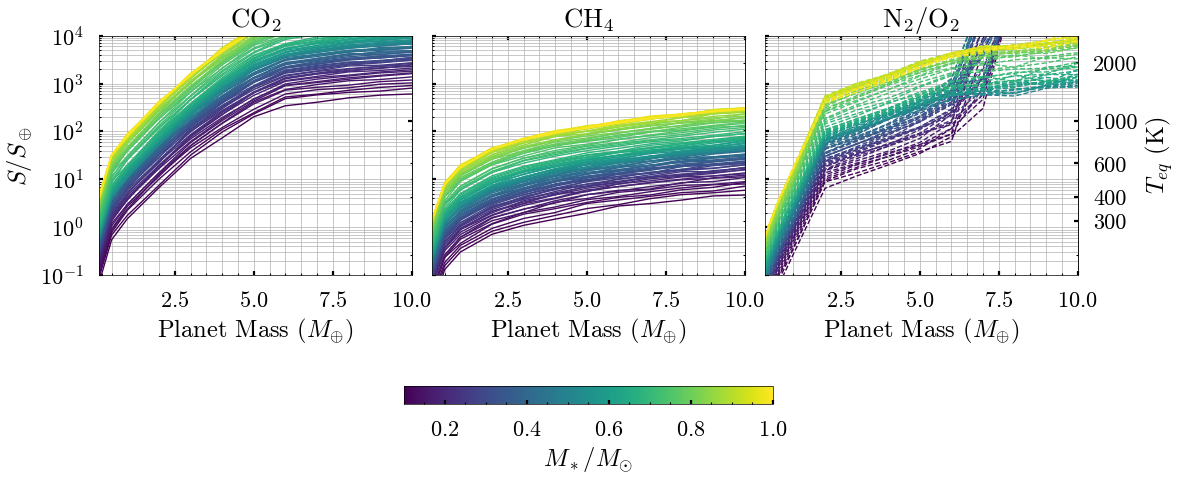

In [42]:
import matplotlib as mpl

MMWs = [44, 16, 28]
planet_masses = [0.1,0.5,1,2,3,4,5,6,7,8,9,10]
# stellar_mass_range = [[0.1,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8],[0.8,1.0]]
stellar_mass_range = [[x, x+0.01] for x in np.arange(0.1,1.001,0.01)]

pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*cs.earth_mass/(pl_rades*6.371e6))/1e3


fig, axes = plt.subplots(1, 3, figsize=(12,5),sharex=True,sharey=True)

colors = mpl.cm.viridis(np.linspace(0,1,len(stellar_mass_range)))
ls = ['-', '-', '--']
for n_x, MMW in enumerate(MMWs):
    for n_st, stellar_mass in enumerate(stellar_mass_range):
        axes[n_x].plot(pl_masses,CS_insol_01_tb[n_x,n_st,:,1],c=colors[n_st],lw=1,ls=ls[n_x])

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(0.1,10)
    ax.set_ylim(0.1,1e4)

axes[0].set_title('CO$_2$')
axes[1].set_title('CH$_4$')
axes[2].set_title('N$_2$/O$_2$')

axes[0].set_ylabel(r'$S/S_\oplus$')
axes[0].set_xlabel('Planet Mass ($M_{\oplus}$)')
axes[1].set_xlabel('Planet Mass ($M_{\oplus}$)')
axes[2].set_xlabel('Planet Mass ($M_{\oplus}$)')

# Conversion functions
def S_to_Teq(S):
    """Convert insolation S to equilibrium temperature T_eq."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (S * 1361 / 4 / sigma) ** 0.25

def Teq_to_S(Teq):
    """Convert equilibrium temperature T_eq back to insolation S."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (Teq**4 * sigma) / (1361/4)

for n_ax,ax in enumerate(axes):
    ax.tick_params(axis='y',which='both', right=False)
    ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
    ax.grid(True, which="both", ls="-", lw=0.5)
    if n_ax<2:
        ax2.tick_params(axis='y',which='both',labelright=False)
    else:
        ax2.set_ylabel('$T_{eq}$ (K)')
        ax2.set_yticks([300,400,600,1000,2000])
        ax2.set_yticklabels(['300','400','600','1000','2000'])
        
fig.tight_layout(w_pad=0)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.1, vmax=1.0), cmap='viridis'), ax=axes.ravel().tolist(), orientation='horizontal',fraction=0.05, pad=0.3)
cbar.set_label(r'$M_*/M_{\odot}$')


fig.savefig('./figures/CS_V2_insol_vs_mass.pdf',bbox_inches='tight')


In [58]:
df_combined = pd.concat([df_JWST_transit,df_JWST_direct,df_TSM,df_ESM,df_STSCI])
len(df_combined)

# Remove duplicates based on planet name
df_combined = df_combined.drop_duplicates(subset='pl_name', keep='first')

# Get the count of unique planets
unique_planets_count = len(df_combined)
print(f"Number of unique exoplanets in the combined dataset: {unique_planets_count}")

# Display the first few rows of the unique planets dataset
df_combined.head()

Number of unique exoplanets in the combined dataset: 109


Unnamed: 0       pl_name    hostname  default_flag  sy_snum  sy_pnum  \
422          422      K2-141 b      K2-141             1        1        2   
535          535       K2-22 b       K2-22             1        2        1   
1821        1821  Kepler-167 b  Kepler-167             1        2        4   
1822        1822  Kepler-167 c  Kepler-167             1        2        4   
1823        1823  Kepler-167 d  Kepler-167             1        2        4   

     discoverymethod  disc_year disc_facility  tran_flag  ... efficiency_kmag  \
422          Transit       2018            K2          1  ...        0.931624   
535          Transit       2015            K2          1  ...        1.000000   
1821         Transit       2014        Kepler          1  ...        1.000000   
1822         Transit       2014        Kepler          1  ...        1.000000   
1823         Transit       2016        Kepler          1  ...        1.000000   

          ed_ESM        ESM  pl_masse  pl_masseerr2  pl_masseerr1  \
422   167.092438  14.969734      4.97         -0.34          0.35   
535   362.568641   6.412798       NaN           NaN           NaN   
1821   37.952405   0.700320       NaN           NaN           NaN   
1822   23.916342   0.441318       NaN           NaN           NaN   
1823    4.607663   0.085023       NaN           NaN           NaN   

      pl_masse_calc       pl_g  pl_rho_ratio    pl_vesc  
422        4.970000  21.383141      1.064759  20.293814  
535       27.805500        NaN           NaN  38.893354  
1821       7.654782        NaN           NaN  23.611784  
1822       6.907537        NaN           NaN  22.722591  
1823       2.160215        NaN           NaN  14.776179  

[5 rows x 140 columns]

In [59]:
MMWs = [44, 16, 28]
planet_masses = [0.1,0.5,1,2,3,4,5,6,7,8,9,10]
# stellar_mass_range = [[0.1,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8],[0.8,1.0]]
stellar_mass_range = [[x, x+0.01] for x in np.arange(0.1,1.001,0.01)]
st_mass0_arr = np.arange(0.1,1.001,0.01)

pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*earth_mass/(pl_rades*6.371e6))/1e3


for i, item in df_combined.iterrows():
    n_st = np.argmin(np.abs(st_mass0_arr-item['st_mass']))
    CS_insol = CS_insol_01_tb[0,n_st,:,1]
    cs_interp = scipy.interpolate.interp1d(pl_v_esc, np.log10(CS_insol), kind='linear', fill_value='extrapolate')
    pl_loginsol_cri = cs_interp(item['pl_vesc'])
    score = pl_loginsol_cri - np.log10(item['pl_insol'])
    df_combined.loc[i,'score_CO2'] = score

for i, item in df_combined.iterrows():
    n_st = np.argmin(np.abs(st_mass0_arr-item['st_mass']))
    CS_insol = CS_insol_01_tb[1,n_st,:,1]
    cs_interp = scipy.interpolate.interp1d(pl_v_esc, np.log10(CS_insol), kind='linear', fill_value='extrapolate')
    pl_loginsol_cri = cs_interp(item['pl_vesc'])
    score = pl_loginsol_cri - np.log10(item['pl_insol'])
    df_combined.loc[i,'score_CH4'] = score

for i, item in df_combined.iterrows():
    n_st = np.argmin(np.abs(st_mass0_arr-item['st_mass']))
    CS_insol = CS_insol_01_tb[2,n_st,:,1]
    cs_interp = scipy.interpolate.interp1d(pl_v_esc, np.log10(CS_insol), kind='linear', fill_value='extrapolate')
    pl_loginsol_cri = cs_interp(item['pl_vesc'])
    score = pl_loginsol_cri - np.log10(item['pl_insol'])
    df_combined.loc[i,'score_N2O2'] = score
    
    # for n_st, stellar_mass in enumerate(stellar_mass_range):
    #     axes[n_x].plot(pl_masses,CS_insol_01_tb[n_x,n_st,:,1],c=colors[n_st],lw=1,ls=ls[n_x])


NameError: name 'CS_insol_01_tb' is not defined

In [ ]:
df_targets = df_combined.sort_values('score_CO2',ascending=False)
df_targets.to_csv('./figures/CS_exoplanets.csv',index=False)
df_targets.head()


Unnamed: 0     pl_name  hostname  default_flag  sy_snum  sy_pnum  \
3801        3801  TOI-1467 b  TOI-1467             1        1        1   
3798        3798  TOI-1452 b  TOI-1452             1        2        1   
3882        3882   TOI-198 b   TOI-198             1        1        1   
4175        4175   TOI-776 b   TOI-776             1        1        2   
535          535     K2-22 b     K2-22             1        2        1   

     discoverymethod  disc_year                                 disc_facility  \
3801         Transit       2024  Transiting Exoplanet Survey Satellite (TESS)   
3798         Transit       2022  Transiting Exoplanet Survey Satellite (TESS)   
3882         Transit       2023  Transiting Exoplanet Survey Satellite (TESS)   
4175         Transit       2020  Transiting Exoplanet Survey Satellite (TESS)   
535          Transit       2015                                            K2   

      tran_flag  ... pl_masse  pl_masseerr2 pl_masseerr1  pl_masse_calc  \
3801          1  ...      NaN           NaN          NaN      12.251538   
3798          1  ...     4.82          -1.3          1.3       4.820000   
3882          1  ...      NaN           NaN          NaN       3.816945   
4175          1  ...     5.00          -1.6          1.6       5.000000   
535           1  ...      NaN           NaN          NaN      27.805500   

           pl_g  pl_rho_ratio    pl_vesc  score_CO2  score_CH4  score_N2O2  
3801        NaN           NaN  28.256518   2.664211   0.503887    3.741602  
3798  16.913890      0.765481  18.992378   2.346829   0.563076    1.661028  
3882        NaN           NaN  18.211708   2.320062   0.596080    1.835278  
4175  15.172587      0.633739  18.653663   1.885707   0.151104    1.232943  
535         NaN           NaN  38.893354   1.838951  -0.125134    0.895148  

[5 rows x 143 columns]

In [60]:
# Convert the DataFrame to a LaTeX table string
df_targets_print = df_targets.fillna('-')
latex_table = df_targets_print.to_latex(index=False,float_format="%.2f")

# Print the LaTeX table to the console
print(latex_table)

# Optionally, you can save it to a .tex file
with open("table_with_ranks.tex", "w") as f:
    f.write(latex_table)

NameError: name 'df_targets' is not defined

# 3. Density Test

In [61]:
# Define the function to calculate remaining mass
earth_mass = 5.972e24  # in kg
earth_radius = 6.371e6  # in m

def Ps_solver(C0_mass, pl_teq, pl_masse, MMW, st_mass, plrade):
    if C0_mass != 0:
        f_c_magma = np.logspace(-9,0,100)
        C_tot = np.array([cs.cal_total_C_in_pl_mass_from_f_c(fc, pl_teq, pl_masse, MMW, st_mass, pl_radiuse=pl_rade) for fc in f_c_magma])
        interp = scipy.interpolate.interp1d(np.log10(C_tot), np.log10(f_c_magma), 
                                            bounds_error=False, fill_value=(-9, 0))
        f_c = 10**interp(np.log10(C0_mass/(pl_masse*earth_mass)))
        Ps, Ts = cs.Ps_Ts_from_f_c(f_c, pl_teq, pl_masse, MMW, C0_mass / (pl_masse * earth_mass),pl_radiuse=pl_rade)
    else:
        Ps = 0
    return Ps

In [62]:
f_initial = np.logspace(-6, -2, 50)
pl_masse_arr = [1,2,10]
pl_z_atm = np.zeros((4,len(pl_masse_arr),len(f_initial)))
pl_fc = np.zeros((2,len(pl_masse_arr),len(f_initial)))
pl_tsurf = np.zeros((2,len(pl_masse_arr),len(f_initial)))
pl_m_magma = np.zeros((2,len(pl_masse_arr),len(f_initial)))
pl_psurf = np.zeros((2,len(pl_masse_arr),len(f_initial)))


MMW = 44
pl_teq = 1000

cs = CosmicShoreline()

for n1,pl_masse in enumerate(pl_masse_arr):
    pl_rade = cs.M_R_fit(pl_masse, x_M_or_R='M', type='Earth')
    for n2, f_initial_values in enumerate(f_initial):
        C0_mass = pl_masse*earth_mass*f_initial_values
        
        f_c_magma = np.logspace(-9, 0, 50)
        C_tot = np.array([cs.cal_total_C_in_pl_mass_from_f_c(fc, pl_teq, pl_masse, MMW, 1) for fc in f_c_magma])
        interp_upp = scipy.interpolate.interp1d(np.log10(C_tot), np.log10(f_c_magma),
                                            bounds_error=False, fill_value=(-9, 0))
        f_c = 10**interp_upp(np.log10(C0_mass / (pl_masse * earth_mass)))
        pl_fc[0,n1,n2] = f_c

        C_tot = np.array([cs.cal_total_C_in_pl_mass_from_f_c(fc, pl_teq, pl_masse, MMW, 1, inversion=True) for fc in f_c_magma])
        interp_low = scipy.interpolate.interp1d(np.log10(C_tot), np.log10(f_c_magma),
                                            bounds_error=False, fill_value=(-9, 0))
        f_c = 10**interp_low(np.log10(C0_mass / (pl_masse * earth_mass)))
        pl_fc[1,n1,n2] = f_c

        Ps_upp, Ts_upp = cs.Ps_Ts_from_f_c(f_c, pl_teq, pl_masse, MMW, 1, C0_mass / (pl_masse * earth_mass))
        Ps_low, Ts_low = cs.Ps_Ts_from_f_c(f_c, pl_teq, pl_masse, MMW, 1, C0_mass / (pl_masse * earth_mass), inversion=True)
        pl_tsurf[0,n1,n2] = Ts_upp
        pl_tsurf[1,n1,n2] = Ts_low

        pl_psurf[0,n1,n2] = Ps_upp
        pl_psurf[1,n1,n2] = Ps_low

        pl_m_magma[0,n1,n2] = cs.cal_m_magma(Ts_upp,pl_masse)/(pl_masse*earth_mass)
        pl_m_magma[1,n1,n2] = cs.cal_m_magma(Ts_low,pl_masse)/(pl_masse*earth_mass)

        pl_z_atm[0,n1,n2] = cs.calculate_z_rad(pl_rade, pl_masse, 1e-6*1e5, Ps_upp, pl_teq, MMW, 
                                            T_adjust=True, g_adjust=True)/earth_radius/pl_rade
        pl_z_atm[1,n1,n2] = cs.calculate_z_rad(pl_rade, pl_masse, 1e-6*1e5, Ps_low, pl_teq, MMW,
                                            T_adjust=True, g_adjust=True, inversion=True)/earth_radius/pl_rade
        pl_z_atm[2,n1,n2] = cs.calculate_z_rad(pl_rade, pl_masse, 2e-2*1e5, Ps_upp, pl_teq, MMW,
                                            T_adjust=True, g_adjust=True)/earth_radius/pl_rade
        pl_z_atm[3,n1,n2] = cs.calculate_z_rad(pl_rade, pl_masse, 2e-2*1e5, Ps_low, pl_teq, MMW,
                                            T_adjust=True, g_adjust=True, inversion=True)/earth_radius/pl_rade

/home/xuanji/ipykernel_2281304/3113376803.py:54: RuntimeWarning: divide by zero encountered in divide
  return 1/rho**(1/3)
/home/xuanji/ipykernel_2281304/3113376803.py:54: RuntimeWarning: divide by zero encountered in divide
  return 1/rho**(1/3)


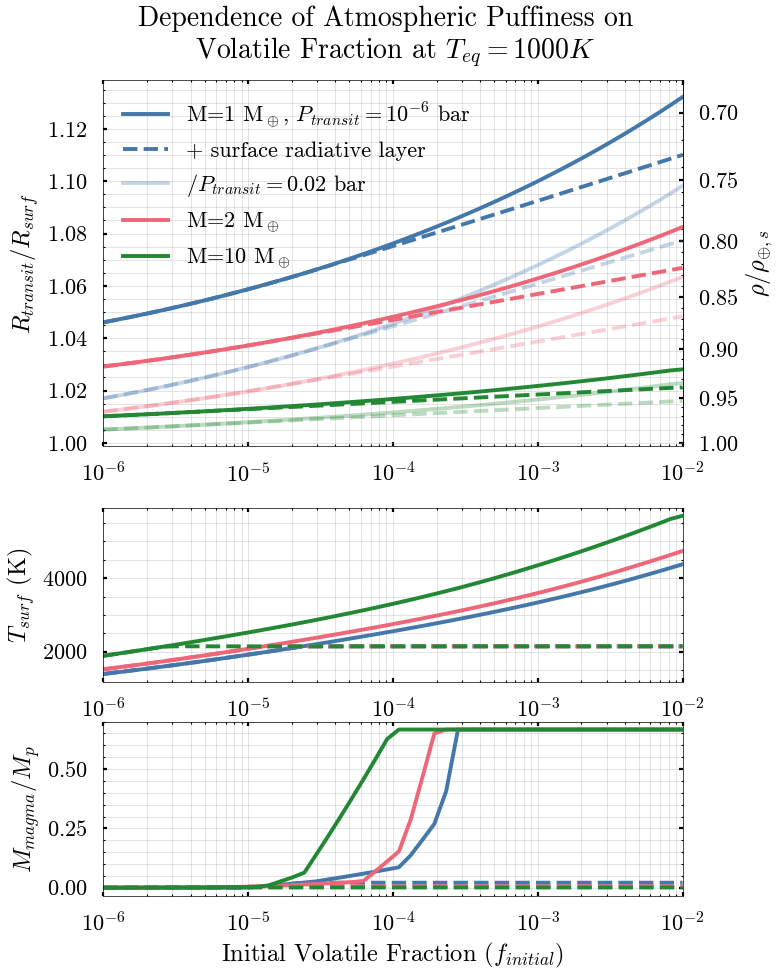

In [69]:
fig = plt.figure(figsize=(8,10))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)

for n1,pl_masse in enumerate(pl_masse_arr):
    if n1 == 0:
        ax1.plot(f_initial,pl_z_atm[0,n1],c=f'C{n1}',label=f'M={pl_masse} M$_\oplus$, $P_{{transit}}=10^{{-6}}$ bar')
        ax1.plot(f_initial,pl_z_atm[1,n1],c=f'C{n1}',ls='--',label=f'+ surface radiative layer')

        ax1.plot(f_initial,pl_z_atm[2,n1],c=f'C{n1}',alpha=0.3,label=f'$/P_{{transit}}=0.02$ bar')
    else:
        ax1.plot(f_initial,pl_z_atm[0,n1],c=f'C{n1}',label=f'M={pl_masse} M$_\oplus$')
        ax1.plot(f_initial,pl_z_atm[1,n1],c=f'C{n1}',ls='--')
        ax1.plot(f_initial,pl_z_atm[2,n1],c=f'C{n1}',alpha=0.3)
    ax1.plot(f_initial,pl_z_atm[3,n1],c=f'C{n1}',ls='--',alpha=0.3)

    ax2.plot(f_initial,pl_tsurf[0,n1],c=f'C{n1}')
    ax2.plot(f_initial,pl_tsurf[1,n1],c=f'C{n1}',ls='--')

    ax3.plot(f_initial,pl_m_magma[0,n1],c=f'C{n1}')
    ax3.plot(f_initial,pl_m_magma[1,n1],c=f'C{n1}',ls='--')

ax1.legend()

# ax2.set_ylim(0,3000)

# ax3.set_yscale('log')
# ax3.set_ylim(1e-3,1)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel('$R_{transit}/R_{surf}$')
ax2.set_ylabel('$T_{surf}$ (K)')
ax3.set_ylabel('$M_{magma}/M_p$')


for ax in [ax1,ax2,ax3]:
    ax.set_xlim(1e-6,1e-2)
    ax.grid(True, which="both", ls="-", alpha=0.5,lw=0.5)
ax3.set_xlabel('Initial Volatile Fraction ($f_{initial}$)')
# Conversion functions
def R_to_rho(R):
    # Constants
    
    return 1/R**3

def rho_to_R(rho):
    # Constants
    
    return 1/rho**(1/3)
ax1.tick_params(axis='y',which='both', right=False)
ax12 = ax1.secondary_yaxis('right', functions=(R_to_rho, rho_to_R))
ax12.set_ylabel(r'$\rho/\rho_{\oplus,s}$')
fig.suptitle('Dependence of Atmospheric Puffiness on \n Volatile Fraction at $T_{eq}=1000 K$',fontsize=20)

plt.tight_layout(h_pad=0)

fig.savefig('../figures_Jan/boosting_effect.pdf',bbox_inches='tight')


In [43]:
from scipy.optimize import root_scalar

def sample_generate(num_samples, no_comp=True, n_sigma=3,sample_rho = False):
    """
    Generate a sample of planetary systems with associated stellar and atmospheric properties.
    
    Parameters:
        num_samples (int): Number of samples to generate.
        no_comp (bool): If True, compute planet radius using a single mass-radius relation.
                        If False, add complexity (and noise) by comparing different models.
        n_sigma (float): Controls the width of the noise when no_comp is False.
        
    Returns:
        pd.DataFrame: DataFrame containing generated parameters for each sample.
    """
    # Instantiate cosmic calculation object (assumed to be defined elsewhere)
    cs = CosmicShoreline()

    # Generate initial random parameters

    def age_sample_generator(num_samples,st_mass=1,V2=False):
        if V2:
            age_dist_V2 = pd.read_csv('data-interpolation/st_age_dist_V2.csv',skiprows=4)
            age_dist_V2.head()
            bin_width = np.mean(age_dist_V2['age'].values[1:]-age_dist_V2['age'].values[:-1])
            bins = np.append(age_dist_V2['age'],age_dist_V2['age'].values[-1]+bin_width)
            counts = age_dist_V2['pdf'].values
            # Calculate probabilities
            probs = counts / np.sum(counts)

            # Generate random samples
            samples = []
            for _ in range(num_samples):
                # Choose bin
                bin_index = np.random.choice(len(bins) - 1, p=probs)
                
                # Sample within bin
                low = bins[bin_index]
                high = bins[bin_index + 1]
                sample = np.random.uniform(low, high)
                samples.append(sample)
        else:
            if st_mass >0.5:
                age_dist = pd.read_csv('data-interpolation/st_age_dist.csv',skiprows=4)
                bins = np.append(age_dist['age'],age_dist['age'].values[-1]+1.25)
                counts = age_dist['pdf'].values
                # Calculate probabilities
                probs = counts / np.sum(counts)
                samples = []
                for _ in range(num_samples):
                    # Choose bin
                    bin_index = np.random.choice(len(bins) - 1, p=probs)
                    
                    # Sample within bin
                    low = bins[bin_index]
                    high = bins[bin_index + 1]
                    sample = np.random.uniform(low, high)
                    samples.append(sample)
            else:
                age_dist = pd.read_csv('data-interpolation/st_age_dist_M.csv',skiprows=4)
                bins = np.append(age_dist['age'],age_dist['age'].values[-1]+0.2)
                counts = age_dist['pdf'].values
                # Calculate probabilities
                probs = counts / np.sum(counts)
                samples = []
                for _ in range(num_samples):
                    # Choose bin
                    bin_index = np.random.choice(len(bins) - 1, p=probs)
                    
                    # Sample within bin
                    low = bins[bin_index]
                    high = bins[bin_index + 1]
                    sample = np.random.uniform(low, high)
                    samples.append(sample)
        return np.array(samples)
    ##################################################
    # Constant for mean molecular weight
    MMW = 44

    # Generate initial random parameters
    stellar_mass = np.random.uniform(0.1, 1, num_samples)
    planet_mass = np.random.uniform(0.5, 10, num_samples)
    pl_insol = 10 ** np.random.uniform(1, 4, num_samples)

    stellar_age = age_sample_generator(num_samples,V2=True)*1e9


    formation_time = 10**np.random.uniform(0, 2, num_samples) * 1e6  # years
    xray_model = np.random.choice(["Selsis", "Jackson"], num_samples)
    euv_gamma1 = np.random.uniform(-0.35 - 0.15, -0.35 + 0.07, num_samples)
    euv_gamma2 = np.random.uniform(-0.76 - 0.04, -0.76 + 0.16, num_samples)
    CO2_fit = np.random.choice(["linear", "log", "GP"], num_samples)
    f_initial = 10 ** np.random.uniform(-4, -2, num_samples)

    # Calculate planet radius based on the 'no_comp' flag.
    if no_comp:
        # Single mass-radius relation for Earth-like planets
        planet_radius = cs.M_R_fit(planet_mass, x_M_or_R='M', type='Earth')
    elif n_sigma>0:
        # Add complexity by drawing from a distribution around the Earth-like value
        planet_radius = np.empty(num_samples)
        for i, mass in enumerate(planet_mass):
            rade_earth = cs.M_R_fit(mass, x_M_or_R='M', type='Earth')
            rade_rock = cs.M_R_fit(mass, x_M_or_R='M', type='rock')
            std = abs(rade_rock - rade_earth)/ n_sigma
            planet_radius[i] = np.random.normal(rade_earth, std)
    elif sample_rho:
        planet_radius = np.empty(num_samples)
        for i, mass in enumerate(planet_mass):
            rade_rock = cs.M_R_fit(mass, x_M_or_R='M', type='rock')
            rade_iron = cs.M_R_fit(mass, x_M_or_R='M', type='iron')
            rho_rock = mass/(4/3*np.pi*rade_rock**3)
            rho_iron = mass/(4/3*np.pi*rade_iron**3)
            rho = np.random.uniform(rho_iron, rho_rock)
            planet_radius[i] = (mass/(4/3*np.pi*rho))**(1/3)
    else:
        planet_radius = np.empty(num_samples)
        for i, mass in enumerate(planet_mass):
            # rade_earth = cs.M_R_fit(mass, x_M_or_R='M', type='Earth')
            rade_rock = cs.M_R_fit(mass, x_M_or_R='M', type='rock')
            rade_iron = cs.M_R_fit(mass, x_M_or_R='M', type='iron')
            planet_radius[i] = np.random.uniform(rade_iron, rade_rock)

    # Preallocate arrays for results
    pl_orbsmax = np.zeros(num_samples)
    pl_XUV_flux = np.zeros(num_samples)
    effective_temp = np.zeros(num_samples)

    atmospheric_loss = np.zeros(num_samples)
    m_atm_final = np.zeros(num_samples)
    pl_psurf_lower = np.zeros(num_samples)
    pl_psurf_lower_initial = np.zeros(num_samples)
    pl_psurf_upper = np.zeros(num_samples)
    pl_psurf_upper_initial = np.zeros(num_samples)

    pl_rade_transit_upper = np.zeros(num_samples)
    pl_rade_transit_upper_initial = np.zeros(num_samples)
    pl_rade_transit_lower = np.zeros(num_samples)
    pl_rade_transit_lower_initial = np.zeros(num_samples)

    pl_rho_ratio_lower = np.zeros(num_samples)
    pl_rho_ratio_lower_initial = np.zeros(num_samples)
    pl_rho_ratio_upper = np.zeros(num_samples)
    pl_rho_ratio_upper_initial = np.zeros(num_samples)

    # Loop over each sample to compute derived properties
    for i in range(num_samples):
        stellar_age[i] = max(stellar_age[i], formation_time[i] + 1e6)
        effective_temp[i] = (pl_insol[i]*1361/4/5.67e-8)**0.25
        orbital_distance = cs.calculate_pl_orbsmax(effective_temp[i], stellar_mass[i],time=stellar_age[i])
        L_xuv = cs.calculate_L_XUV(stellar_mass[i], stellar_age[i], method=xray_model[i])
        pl_XUV_flux[i] = cs._calculate_F_xuv_to_earth(L_xuv, orbital_distance)
        pl_orbsmax[i] = orbital_distance
        atmospheric_loss[i] = cs.integrate_carbon_loss(
            MMW, orbital_distance, planet_mass[i], stellar_mass[i],
            t1=formation_time[i],
            dt= stellar_age[i] - formation_time[i],
            method=xray_model[i],
            CO2_fit=CO2_fit[i],
            gamma1=euv_gamma1[i],
            gamma2=euv_gamma2[i],
            pl_radiuse =planet_radius[i],
        )

        m_atm_final[i] = max(planet_mass[i] * cs.earth_mass * f_initial[i] - atmospheric_loss[i],0)
        C0_mass = m_atm_final[i]
        pl_teq = effective_temp[i]
        pl_rade = planet_radius[i]
        pl_masse = planet_mass[i]
        st_mass = stellar_mass[i]

        # Calculate surface pressure only if some atmosphere remains.
        if m_atm_final[i] == 0:
            pl_psurf_lower[i] = 0
            pl_psurf_upper[i] = 0
        else:
            m_atm = C0_mass * MMW / 12
            pl_g = 9.8 * (pl_masse) / (pl_rade)**2
            psurf = m_atm * pl_g / (4 * np.pi * (pl_rade * cs.earth_radius)**2)
            Tsurf = cs.Ts_from_ps(pl_teq, psurf, pl_masse, MMW, st_mass)
            M_magma = cs.cal_m_magma(Tsurf, pl_masse)
            f_C0 = C0_mass / (pl_masse * cs.earth_mass)

            if M_magma > 0:
                # Define a function whose root gives the desired f_c:
                def func_low(log_fc):
                    # Calculate the total carbon in the planet mass
                    log_f_C_calc = np.log10(cs.cal_total_C_in_pl_mass_from_f_c(10**log_fc, 
                                                                               pl_teq, pl_masse, 
                                                                               MMW, st_mass,
                                                                               pl_radiuse=pl_rade,
                                                                               inversion=True))
                    log_f_C = np.log10(f_C0)
                    return  log_f_C_calc - log_f_C
                def func_high(log_fc):
                    # Calculate the total carbon in the planet mass
                    log_f_C_calc = np.log10(cs.cal_total_C_in_pl_mass_from_f_c(10**log_fc, 
                                                                               pl_teq, pl_masse, 
                                                                               MMW, st_mass,
                                                                               pl_radiuse=pl_rade,))
                    log_f_C = np.log10(f_C0)
                    return  log_f_C_calc - log_f_C

                sol_low = root_scalar(func_low, bracket=[-9, 0], method='bisect', xtol=1e-9)
                if sol_low.converged:
                    f_c_low = 10**sol_low.root
                else:
                    f_c_low = np.nan  # fallback if convergence failed

                sol_high = root_scalar(func_high, bracket=[-9, 0], method='bisect', xtol=1e-9)
                if sol_high.converged:
                    f_c_high = 10**sol_high.root
                else:
                    f_c_high = np.nan

                # Calculate the surface pressure
                Ps_low, _ = cs.Ps_Ts_from_f_c(f_c_low, pl_teq, pl_masse, MMW, st_mass, 
                                              f_C0, 
                                              pl_radiuse=pl_rade, inversion=True)
                Ps_high, _ = cs.Ps_Ts_from_f_c(f_c_high, pl_teq, pl_masse, MMW, st_mass, 
                                               f_C0,
                                               pl_radiuse=pl_rade)
                
                pl_psurf_lower[i] = Ps_low
                pl_psurf_upper[i] = Ps_high
            else:
                pl_psurf_lower[i] = psurf
                pl_psurf_upper[i] = psurf

        # compute the initial (pre-loss) surface pressure
        C0_mass_initial = pl_masse * cs.earth_mass * f_initial[i]
        m_atm_initial = C0_mass_initial * MMW / 12
        psurf_initial = m_atm_initial * pl_g / (4 * np.pi * (pl_rade * cs.earth_radius)**2)
        Tsurf_initial = cs.Ts_from_ps(pl_teq, psurf_initial, pl_masse, MMW, st_mass)
        M_magma_initial = cs.cal_m_magma(Tsurf_initial, pl_masse)
        f_C0_initial = C0_mass_initial / (pl_masse * cs.earth_mass)

        if M_magma_initial > 0:
            # Define a function whose root gives the desired f_c:
            def func_low_initial(log_fc):
                # Calculate the total carbon in the planet mass
                log_f_C_calc = np.log10(cs.cal_total_C_in_pl_mass_from_f_c(10**log_fc, 
                                                                               pl_teq, pl_masse, 
                                                                               MMW, st_mass,
                                                                               pl_radiuse=pl_rade,
                                                                               inversion=True))
                log_f_C = np.log10(f_C0_initial)
                return  log_f_C_calc - log_f_C
            def func_high_initial(log_fc):
                # Calculate the total carbon in the planet mass
                log_f_C_calc = np.log10(cs.cal_total_C_in_pl_mass_from_f_c(10**log_fc, 
                                                                               pl_teq, pl_masse, 
                                                                               MMW, st_mass,
                                                                               pl_radiuse=pl_rade))
                log_f_C = np.log10(f_C0_initial)
                return  log_f_C_calc - log_f_C
            
            sol_low_initial = root_scalar(func_low_initial, bracket=[-9, 0], method='bisect', xtol=1e-9)
            if sol_low_initial.converged:
                f_c_low_initial = 10**sol_low_initial.root
            else:
                f_c_low_initial = np.nan
            sol_high_initial = root_scalar(func_high_initial, bracket=[-9, 0], method='bisect', xtol=1e-9)
            if sol_high_initial.converged:
                f_c_high_initial = 10**sol_high_initial.root
            else:
                f_c_high_initial = np.nan
            
            # Calculate the surface pressure
            Ps_low_initial, _ = cs.Ps_Ts_from_f_c(f_c_low_initial, pl_teq, pl_masse, MMW, st_mass,
                                                  f_C0_initial,
                                                    pl_radiuse=pl_rade, inversion=True)
            Ps_high_initial, _ = cs.Ps_Ts_from_f_c(f_c_high_initial, pl_teq, pl_masse, MMW, st_mass,
                                                    f_C0_initial,
                                                     pl_radiuse=pl_rade)
            pl_psurf_lower_initial[i] = Ps_low_initial
            pl_psurf_upper_initial[i] = Ps_high_initial
        else:
            pl_psurf_lower_initial[i] = psurf_initial
            pl_psurf_upper_initial[i] = psurf_initial
        
        
        pl_rade_transit_lower[i] = cs.calculate_z_rad(
            pl_rade, pl_masse, 1e-6*1e5, pl_psurf_lower[i], pl_teq, MMW,
            T_adjust=True, g_adjust=True, inversion=True)/cs.earth_radius
        pl_rade_transit_upper[i] = cs.calculate_z_rad(
            pl_rade, pl_masse, 1e-6*1e5, pl_psurf_upper[i], pl_teq, MMW,
            T_adjust=True, g_adjust=True)/cs.earth_radius
        pl_rade_transit_lower_initial[i] = cs.calculate_z_rad(
            pl_rade, pl_masse, 1e-6*1e5, pl_psurf_lower_initial[i], pl_teq, MMW,
            T_adjust=True, g_adjust=True, inversion=True)/cs.earth_radius
        pl_rade_transit_upper_initial[i] = cs.calculate_z_rad(
            pl_rade, pl_masse, 1e-6*1e5, pl_psurf_upper_initial[i], pl_teq, MMW,
            T_adjust=True, g_adjust=True)/cs.earth_radius
        
        pl_rho_ratio_lower[i] = (cs.M_R_fit(pl_masse, x_M_or_R='M', type='Earth') ** 3 /
                                      pl_rade_transit_lower[i] ** 3)
        pl_rho_ratio_upper[i] = (cs.M_R_fit(pl_masse, x_M_or_R='M', type='Earth') ** 3 /
                                      pl_rade_transit_upper[i] ** 3)
        pl_rho_ratio_lower_initial[i] = (cs.M_R_fit(pl_masse, x_M_or_R='M', type='Earth') ** 3 /
                                      pl_rade_transit_lower_initial[i] ** 3)
        pl_rho_ratio_upper_initial[i] = (cs.M_R_fit(pl_masse, x_M_or_R='M', type='Earth') ** 3 /
                                      pl_rade_transit_upper_initial[i] ** 3)
    # Create a DataFrame to store the results
    data = pd.DataFrame({
        'st_mass': stellar_mass,
        'pl_masse': planet_mass,
        'pl_rade': planet_radius,
        'pl_insol': pl_insol,
        'stellar_age': stellar_age,
        'formation_time': formation_time,
        'xray_model': xray_model,
        'euv_gamma1': euv_gamma1,
        'euv_gamma2': euv_gamma2,
        'CO2_fit': CO2_fit,
        'f_initial': f_initial,
        'pl_orbsmax': pl_orbsmax,
        'pl_XUV_flux': pl_XUV_flux,
        'pl_teq': effective_temp,
        'atmospheric_loss': atmospheric_loss,
        'm_atm_final': m_atm_final,
        'pl_psurf_lower_initial': pl_psurf_lower_initial,
        'pl_psurf_upper_initial': pl_psurf_upper_initial,
        'pl_rade_transit_lower_initial': pl_rade_transit_lower_initial,
        'pl_rade_transit_upper_initial': pl_rade_transit_upper_initial,
        'pl_rho_ratio_lower_initial': pl_rho_ratio_lower_initial,
        'pl_rho_ratio_upper_initial': pl_rho_ratio_upper_initial,

    })
        

In [44]:
# earth_radius = 6.371e6  # in m
# rad_1d3 = cs.calculate_z_rad(1,1,2e-2*1e5,1e7,500,44,T_adjust = True, g_adjust=True, gamma=4/3)/earth_radius
# rad_1d1 = cs.calculate_z_rad(1,1,1e-1*1e5,1e7,500,44,T_adjust = True, g_adjust=True, gamma=1.1)/earth_radius
# rad_1d3_inversion = cs.calculate_z_rad(1,1,1e-1*1e5,1e7,500,44,T_adjust = True, g_adjust=True, inversion=True, gamma=4/3)/earth_radius


# print(rad_1d3,rad_1d3_inversion,rad_1d1)

In [45]:
from scipy.stats import linregress

def plot_trend(X,y,ax,line_color='black',face_color='gray',logfit=False):

    if logfit == True:
        X = np.log10(X)
        y = np.log10(y)
    if logfit =='x':
        X = np.log10(X)
    if logfit =='y':
        y = np.log10(y)
    # Perform a simple linear regression using scipy
    slope, intercept, r_value, p_value, std_err = linregress(X, y)

    # print(min(X),max(X))
    # Function to perform bootstrap sampling and refit the model
    def bootstrap(X, y, n_bootstrap=100):
        slopes = []
        intercepts = []
        
        # Bootstrap loop: sample with replacement and fit the line
        for _ in range(n_bootstrap):
            idx = np.random.choice(range(len(X)), size=int(len(X)), replace=True)
            X_resample = X[idx]
            y_resample = y[idx]
            
            slope_b, intercept_b, _, _, _ = linregress(X_resample, y_resample)
            slopes.append(slope_b)
            intercepts.append(intercept_b)
        
        return np.array(slopes), np.array(intercepts)

    # Perform bootstrapping to estimate uncertainty
    n_bootstrap = 1000
    boot_slopes, boot_intercepts = bootstrap(X, y, n_bootstrap)

    # Get the mean and confidence intervals (95%)
    slope_mean = np.mean(boot_slopes)
    intercept_mean = np.mean(boot_intercepts)

    X_plot = np.linspace(min(X), max(X), 100)

    if logfit == False:
        ax.plot(X_plot, slope * X_plot + intercept, color=line_color,zorder=80)

        ax.fill_between(X_plot, 
                        np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 2.5, axis=0),
                        np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 97.5, axis=0),
                        color=face_color, alpha=0.3,zorder=100)
    elif logfit == 'x':
        ax.plot(10**X_plot, (slope * X_plot + intercept), color=line_color,zorder=80)

        ax.fill_between(10**X_plot,
                        np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 2.5, axis=0),
                        np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 97.5, axis=0),
                        color=face_color, alpha=0.3,zorder=100)
    elif logfit == 'y':
        ax.plot(X_plot, 10**(slope * X_plot + intercept), color=line_color,zorder=80)
        ax.fill_between(X_plot,
                        np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 2.5, axis=0),
                        np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 97.5, axis=0),
                        color=face_color, alpha=0.3,zorder=100)
        
    else:
        ax.plot(10**X_plot, 10**(slope * X_plot + intercept), color=line_color,zorder=80)

        ax.fill_between(10**X_plot,
                        10**np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 2.5, axis=0),
                        10**np.percentile([slope_b * X_plot + intercept_b for slope_b, intercept_b in zip(boot_slopes, boot_intercepts)], 97.5, axis=0),
                        color=face_color, alpha=0.3,zorder=100)
    return slope_mean, intercept_mean, boot_slopes, boot_intercepts    

def plot_sample(sample,ax,rho_var = 'rho_ratio_lower',x_var='pl_masse',cbar_var='pl_teff',logfit=False):
    # ax.scatter(sample[x_var],sample[rho_var],
                # c=sample[cbar_var],cmap='BuPu_r',vmin=300,vmax=2000,s=20)
    sns.histplot(sample,x=x_var,y=rho_var,ax=ax,cbar=True)
    k,b,k_range,b_range = plot_trend(sample[x_var],
                sample[rho_var],
                ax,line_color='red',face_color='gray',logfit=logfit)
    plt.text(0.05,0.8,'k=%5.e'%k,transform=ax.transAxes, fontsize=20)


In [ ]:
data_no_comp = sample_generate(10000,no_comp=True)   
data_1sigma = sample_generate(10000,no_comp=False,n_sigma=1)
data_3sigma = sample_generate(10000,no_comp=False,n_sigma=3)
data_uni = sample_generate(10000,no_comp=False,n_sigma=0)
data_uni_rho = sample_generate(10000,no_comp=False,n_sigma=0,sample_rho=True)


data_no_comp.to_csv('./data-montecarlo/rho_data_no_comp.csv')
data_1sigma.to_csv('./data-montecarlo/rho_data_1sigma.csv')
data_3sigma.to_csv('./data-montecarlo/rho_data_3sigma.csv')
data_uni.to_csv('./data-montecarlo/rho_data_uni.csv')
data_uni_rho.to_csv('./data-montecarlo/rho_data_uni_rho.csv')

In [ ]:
data_no_comp = pd.read_csv('./data-montecarlo/rho_data_no_comp.csv')
data_1sigma = pd.read_csv('./data-montecarlo/rho_data_1sigma.csv')
data_3sigma = pd.read_csv('./data-montecarlo/rho_data_3sigma.csv')
data_uni = pd.read_csv('./data-montecarlo/rho_data_uni.csv')
data_uni_rho = pd.read_csv('./data-montecarlo/rho_data_uni_rho.csv')

In [ ]:
data_no_comp['pl_rho_ratio_solid'] = (cs.M_R_fit(data_no_comp['pl_masse'], x_M_or_R='M', type='Earth') ** 3 /
                                         data_no_comp['pl_rade'] ** 3)

data_1sigma['pl_rho_ratio_solid'] = (cs.M_R_fit(data_1sigma['pl_masse'], x_M_or_R='M', type='Earth') ** 3 /
                                            data_1sigma['pl_rade'] ** 3)

data_3sigma['pl_rho_ratio_solid'] = (cs.M_R_fit(data_3sigma['pl_masse'], x_M_or_R='M', type='Earth') ** 3 /
                                            data_3sigma['pl_rade'] ** 3)

data_uni['pl_rho_ratio_solid'] = (cs.M_R_fit(data_uni['pl_masse'], x_M_or_R='M', type='Earth') ** 3 /
                                            data_uni['pl_rade'] ** 3)

data_uni_rho['pl_rho_ratio_solid'] = (cs.M_R_fit(data_uni_rho['pl_masse'], x_M_or_R='M', type='Earth') ** 3 /
                                            data_uni_rho['pl_rade'] ** 3)

In [ ]:
df_rocks_sub = df_rocks[(df_rocks['pl_masseerr2']/df_rocks['pl_masse']<0.5)&(df_rocks['pl_masseerr1']/df_rocks['pl_masse']<0.5)]


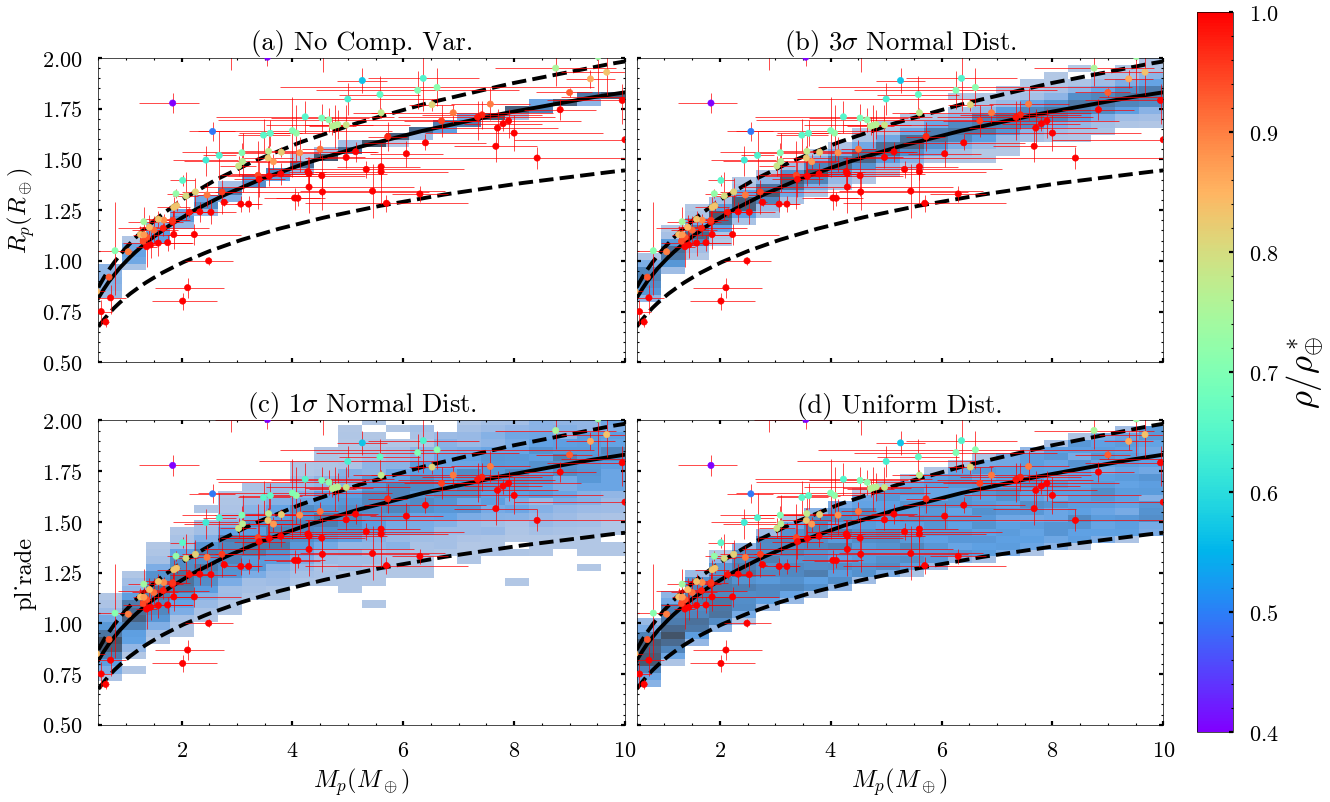

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8),sharex=True,sharey=True)

ax=axes.flatten()

sns.histplot(data_no_comp,x='pl_masse',y='pl_rade',ax=ax[0])
sns.histplot(data_3sigma,x='pl_masse',y='pl_rade',ax=ax[1])
sns.histplot(data_1sigma,x='pl_masse',y='pl_rade',ax=ax[2])
sns.histplot(data_uni,x='pl_masse',y='pl_rade',ax=ax[3])

pl_masse_arr = np.linspace(0.5,10,100)


ax[0].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='rock'),ls='--', color='black')
ax[1].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='rock'),ls='--', color='black')
ax[2].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='rock'),ls='--', color='black')
ax[3].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='rock'),ls='--', color='black')

ax[0].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='iron'),ls='--', color='black')
ax[1].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='iron'),ls='--', color='black')
ax[2].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='iron'),ls='--', color='black')
ax[3].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='iron'),ls='--', color='black')

ax[0].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='Earth'),ls='-', color='black')
ax[1].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='Earth'),ls='-', color='black')
ax[2].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='Earth'),ls='-', color='black')
ax[3].plot(pl_masse_arr,cs.M_R_fit(pl_masse_arr,x_M_or_R='M',type='Earth'),ls='-', color='black')


df_rocks_sub = df_rocks[(df_rocks['pl_masseerr2']/df_rocks['pl_masse']<0.5)&(df_rocks['pl_masseerr1']/df_rocks['pl_masse']<0.5)]

c_ax = ax[0].scatter(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],c=df_rocks_sub['pl_rho_ratio'],s=20,vmin=0.4,vmax=1.0,cmap="rainbow",zorder=10)
ax[1].scatter(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],c=df_rocks_sub['pl_rho_ratio'],s=20,vmin=0.4,vmax=1.0,cmap="rainbow",zorder=10)
ax[2].scatter(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],c=df_rocks_sub['pl_rho_ratio'],s=20,vmin=0.4,vmax=1.0,cmap="rainbow",zorder=10)
ax[3].scatter(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],c=df_rocks_sub['pl_rho_ratio'],s=20,vmin=0.4,vmax=1.0,cmap="rainbow",zorder=10)

ax[0].errorbar(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],xerr=[df_rocks_sub['pl_masseerr1'],-df_rocks_sub['pl_masseerr2']],
               yerr=[df_rocks_sub['pl_radeerr1'],-df_rocks_sub['pl_radeerr2']],fmt='none',ecolor='red',lw=0.5)
ax[1].errorbar(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],xerr=[df_rocks_sub['pl_masseerr1'],-df_rocks_sub['pl_masseerr2']],
                yerr=[df_rocks_sub['pl_radeerr1'],-df_rocks_sub['pl_radeerr2']],fmt='none',ecolor='red',lw=0.5)
ax[2].errorbar(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],xerr=[df_rocks_sub['pl_masseerr1'],-df_rocks_sub['pl_masseerr2']],
                yerr=[df_rocks_sub['pl_radeerr1'],-df_rocks_sub['pl_radeerr2']],fmt='none',ecolor='red',lw=0.5)
ax[3].errorbar(df_rocks_sub['pl_masse'],df_rocks_sub['pl_rade'],xerr=[df_rocks_sub['pl_masseerr1'],-df_rocks_sub['pl_masseerr2']],
                yerr=[df_rocks_sub['pl_radeerr1'],-df_rocks_sub['pl_radeerr2']],fmt='none',ecolor='red',lw=0.5)


for ax_i in ax:
    ax_i.set_xlim(0.5,10)
    ax_i.set_ylim(0.5,2)

ax[0].set_xlabel('$M_p(M_\oplus)$')
ax[1].set_xlabel('$M_p(M_\oplus)$')
ax[2].set_xlabel('$M_p(M_\oplus)$')
ax[3].set_xlabel('$M_p(M_\oplus)$')

ax[0].set_ylabel('$R_p(R_\oplus)$')
ax[1].set_ylabel('$R_p(R_\oplus)$')

ax[0].set_title('(a) No Comp. Var.')
ax[1].set_title('(b) 3$\sigma$ Normal Dist.')
ax[2].set_title('(c) 1$\sigma$ Normal Dist.')
ax[3].set_title('(d) Uniform Dist.')


plt.tight_layout(w_pad=0)

cbar_ax=fig.add_axes([1.001, 0.1, 0.05, 0.9])
cbar_ax.set_axis_off()
cba = plt.colorbar(c_ax, ax=cbar_ax,fraction=0.9, pad=0.5)
cba.set_label(r'$\rho$/$\rho^*_{\oplus}$',fontsize=25)


fig.savefig('./figures/MR_relation.png',bbox_inches='tight')


In [ ]:
data_no_comp_plot = data_no_comp.sample(5000)
data_3sigma_plot = data_3sigma.sample(5000)
data_uni_plot = data_uni.sample(5000)

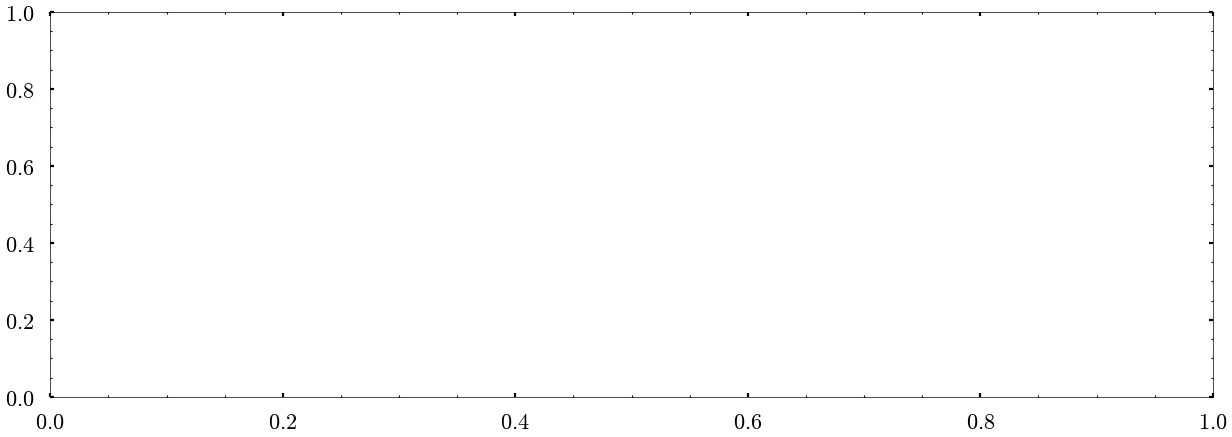

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,5))

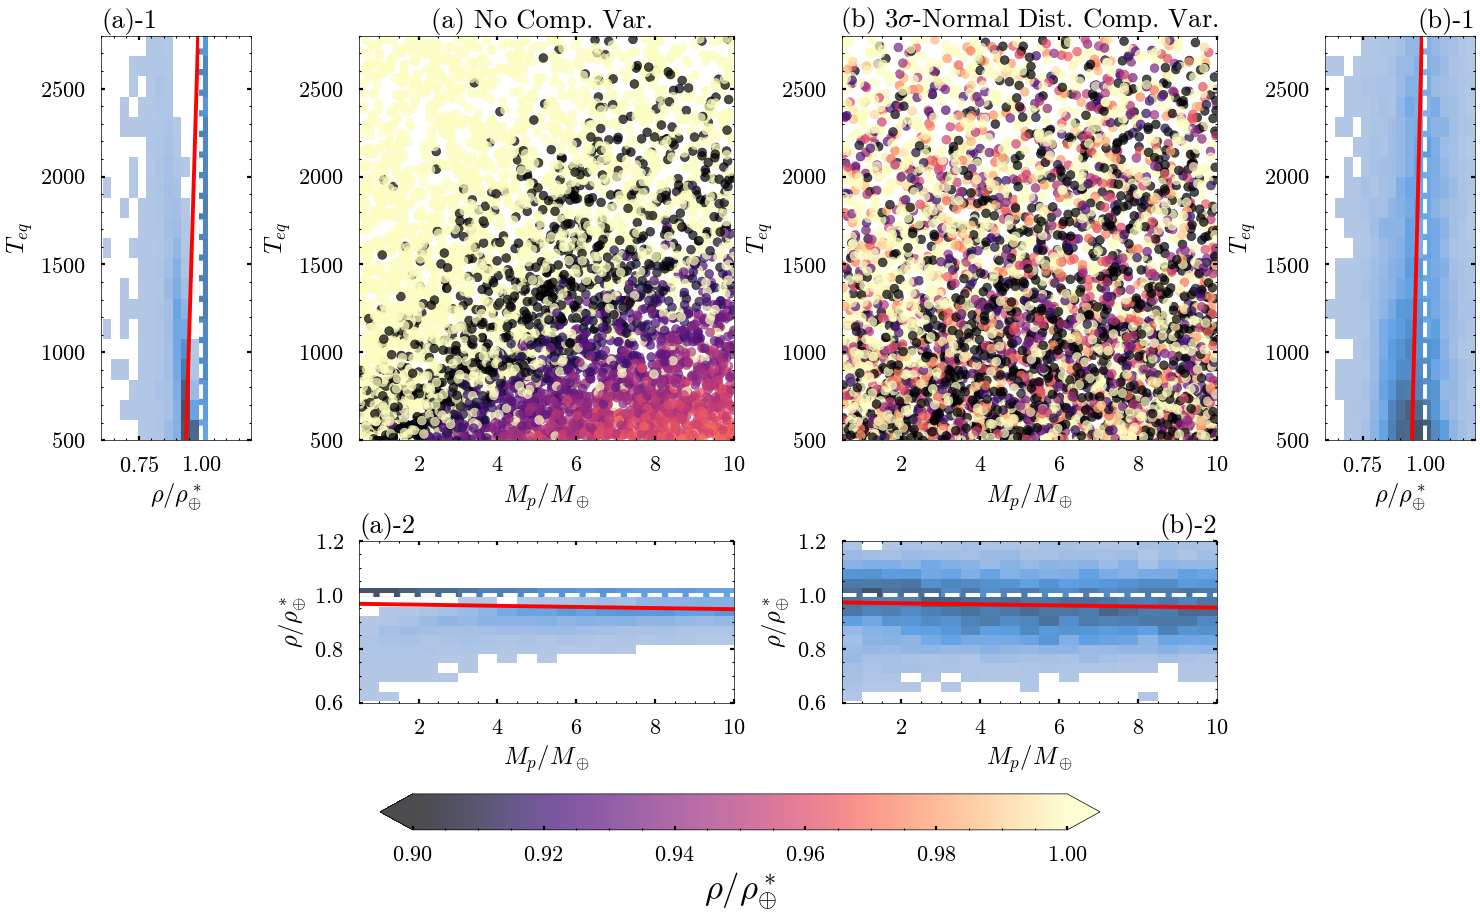

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8),width_ratios=[0.4,1,1,0.4],height_ratios=[1,0.4])

cb1 = axes[0,1].scatter(data_no_comp_plot['pl_masse'],data_no_comp_plot['pl_teff'],
                    c=data_no_comp_plot['pl_rho_ratio_lower'],
                    vmin=0.9,vmax=1.,s=40,cmap='magma',alpha=0.7)

# axes[0,1].scatter(data_no_comp_plot['pl_masse'][data_no_comp_plot['pl_rho_ratio_lower']>1],
# data_no_comp_plot['pl_teff'][data_no_comp_plot['pl_rho_ratio_lower']>1],
#                     c='gray',s=20,alpha=0.5) 




axes[0,1].set_ylabel('$T_{eq}$')
axes[0,1].set_xlabel('$M_p/M_\oplus$')


sns.histplot(data_no_comp,x='pl_rho_ratio_lower',y='pl_teff',log_scale=(False,False),ax=axes[0,0],
             bins=20,binrange=([0.5,1.2],[500,2800]))
sns.histplot(data_no_comp,x='pl_masse',y='pl_rho_ratio_lower',log_scale=(False,False),ax=axes[1,1],
             bins=20,binrange=([0,10],[0.5,1.2]))
axes[1,0].axis('off')
axes[1,3].axis('off')


axes[0,2].scatter(data_3sigma_plot['pl_masse'],data_3sigma_plot['pl_teff'],
                  c=data_3sigma_plot['pl_rho_ratio_lower'],
                    vmin=0.9,vmax=1.,s=40,cmap='magma',alpha=0.7)

axes[0,2].set_ylabel('$T_{eq}$')
axes[0,2].set_xlabel('$M_p/M_\oplus$')

sns.histplot(data_3sigma,x='pl_rho_ratio_lower',y='pl_teff',log_scale=(False,False),ax=axes[0,3],
              bins=20,binrange=([0.5,1.2],[500,2800]))
sns.histplot(data_3sigma,x='pl_masse',y='pl_rho_ratio_lower',log_scale=(False,False),ax=axes[1,2],
             bins=20,binrange=([0,10],[0.5,1.2]))

axes[0,0].set_xlim(0.6,1.2)
axes[0,3].set_xlim(0.6,1.2)
axes[1,1].set_ylim(0.6,1.2)
axes[1,2].set_ylim(0.6,1.2)

axes[0,0].set_ylim(500,2800)
axes[0,3].set_ylim(500,2800)
axes[0,1].set_ylim(500,2800)
axes[0,2].set_ylim(500,2800)

axes[0,1].set_xlim(0.5,10)
axes[0,2].set_xlim(0.5,10)
axes[1,1].set_xlim(0.5,10)
axes[1,2].set_xlim(0.5,10)


axes[0,0].set_ylabel(r'$T_{eq}$')
axes[0,0].set_xlabel(r'$\rho/\rho^*_{\oplus}$')

axes[0,3].set_ylabel(r'$T_{eq}$')
axes[0,3].set_xlabel(r'$\rho/\rho^*_{\oplus}$')

axes[1,1].set_ylabel(r'$\rho/\rho^*_{\oplus}$')
axes[1,1].set_xlabel(r'$M_p/M_\oplus$')

axes[1,2].set_ylabel(r'$\rho/\rho^*_{\oplus}$')
axes[1,2].set_xlabel(r'$M_p/M_\oplus$')

k_S_no_comp, b_S_no_comp, k_S_no_comp_range, b_S_no_comp_range = plot_trend(data_no_comp['pl_teff'],data_no_comp['pl_rho_ratio_lower'],
                ax,line_color='black',face_color='gray')
k_S_3sigma, b_S_3sigma, k_S_3sigma_range, b_S_3sigma_range = plot_trend(data_3sigma['pl_teff'],data_3sigma['pl_rho_ratio_lower'],
                ax,line_color='black',face_color='gray')
k_S_uni, b_S_uni, k_S_uni_range, b_S_uni_range = plot_trend(data_uni['pl_teff'],data_uni['pl_rho_ratio_lower'],
                ax,line_color='black',face_color='gray')
k_Mp_no_comp, b_Mp_no_comp, k_Mp_no_comp_range, b_Mp_no_comp_range = plot_trend(data_no_comp['pl_masse'],data_no_comp['pl_rho_ratio_lower'],
                ax,line_color='black',face_color='gray')
k_Mp_3sigma, b_Mp_3sigma, k_Mp_3sigma_range, b_Mp_3sigma_range = plot_trend(data_3sigma['pl_masse'],data_3sigma['pl_rho_ratio_lower'],
                ax,line_color='black',face_color='gray')
k_Mp_uni, b_Mp_uni, k_Mp_uni_range, b_Mp_uni_range = plot_trend(data_uni['pl_masse'],data_uni['pl_rho_ratio_lower'],
                ax,line_color='black',face_color='gray')

S_arr = np.linspace(500,2800,100)
Mp_arr = np.linspace(0.5,10,100)
axes[0,0].plot(k_S_no_comp*(S_arr)+b_S_no_comp,S_arr,ls='-',color='r')
axes[0,3].plot(k_S_3sigma*(S_arr)+b_S_3sigma,S_arr,ls='-',color='r')
axes[1,1].plot(Mp_arr,k_Mp_no_comp*Mp_arr+b_Mp_no_comp,ls='-',color='r')
axes[1,2].plot(Mp_arr,k_Mp_3sigma*Mp_arr+b_Mp_3sigma,ls='-',color='r')

# axes[0,0].fill_betweenx(S_arr, np.percentile([k_i*np.log10(S_arr)+b_i for k_i, b_i in zip(k_S_no_comp_range, b_S_no_comp_range)], 2.5, axis=0),
#                         np.percentile([k_i*np.log10(S_arr)+b_i for k_i, b_i in zip(k_S_no_comp_range, b_S_no_comp_range)], 97.5, axis=0),
#                         color='r', alpha=0.8,zorder=10)

# axes[0,3].fill_betweenx(S_arr, np.percentile([k_i*np.log10(S_arr)+b_i for k_i, b_i in zip(k_S_3sigma_range, b_S_3sigma_range)], 2.5, axis=0),
#                         np.percentile([k_i*np.log10(S_arr)+b_i for k_i, b_i in zip(k_S_3sigma_range, b_S_3sigma_range)], 97.5, axis=0),
#                         color='r', alpha=0.8,zorder=10)

# axes[1,1].fill_between(Mp_arr, np.percentile([k_i*Mp_arr+b_i for k_i, b_i in zip(k_Mp_no_comp_range, b_Mp_no_comp_range)], 2.5, axis=0),  
#                         np.percentile([k_i*Mp_arr+b_i for k_i, b_i in zip(k_Mp_no_comp_range, b_Mp_no_comp_range)], 97.5, axis=0),
#                         color='r', alpha=0.8,zorder=10)
# axes[1,2].fill_between(Mp_arr, np.percentile([k_i*Mp_arr+b_i for k_i, b_i in zip(k_Mp_3sigma_range, b_Mp_3sigma_range)], 2.5, axis=0),  
#                         np.percentile([k_i*Mp_arr+b_i for k_i, b_i in zip(k_Mp_3sigma_range, b_Mp_3sigma_range)], 97.5, axis=0),
#                         color='r', alpha=0.8,zorder=10)

axes[0,0].axvline(1,ls='--',color='w')
axes[0,3].axvline(1,ls='--',color='w')
axes[1,1].axhline(1,ls='--',color='w')
axes[1,2].axhline(1,ls='--',color='w')

axes[0,1].set_title('(a) No Comp. Var. ')
axes[0,2].set_title('(b) 3$\sigma$-Normal Dist. Comp. Var.')

axes[0,0].set_title('(a)-1', loc='left')
axes[0,3].set_title('(b)-1', loc='right')
axes[1,1].set_title('(a)-2', loc='left')
axes[1,2].set_title('(b)-2', loc='right')

plt.tight_layout(w_pad=0,h_pad=0)

cbar_ax=fig.add_axes([0.1, -0.05, 0.8, 0.05])
cbar_ax.set_axis_off()
cba = plt.colorbar(cb1, ax=cbar_ax,fraction=0.9, pad=0.5,orientation='horizontal', extend='both')
cba.set_label(r'$\rho$/$\rho^*_{\oplus}$',fontsize=25)

fig.savefig('./figures/rho_ratio_pattern.pdf',bbox_inches='tight')
fig.savefig('./figures/rho_ratio_pattern.png',bbox_inches='tight')



In [ ]:
from scipy.stats import linregress
def k_bootstrap(
    X,
    y,
    sample_sizes= np.logspace(1, 3, 10).astype(int),
    n_bootstrap=500
):
    """
    Evaluate how linear regression parameters vary with sample size using bootstrap.
    
    Parameters
    ----------
    X : array-like of shape (N,) or (N, d)
        Features from the original sample of size N=10000.
    y : array-like of shape (N,)
        Target/response from the original sample of size N=10000.
    sample_sizes : list of int
        List of sample sizes for which we want to test the linear model.
    n_bootstrap : int
        Number of bootstrap iterations for each sample size.
    
    Returns
    -------
    results : dict
        Dictionary keyed by sample_size, containing statistics (mean, std) for slope, intercept,
        and optionally other metrics.
    """
    
    # Ensure X is a 2D array if using scikit-learn's LinearRegression
    X = np.array(X)
    y = np.array(y)
    

    slope_mean_arr = np.zeros(len(sample_sizes))
    slope_conf_arr = np.zeros((len(sample_sizes),2))

    for i, size in enumerate(sample_sizes):
        slopes = []
        intercepts = []
        
        # Bootstrap loop: sample with replacement and fit the line
        for _ in range(n_bootstrap):
            idx = np.random.choice(range(len(X)), size=size)
            X_resample = X[idx]
            y_resample = y[idx]
            
            slope_b, intercept_b, _, _, _ = linregress(X_resample, y_resample)
            slopes.append(slope_b)
            intercepts.append(intercept_b)
        
        boot_slopes = np.array(slopes)

        # Get the mean and confidence intervals (90%)
        slope_mean = np.mean(boot_slopes)
        slope_conf = np.percentile(boot_slopes, [10, 90])
        
        slope_mean_arr[i] = slope_mean
        slope_conf_arr[i] = slope_conf
        
    return slope_mean_arr, slope_conf_arr

In [ ]:
sample_size = np.logspace(1, 4, 10).astype(int)

k_lower_0sigma_mp, k_conf_lower_0sigma_mp = k_bootstrap(data_no_comp['pl_masse'],data_no_comp['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_0sigma_mp, k_conf_upper_0sigma_mp = k_bootstrap(data_no_comp['pl_masse'],data_no_comp['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_3sigma_mp, k_conf_lower_3sigma_mp = k_bootstrap(data_3sigma['pl_masse'],data_3sigma['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_3sigma_mp, k_conf_upper_3sigma_mp = k_bootstrap(data_3sigma['pl_masse'],data_3sigma['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_1sigma_mp, k_conf_lower_1sigma_mp = k_bootstrap(data_1sigma['pl_masse'],data_1sigma['pl_rho_ratio_lower'],sample_sizes=sample_size) 
k_upper_1sigma_mp, k_conf_upper_1sigma_mp = k_bootstrap(data_1sigma['pl_masse'],data_1sigma['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_uni_mp, k_conf_lower_uni_mp = k_bootstrap(data_uni['pl_masse'],data_uni['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_uni_mp, k_conf_upper_uni_mp = k_bootstrap(data_uni['pl_masse'],data_uni['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_uni_rho_mp, k_conf_lower_uni_rho_mp = k_bootstrap(data_uni_rho['pl_masse'],data_uni_rho['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_uni_rho_mp, k_conf_upper_uni_rho_mp = k_bootstrap(data_uni_rho['pl_masse'],data_uni_rho['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_0sigma_teq, k_conf_lower_0sigma_teq = k_bootstrap(data_no_comp['pl_teff'],data_no_comp['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_0sigma_teq, k_conf_upper_0sigma_teq = k_bootstrap(data_no_comp['pl_teff'],data_no_comp['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_3sigma_teq, k_conf_lower_3sigma_teq = k_bootstrap(data_3sigma['pl_teff'],data_3sigma['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_3sigma_teq, k_conf_upper_3sigma_teq = k_bootstrap(data_3sigma['pl_teff'],data_3sigma['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_1sigma_teq, k_conf_lower_1sigma_teq = k_bootstrap(data_1sigma['pl_teff'],data_1sigma['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_1sigma_teq, k_conf_upper_1sigma_teq = k_bootstrap(data_1sigma['pl_teff'],data_1sigma['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_uni_teq, k_conf_lower_uni_teq = k_bootstrap(data_uni['pl_teff'],data_uni['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_uni_teq, k_conf_upper_uni_teq = k_bootstrap(data_uni['pl_teff'],data_uni['pl_rho_ratio_upper'],sample_sizes=sample_size)

k_lower_uni_rho_teq, k_conf_lower_uni_rho_teq = k_bootstrap(data_uni_rho['pl_teff'],data_uni_rho['pl_rho_ratio_lower'],sample_sizes=sample_size)
k_upper_uni_rho_teq, k_conf_upper_uni_rho_teq = k_bootstrap(data_uni_rho['pl_teff'],data_uni_rho['pl_rho_ratio_upper'],sample_sizes=sample_size)

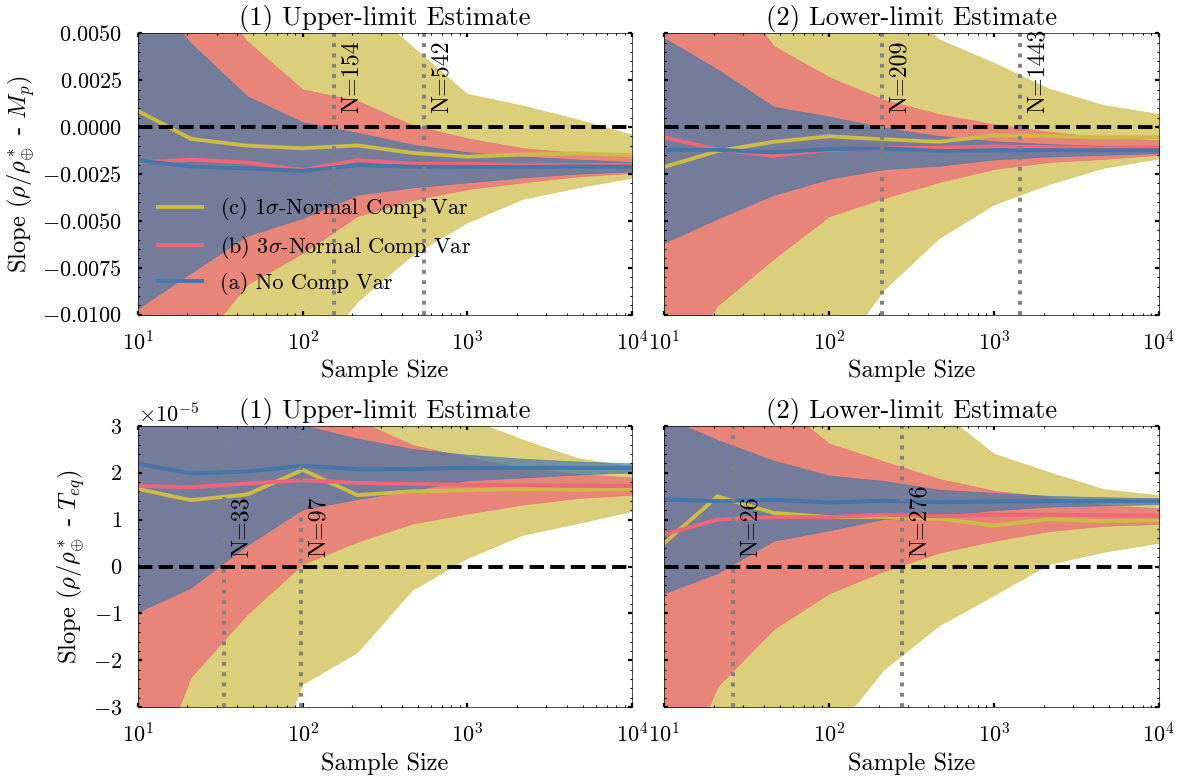

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(12,8),sharey='row')


# axes[0,0].plot(sample_size,k_lower_uni_mp,label='Uniform Comp Var',color='C3')
# axes[0,0].fill_between(sample_size,k_conf_lower_uni_mp[:,0],k_conf_lower_uni_mp[:,1],alpha=0.7,color='C3')

axes[0,0].plot(sample_size,k_lower_1sigma_mp,label='(c) 1$\sigma$-Normal Comp Var',color='C3')
axes[0,0].fill_between(sample_size,k_conf_lower_1sigma_mp[:,0],k_conf_lower_1sigma_mp[:,1],alpha=0.7,color='C3')

axes[0,0].plot(sample_size,k_lower_3sigma_mp,label='(b) 3$\sigma$-Normal Comp Var',color='C1')
axes[0,0].fill_between(sample_size,k_conf_lower_3sigma_mp[:,0],k_conf_lower_3sigma_mp[:,1],alpha=0.7,color='C1')

axes[0,0].plot(sample_size,k_lower_0sigma_mp,label='(a) No Comp Var',color='C0')
axes[0,0].fill_between(sample_size,k_conf_lower_0sigma_mp[:,0],k_conf_lower_0sigma_mp[:,1],alpha=0.7,color='C0')

axes[0,0].set_xscale('log')
axes[0,0].set_ylabel(r'Slope ($\rho/\rho^*_{\oplus}$ - $M_p$)')
axes[0,0].set_xlabel('Sample Size')

# axes[0,1].plot(sample_size,k_upper_uni_mp,label='Uniform Comp Var',color='C3')
# axes[0,1].fill_between(sample_size,k_conf_upper_uni_mp[:,0],k_conf_upper_uni_mp[:,1],alpha=0.7,color='C3')

axes[0,1].plot(sample_size,k_upper_1sigma_mp,label='1$\sigma$ Comp Var',color='C3')
axes[0,1].fill_between(sample_size,k_conf_upper_1sigma_mp[:,0],k_conf_upper_1sigma_mp[:,1],alpha=0.7,color='C3')

axes[0,1].plot(sample_size,k_upper_3sigma_mp,label='3$\sigma$ Comp Var',color='C1')
axes[0,1].fill_between(sample_size,k_conf_upper_3sigma_mp[:,0],k_conf_upper_3sigma_mp[:,1],alpha=0.7,color='C1')

axes[0,1].plot(sample_size,k_upper_0sigma_mp,label='No Comp Var',color='C0')
axes[0,1].fill_between(sample_size,k_conf_upper_0sigma_mp[:,0],k_conf_upper_0sigma_mp[:,1],alpha=0.7,color='C0')

axes[0,1].set_xscale('log')
axes[0,1].set_xlabel('Sample Size')

# axes[1,0].plot(sample_size,k_lower_uni_teq,label='Uniform Comp Var',color='C3')
# axes[1,0].fill_between(sample_size,k_conf_lower_uni_teq[:,0],k_conf_lower_uni_teq[:,1],alpha=0.7,color='C3')    

axes[1,0].plot(sample_size,k_lower_1sigma_teq,label='(c) 1$\sigma$ Comp Var',color='C3')
axes[1,0].fill_between(sample_size,k_conf_lower_1sigma_teq[:,0],k_conf_lower_1sigma_teq[:,1],alpha=0.7,color='C3')

axes[1,0].plot(sample_size,k_lower_3sigma_teq,label='(b) 3$\sigma$ Comp Var',color='C1')
axes[1,0].fill_between(sample_size,k_conf_lower_3sigma_teq[:,0],k_conf_lower_3sigma_teq[:,1],alpha=0.7,color='C1')

axes[1,0].plot(sample_size,k_lower_0sigma_teq,label='(a) No Comp Var',color='C0')
axes[1,0].fill_between(sample_size,k_conf_lower_0sigma_teq[:,0],k_conf_lower_0sigma_teq[:,1],alpha=0.7,color='C0')

axes[1,0].set_xscale('log')
axes[1,0].set_ylabel(r'Slope ($\rho/\rho^*_{\oplus}$ - $T_{eq}$)')
axes[1,0].set_xlabel('Sample Size')

# axes[1,1].plot(sample_size,k_upper_uni_teq,label='Uniform Comp Var',color='C3')
# axes[1,1].fill_between(sample_size,k_conf_upper_uni_teq[:,0],k_conf_upper_uni_teq[:,1],alpha=0.7,color='C3')

axes[1,1].plot(sample_size,k_upper_1sigma_teq,label='(c) 1$\sigma$ Comp Var',color='C3')
axes[1,1].fill_between(sample_size,k_conf_upper_1sigma_teq[:,0],k_conf_upper_1sigma_teq[:,1],alpha=0.7,color='C3')

axes[1,1].plot(sample_size,k_upper_3sigma_teq,label='(b) 3$\sigma$ Comp Var',color='C1')
axes[1,1].fill_between(sample_size,k_conf_upper_3sigma_teq[:,0],k_conf_upper_3sigma_teq[:,1],alpha=0.7,color='C1')

axes[1,1].plot(sample_size,k_upper_0sigma_teq,label='(a) No Comp Var',color='C0')
axes[1,1].fill_between(sample_size,k_conf_upper_0sigma_teq[:,0],k_conf_upper_0sigma_teq[:,1],alpha=0.7,color='C0')

axes[1,1].set_xscale('log')
axes[1,1].set_xlabel('Sample Size')

for ax in axes.flatten():
    ax.axhline(0,ls='--',color='black')
    ax.set_xlim(10,10000)

axes[0,0].set_ylim(-0.01,0.005)
axes[1,0].set_ylim(-0.00003,0.00003)

N_0_upper_M = scipy.interpolate.interp1d(k_conf_upper_0sigma_mp[:,1],sample_size,bounds_error=False,fill_value='extrapolate')(0)
N_0_lower_M = scipy.interpolate.interp1d(k_conf_lower_0sigma_mp[:,1],sample_size,bounds_error=False,fill_value='extrapolate')(0)
N_3_upper_M = scipy.interpolate.interp1d(k_conf_upper_3sigma_mp[:,1],sample_size,bounds_error=False,fill_value='extrapolate')(0)
N_3_lower_M = scipy.interpolate.interp1d(k_conf_lower_3sigma_mp[:,1],sample_size,bounds_error=False,fill_value='extrapolate')(0)

N_0_upper_T = scipy.interpolate.interp1d(k_conf_upper_0sigma_teq[:,0],sample_size,bounds_error=False,fill_value='extrapolate')(0)
N_0_lower_T = scipy.interpolate.interp1d(k_conf_lower_0sigma_teq[:,0],sample_size,bounds_error=False,fill_value='extrapolate')(0)
N_3_upper_T = scipy.interpolate.interp1d(k_conf_upper_3sigma_teq[:,0],sample_size,bounds_error=False,fill_value='extrapolate')(0)
N_3_lower_T = scipy.interpolate.interp1d(k_conf_lower_3sigma_teq[:,0],sample_size,bounds_error=False,fill_value='extrapolate')(0)   

axes[0,1].axvline(N_0_upper_M,ls=':',color='gray')
axes[0,0].axvline(N_0_lower_M,ls=':',color='gray')
axes[0,1].axvline(N_3_upper_M,ls=':',color='gray')
axes[0,0].axvline(N_3_lower_M,ls=':',color='gray')

axes[1,1].axvline(N_0_upper_T,ls=':',color='gray')
axes[1,0].axvline(N_0_lower_T,ls=':',color='gray')
axes[1,1].axvline(N_3_upper_T,ls=':',color='gray')
axes[1,0].axvline(N_3_lower_T,ls=':',color='gray')

axes[0,1].text(N_0_upper_M*1.1,0.001,'N=%d'%N_0_upper_M,rotation=90,color='k',fontsize='xx-large')
axes[0,0].text(N_0_lower_M*1.1,0.001,'N=%d'%N_0_lower_M,rotation=90,color='k',fontsize='xx-large')
axes[0,1].text(N_3_upper_M*1.1,0.001,'N=%d'%N_3_upper_M,rotation=90,color='k',fontsize='xx-large')
axes[0,0].text(N_3_lower_M*1.1,0.001,'N=%d'%N_3_lower_M,rotation=90,color='k',fontsize='xx-large')

axes[1,1].text(N_0_upper_T*1.1,3e-6,'N=%d'%N_0_upper_T,rotation=90,color='k',fontsize='xx-large')
axes[1,0].text(N_0_lower_T*1.1,3e-6,'N=%d'%N_0_lower_T,rotation=90,color='k',fontsize='xx-large')
axes[1,1].text(N_3_upper_T*1.1,3e-6,'N=%d'%N_3_upper_T,rotation=90,color='k',fontsize='xx-large')
axes[1,0].text(N_3_lower_T*1.1,3e-6,'N=%d'%N_3_lower_T,rotation=90,color='k',fontsize='xx-large')

axes[0,0].legend()

axes[0,0].set_title('(1) Upper-limit Estimate')
axes[0,1].set_title('(2) Lower-limit Estimate')
axes[1,0].set_title('(1) Upper-limit Estimate')
axes[1,1].set_title('(2) Lower-limit Estimate')

fig.tight_layout(w_pad=0)

fig.savefig('../figures_Jan/slope_vs_sample_size.pdf',bbox_inches='tight')

